In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from moviepy.editor import VideoFileClip
%matplotlib inline

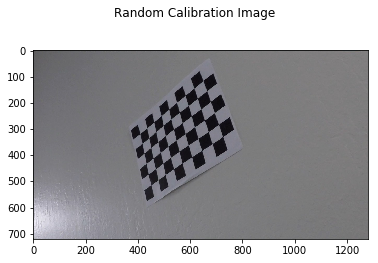

In [2]:
# sample calibration images
import random

index = random.randint(0, 20)
name = 'camera_cal/calibration' + str(index) + '.jpg'
img = mpimage.imread(name)
plt.suptitle('Random Calibration Image')
plt.imshow(img)

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpts` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpts` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpts` and `imgpts` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained the results. Sample images of these are shown in the code cells below.

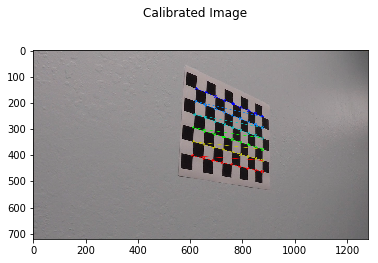

In [3]:
import glob

# preparing points as (0,0,0).. etc.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpts = [] # real word points (3d space)
imgpts = [] # 2d points - image space

images = glob.glob('camera_cal/calibration*.jpg')

for i, name in enumerate(images):
    img = cv2.imread(name)
    # convert from bgr to gray image.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # append object points & image points if corners are found
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)
        
        # Draw & display corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.suptitle('Calibrated Image')
        plt.imshow(img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

        

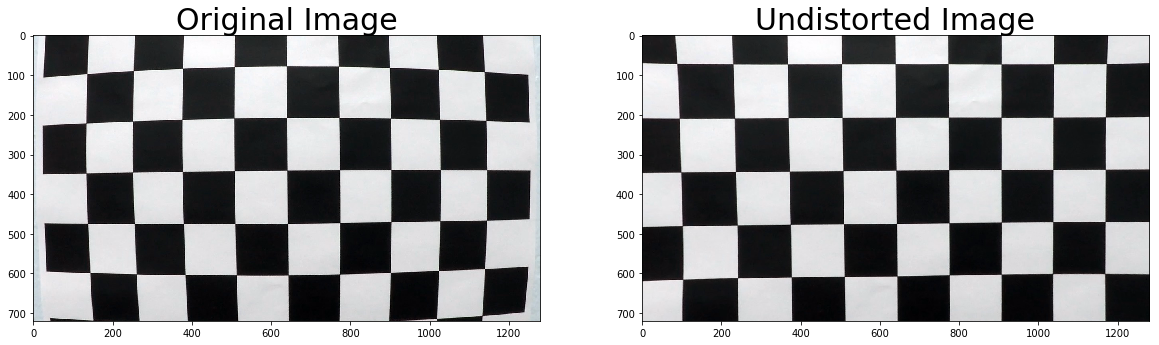

In [10]:
import pickle

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calib_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Pipeline

The following cell includes various steps/methods used in the eventual pipeline.

test4.jpg


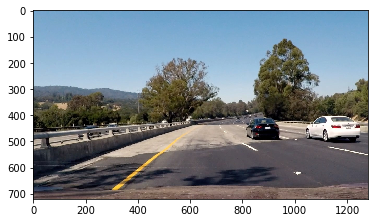

In [91]:
# Sample image for testing various steps of the pipeline

# sample_img = cv2.imread('test_images/straight_lines1.jpg')
sample_img = cv2.imread('test_images/test4.jpg')
# sample_img = cv2.imread('test_images/test2.jpg')
# sample_img = cv2.imread('vid_frame_10/frame0.jpg')
# sample_img = cv2.imread('fram_22/frame2.jpg')
sample_img  = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
print('test4.jpg')
plt.imshow(sample_img)

In [12]:
# undistort the images passed to this function using the computed matrix (mtx) and 
# return the image
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

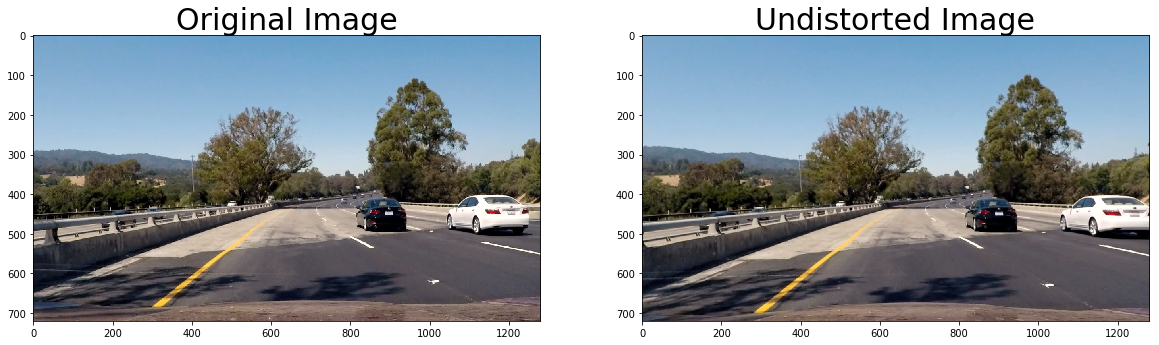

In [89]:
# testing the undistort function on a sample image.
undistorted = undistort(sample_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)


In [90]:
# absolute sobel mask (gradient) applied on an image with threshold in x or y direction
def abs_sobel_thresh(img, orient='x', ksize = 3, thresh_min=0, thresh_max=255):
    sobel = None
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.absolute(sobel)    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return mask

# thresholding the overall magnitude of the gradient.
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    factor = np.max(grad_mag)/255
    grad_mag = np.uint8(grad_mag/factor)
    mask = np.zeros_like(grad_mag)
    mask[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    return mask

# thresholding the direction of the gradient.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)    
    abs_sobely = np.absolute(sobely)
    dir = np.arctan2(abs_sobely, abs_sobelx)
    mask = np.zeros_like(dir)
    mask[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return mask

# apply color mask thresholding to image
def color_threshold(img, thresh=(0, 255)):
    binary = np.zeros_like(img)
    binary[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary


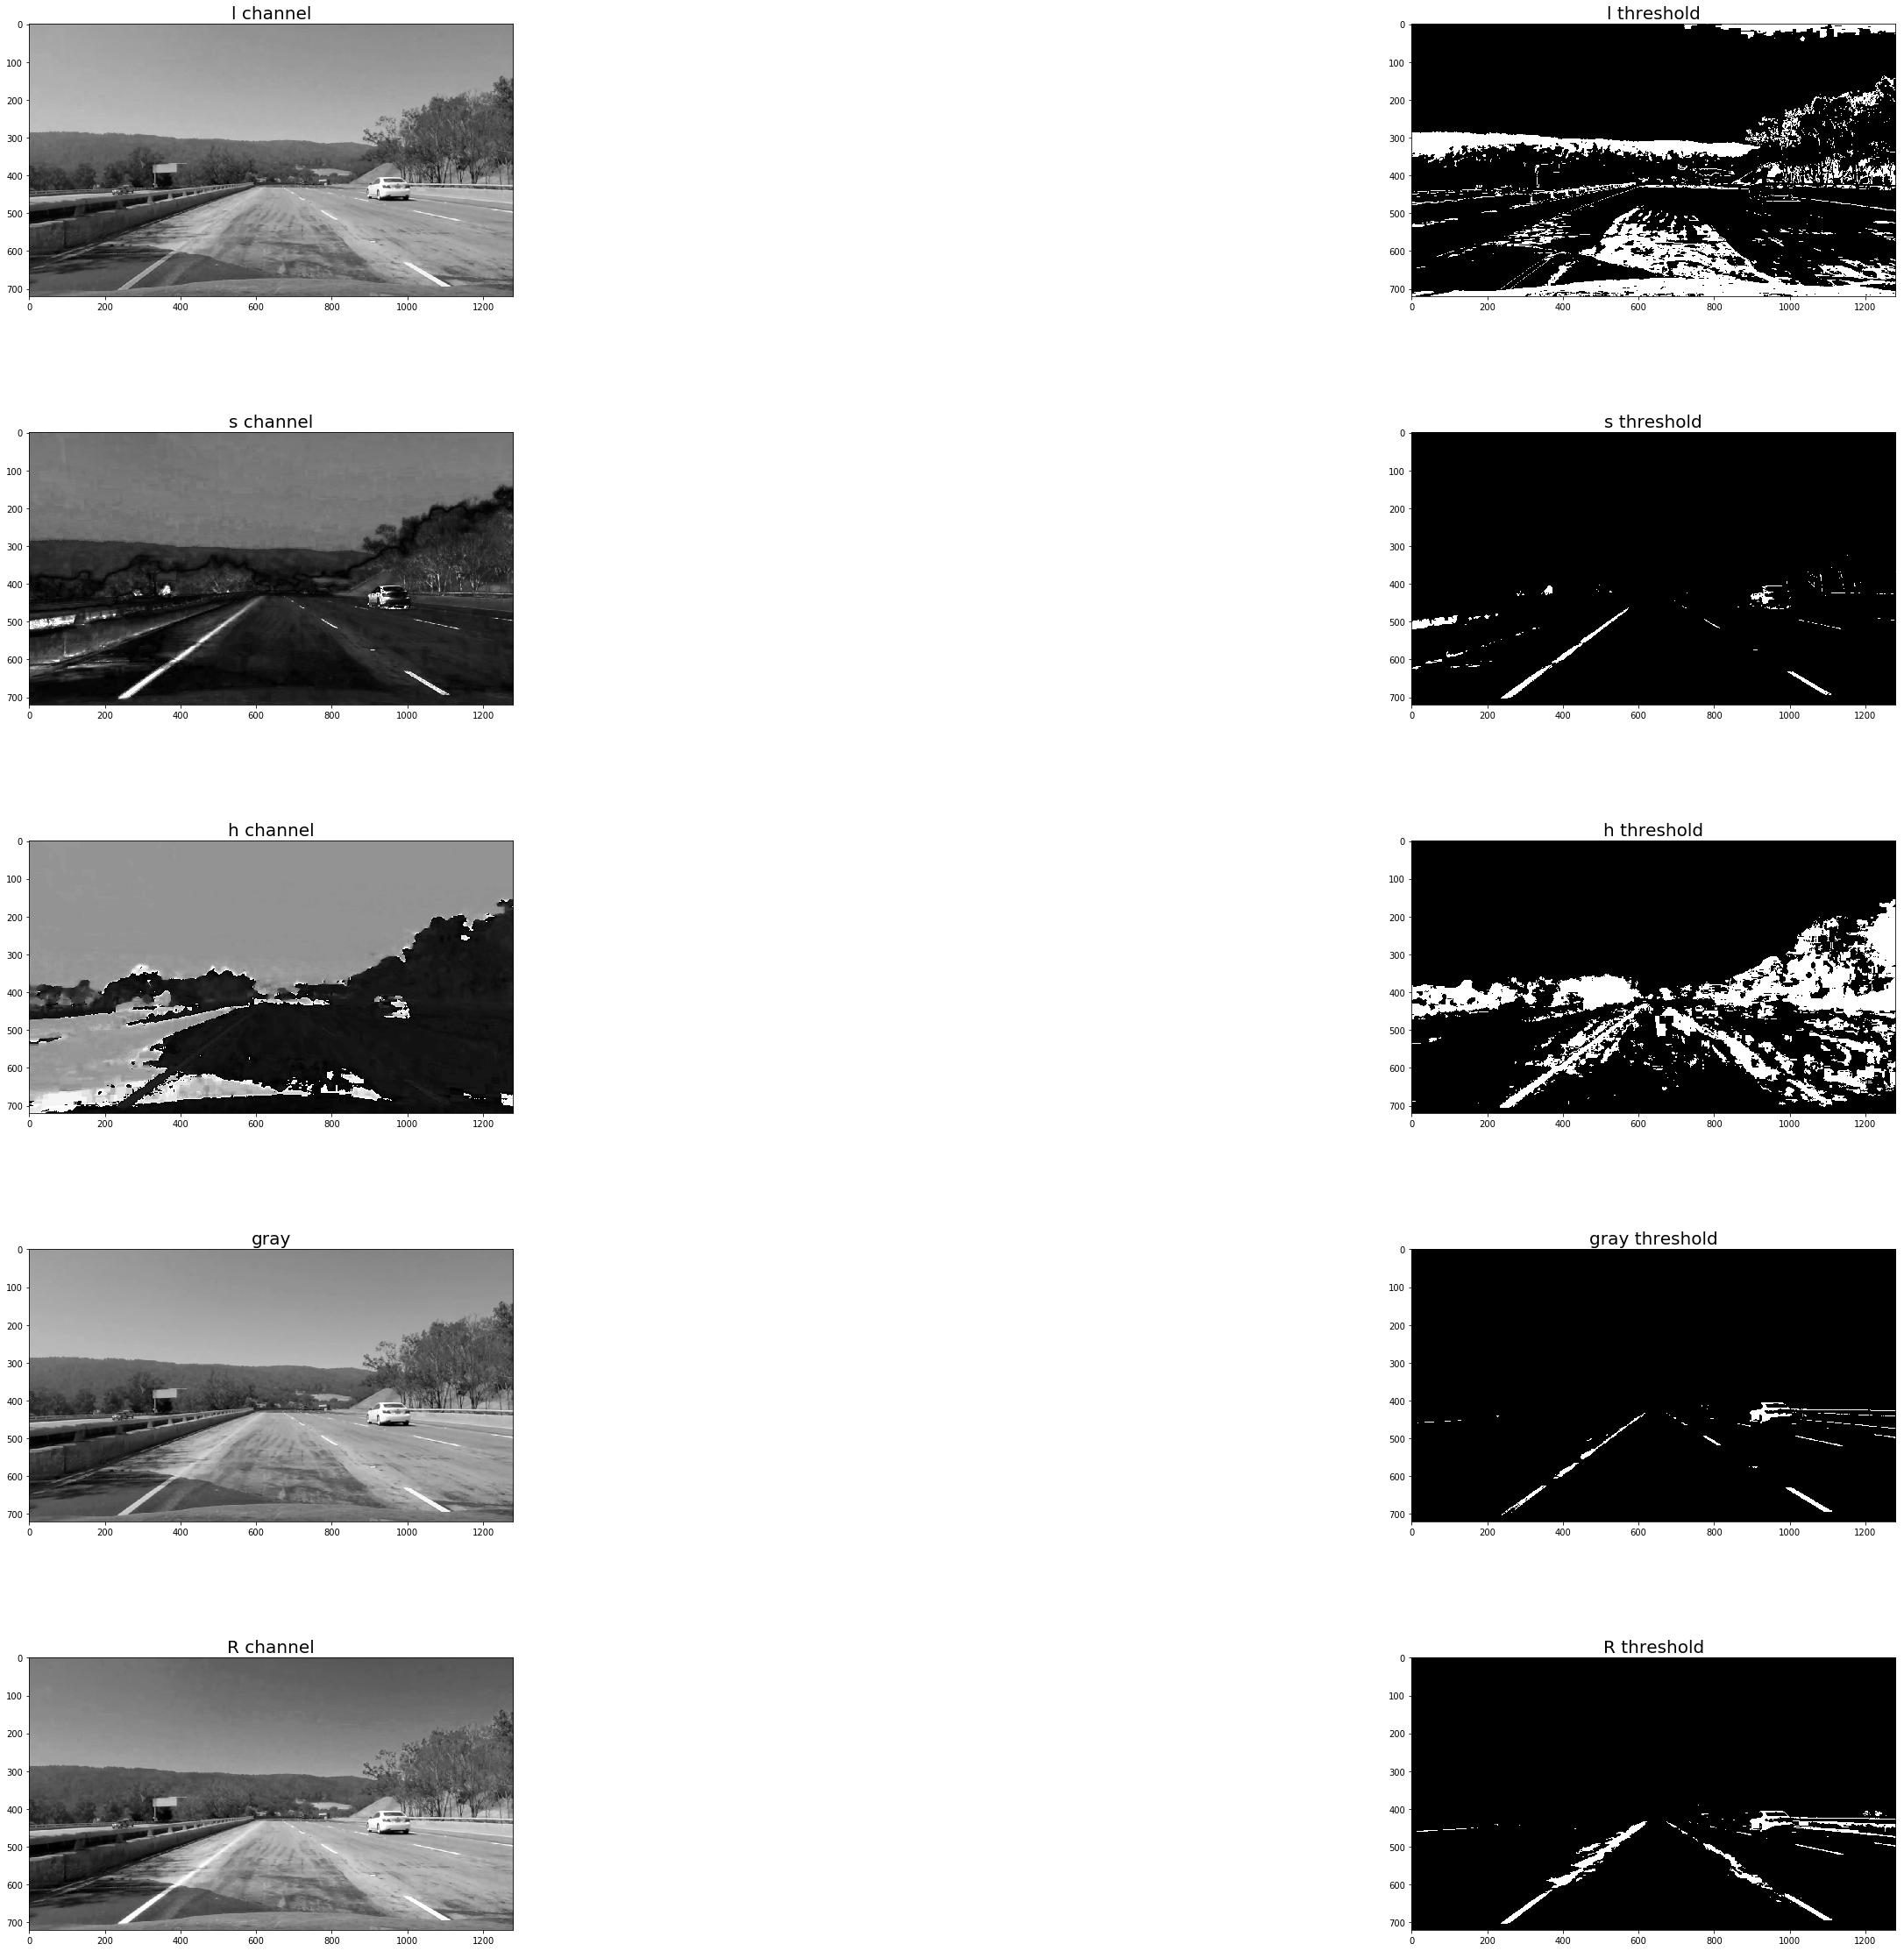

In [15]:
# Random testing of images with various color thresholds (H, L, S, Gray & R)

hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
h_thresh = color_threshold(h_channel, (15, 70))
l_thresh = color_threshold(l_channel, (100, 140))
s_thresh = color_threshold(s_channel, (140, 255))
gray_thresh = color_threshold(gray, (200,255))
r = undistorted[:,:,0]
r_thresh = color_threshold(r, (200, 255))

f, axs = plt.subplots(5, 2, figsize=(50,40))
f.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()
axs[0].imshow(l_channel, cmap='gray')
axs[0].set_title('l channel', fontsize=20)
axs[1].imshow(l_thresh, cmap='gray')
axs[1].set_title('l threshold', fontsize=20)

axs[2].imshow(s_channel, cmap='gray')
axs[2].set_title('s channel', fontsize=20)
axs[3].imshow(s_thresh, cmap='gray')
axs[3].set_title('s threshold', fontsize=20)

axs[4].imshow(h_channel, cmap='gray')
axs[4].set_title('h channel', fontsize=20)
axs[5].imshow(h_thresh, cmap='gray')
axs[5].set_title('h threshold', fontsize=20)

axs[6].imshow(gray, cmap='gray')
axs[6].set_title('gray', fontsize=20)
axs[7].imshow(gray_thresh, cmap='gray')
axs[7].set_title('gray threshold', fontsize=20)

axs[8].imshow(r, cmap='gray')
axs[8].set_title('R channel', fontsize=20)
axs[9].imshow(r_thresh, cmap='gray')
axs[9].set_title('R threshold', fontsize=20)



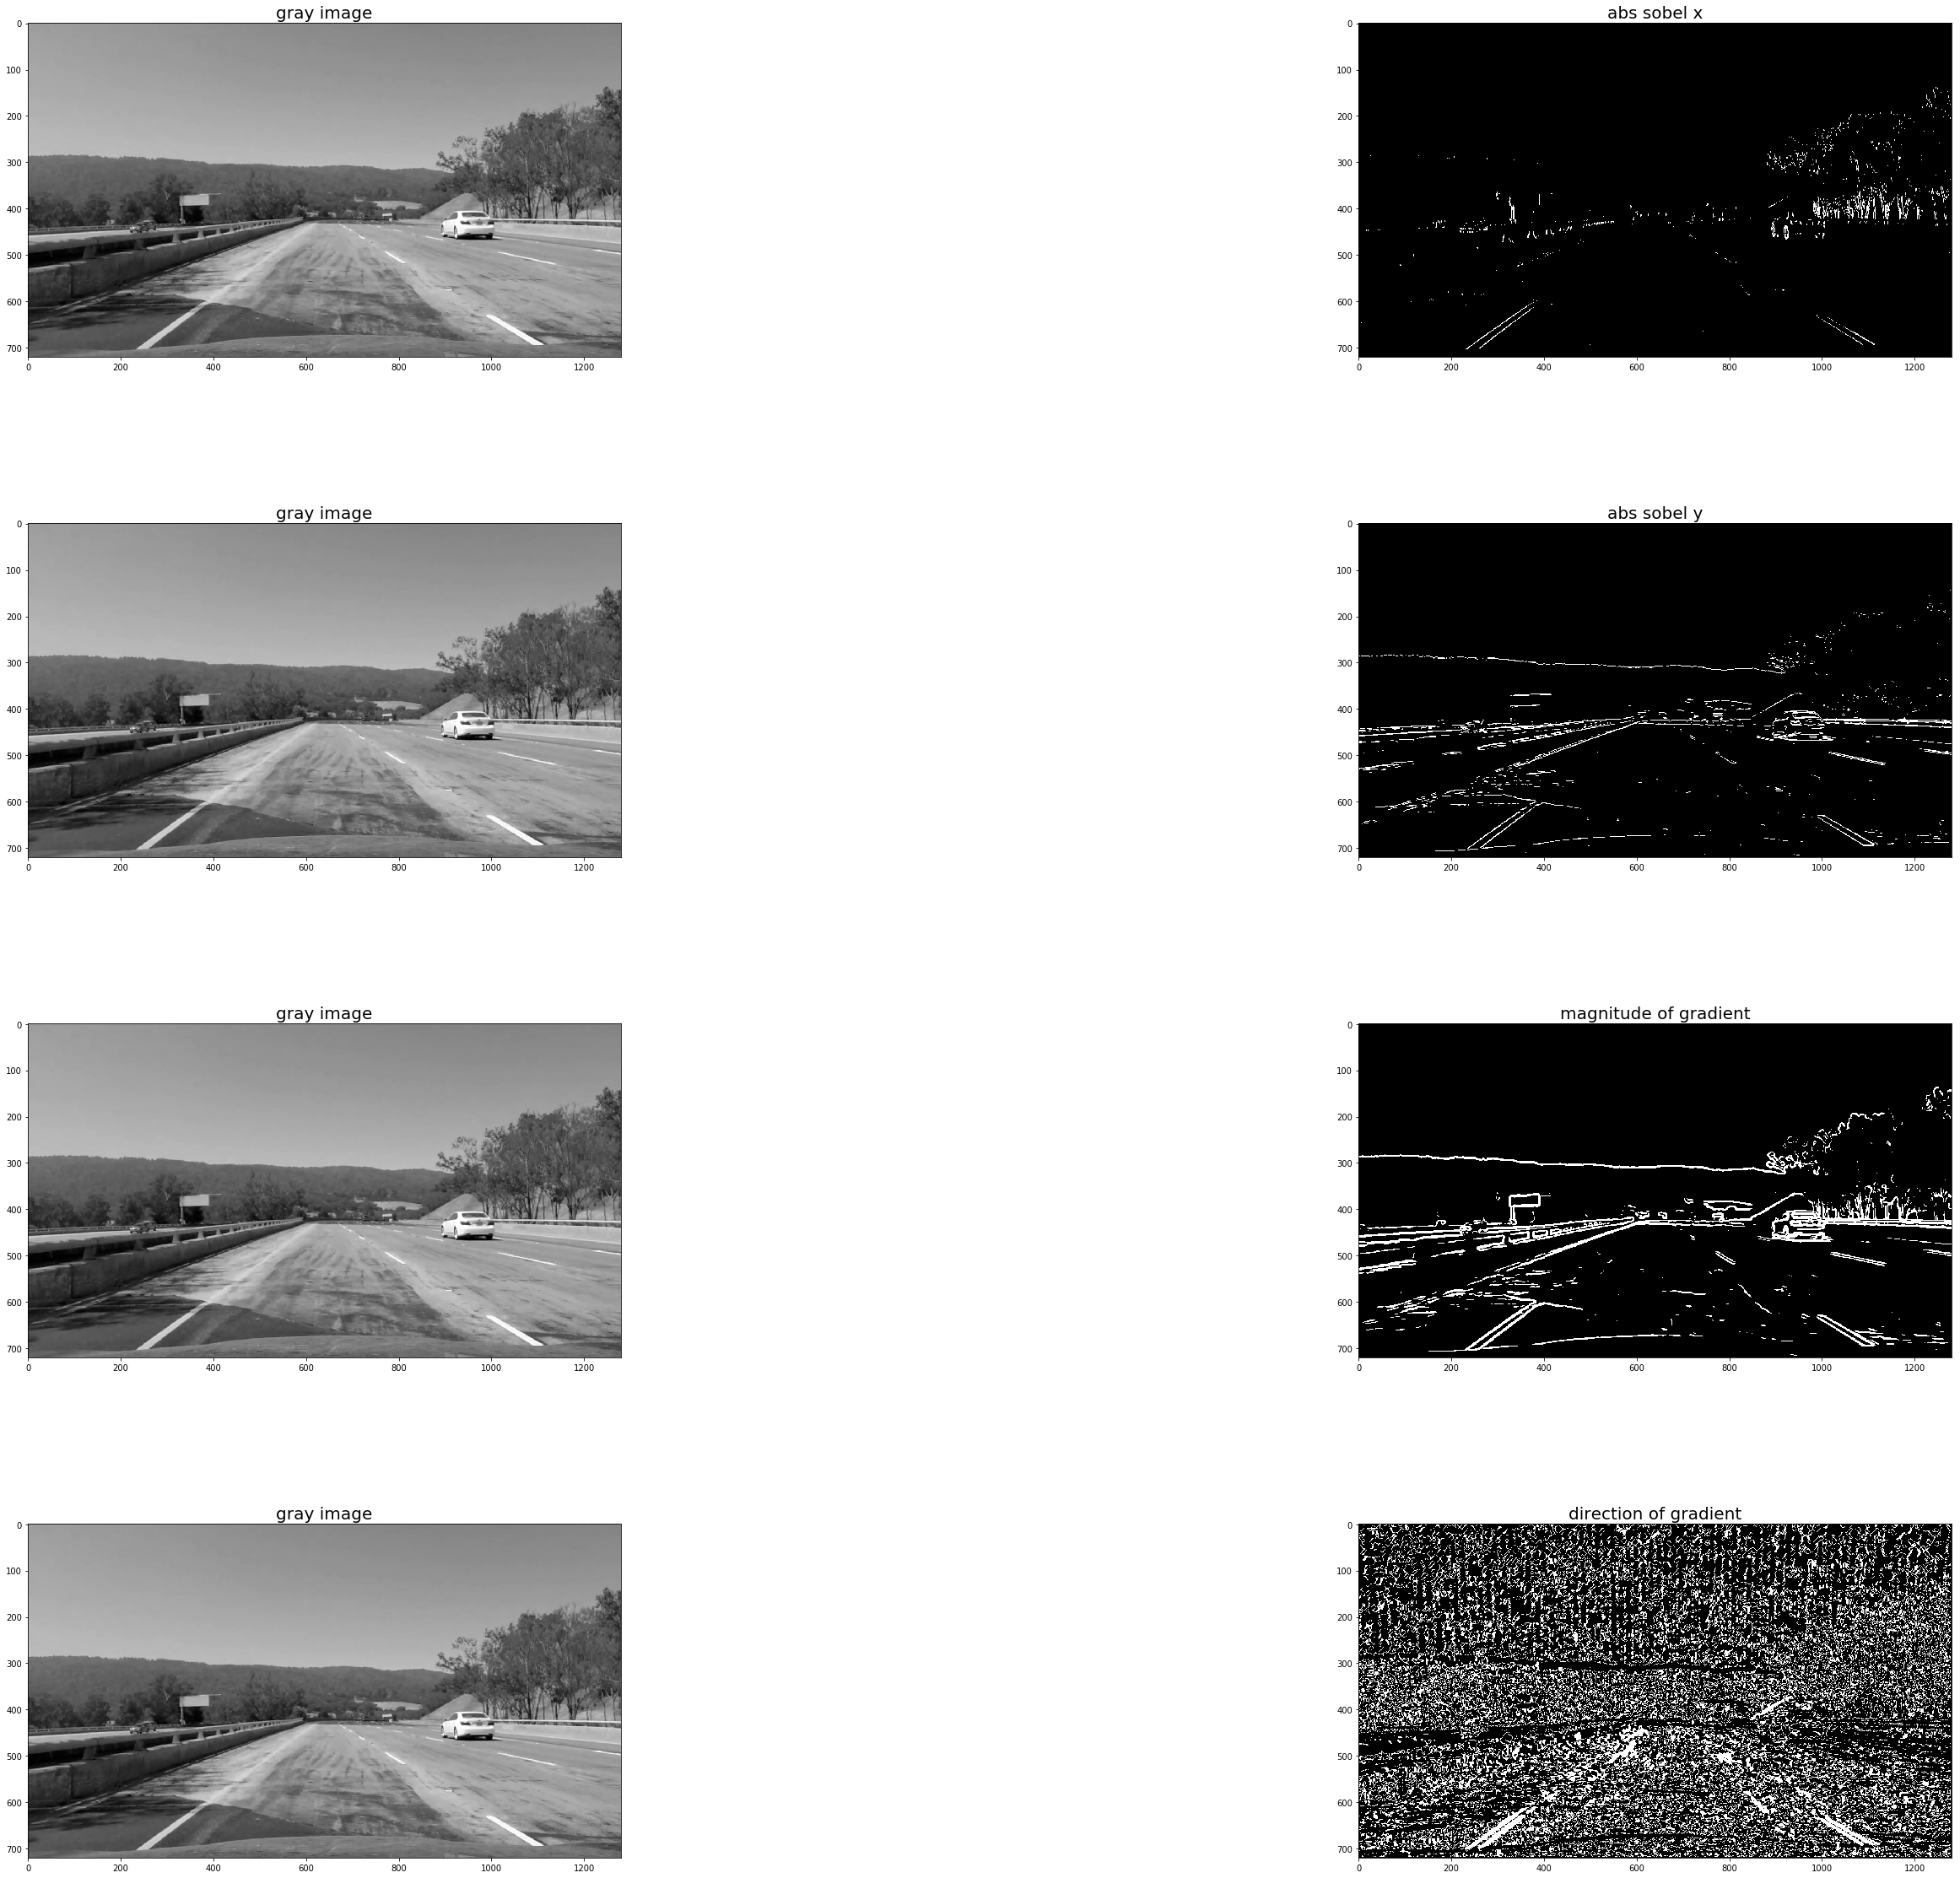

In [95]:
# test sobel, magnitude & direction gradients on images

abs_sobel_x = abs_sobel_thresh(gray, ksize=15, thresh_min=50 , thresh_max=255)
abs_sobel_y = abs_sobel_thresh(gray, 'y', ksize=15, thresh_min=50 , thresh_max=255)
mag_thresh = mag_threshold(gray, sobel_kernel=15, mag_thresh=(50,255))
dir_thresh = dir_threshold(gray, sobel_kernel=15, thresh=(0.7,1.2))

f, axs = plt.subplots(4, 2, figsize=(50,40))
axs = axs.ravel()
f.subplots_adjust(hspace = .5, wspace=.3)
axs[0].imshow(gray, cmap='gray')
axs[0].set_title('gray image', fontsize=20)
axs[1].imshow(abs_sobel_x, cmap='gray')
axs[1].set_title('abs sobel x', fontsize=20)
axs[2].imshow(gray, cmap='gray')
axs[2].set_title('gray image', fontsize=20)
axs[3].imshow(abs_sobel_y, cmap='gray')
axs[3].set_title('abs sobel y', fontsize=20)
axs[4].imshow(gray, cmap='gray')
axs[4].set_title('gray image', fontsize=20)
axs[5].imshow(mag_thresh, cmap='gray')
axs[5].set_title('magnitude of gradient', fontsize=20)
axs[6].imshow(gray, cmap='gray')
axs[6].set_title('gray image', fontsize=20)
axs[7].imshow(dir_thresh, cmap='gray')
axs[7].set_title('direction of gradient', fontsize=20)


#### 2. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called 'warp_image',
The `warp_image()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I have hardcoded the source and destination points based on trial and error for now.
The function and its sample use (with example images) is in the 2 code cells below.
I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.
    
    
    
    

In [99]:
# perspective transform  - warp image (birds view)
def warp_image(img, src, dst):
    h,w = img.shape[:2]
    # src image matrix
    src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    
    # destination image matrix
    dst = np.float32([(450,0),
                      (w-450,0),
                      (450,h),
                      (w-450,h)])

    img_size = (img.shape[1], img.shape[0])
    # compute transformation matrix.
    M = cv2.getPerspectiveTransform(src, dst)
    # inverse transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    # get warped image using matrix M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped, M, Minv

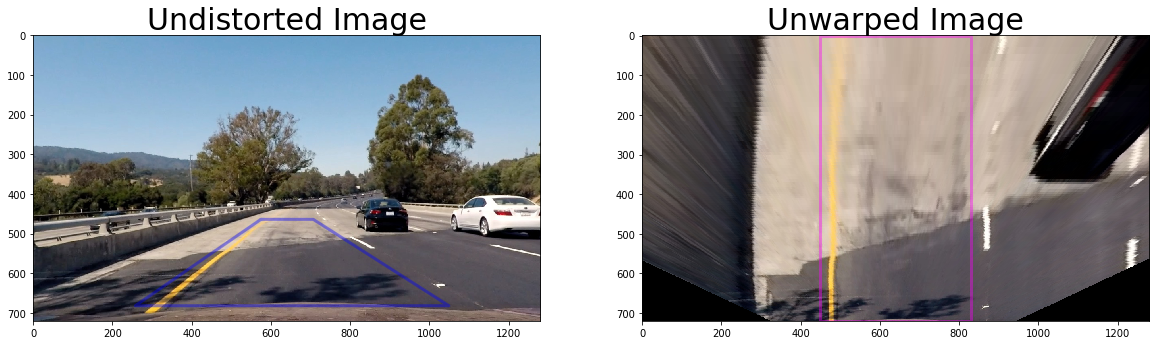

In [100]:
# testing warp perspective on an undistorted sample image.

h,w = sample_img.shape[:2]

# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

sampleImg_warp, M_, Minv_ = warp_image(undistorted, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=30)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
x1 = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y1 = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]

ax1.plot(x, y, color='#0000FF', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

ax2.plot(x1, y1, color='#FF00FF', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax2.imshow(sampleImg_warp)
ax2.set_title('Unwarped Image', fontsize=30)

#### 3. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

The pipeline takes in an image. The next step is to undistort the image. Then I apply a combination of the following color thresholds: Saturation, Red.
I also apply a combination of absolute sobel gradient in X and Y direction, magnitude & direction gradients to the image to get the final detected image. Saturation threshold helps detect yellow lines very clearly. The R channel picks up the white lines pretty well. The color channels with the direction, magnitude & abs gradient in X & Y direction helps filter out the shadows (and other noise), putting thefocus on the lane pixels.
The pipeline steps are defined in the code cell below in the method 'pipeline()'. The cell after that shows the sample test images after the pipeline has been applied.

In [115]:
# The processing pipeline that every video frame will go through
def pipeline(img):
    # undistort the image
    undistorted_img = undistort(img)
    
    # Perspective Transform
    img_warped, M, Minv = warp_image(undistorted_img, src, dst)
    
    # get hls version of the image.    
    hls = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HLS)
    # get gray scaled version of the image.
    gray = cv2.cvtColor(img_warped, cv2.COLOR_RGB2GRAY)
    # r-channel
    r = img_warped[:,:,0]
    # l-channel thresholed
    l_thresh = color_threshold(hls[:,:,1], (30,100))
    # h-channel thresholded
    h_thresh = color_threshold(hls[:,:,0], (15,70))
    # s- channel thresholded
    s_thresh = color_threshold(hls[:,:,2], (160,255))
    # gray-thresholded
    gray_thresh = color_threshold(gray, (200,255))
    # r-channel thresholded
    r_thresh = color_threshold(r, (200, 255))
    
#     lab = cv2.cvtColor(img_warped, cv2.COLOR_RGB2Lab)
#     b_lbthresh = color_threshold(lab[:,:,2], (190,255))

    # gradient direction thresholded
    dir_thresh = dir_threshold(img_warped, sobel_kernel=15, thresh=(0.7,1.2))
    # abs sobel in x direction
    abs_sobel_x = abs_sobel_thresh(gray, ksize=15, thresh_min=50 , thresh_max=255)
    # abs sobel in y direction
    abs_sobel_y = abs_sobel_thresh(gray, 'y', ksize=15, thresh_min=50 , thresh_max=255)
    # magnitude of the gradient thresholded
    mag_thresh = mag_threshold(gray, sobel_kernel=15, mag_thresh=(50,255))
    # combined mask on the gray_thresholed image
    combined_binary = np.zeros_like(gray_thresh)
    # combined filters on the combined image
    combined_binary[((s_thresh == 1) & (r_thresh == 1))|((abs_sobel_x == 1) & (abs_sobel_y == 1))|((dir_thresh == 1) & (mag_thresh == 1))] = 1
    # returns the combined binary image & the perspective  tranform matrices.
    return combined_binary, M, Minv


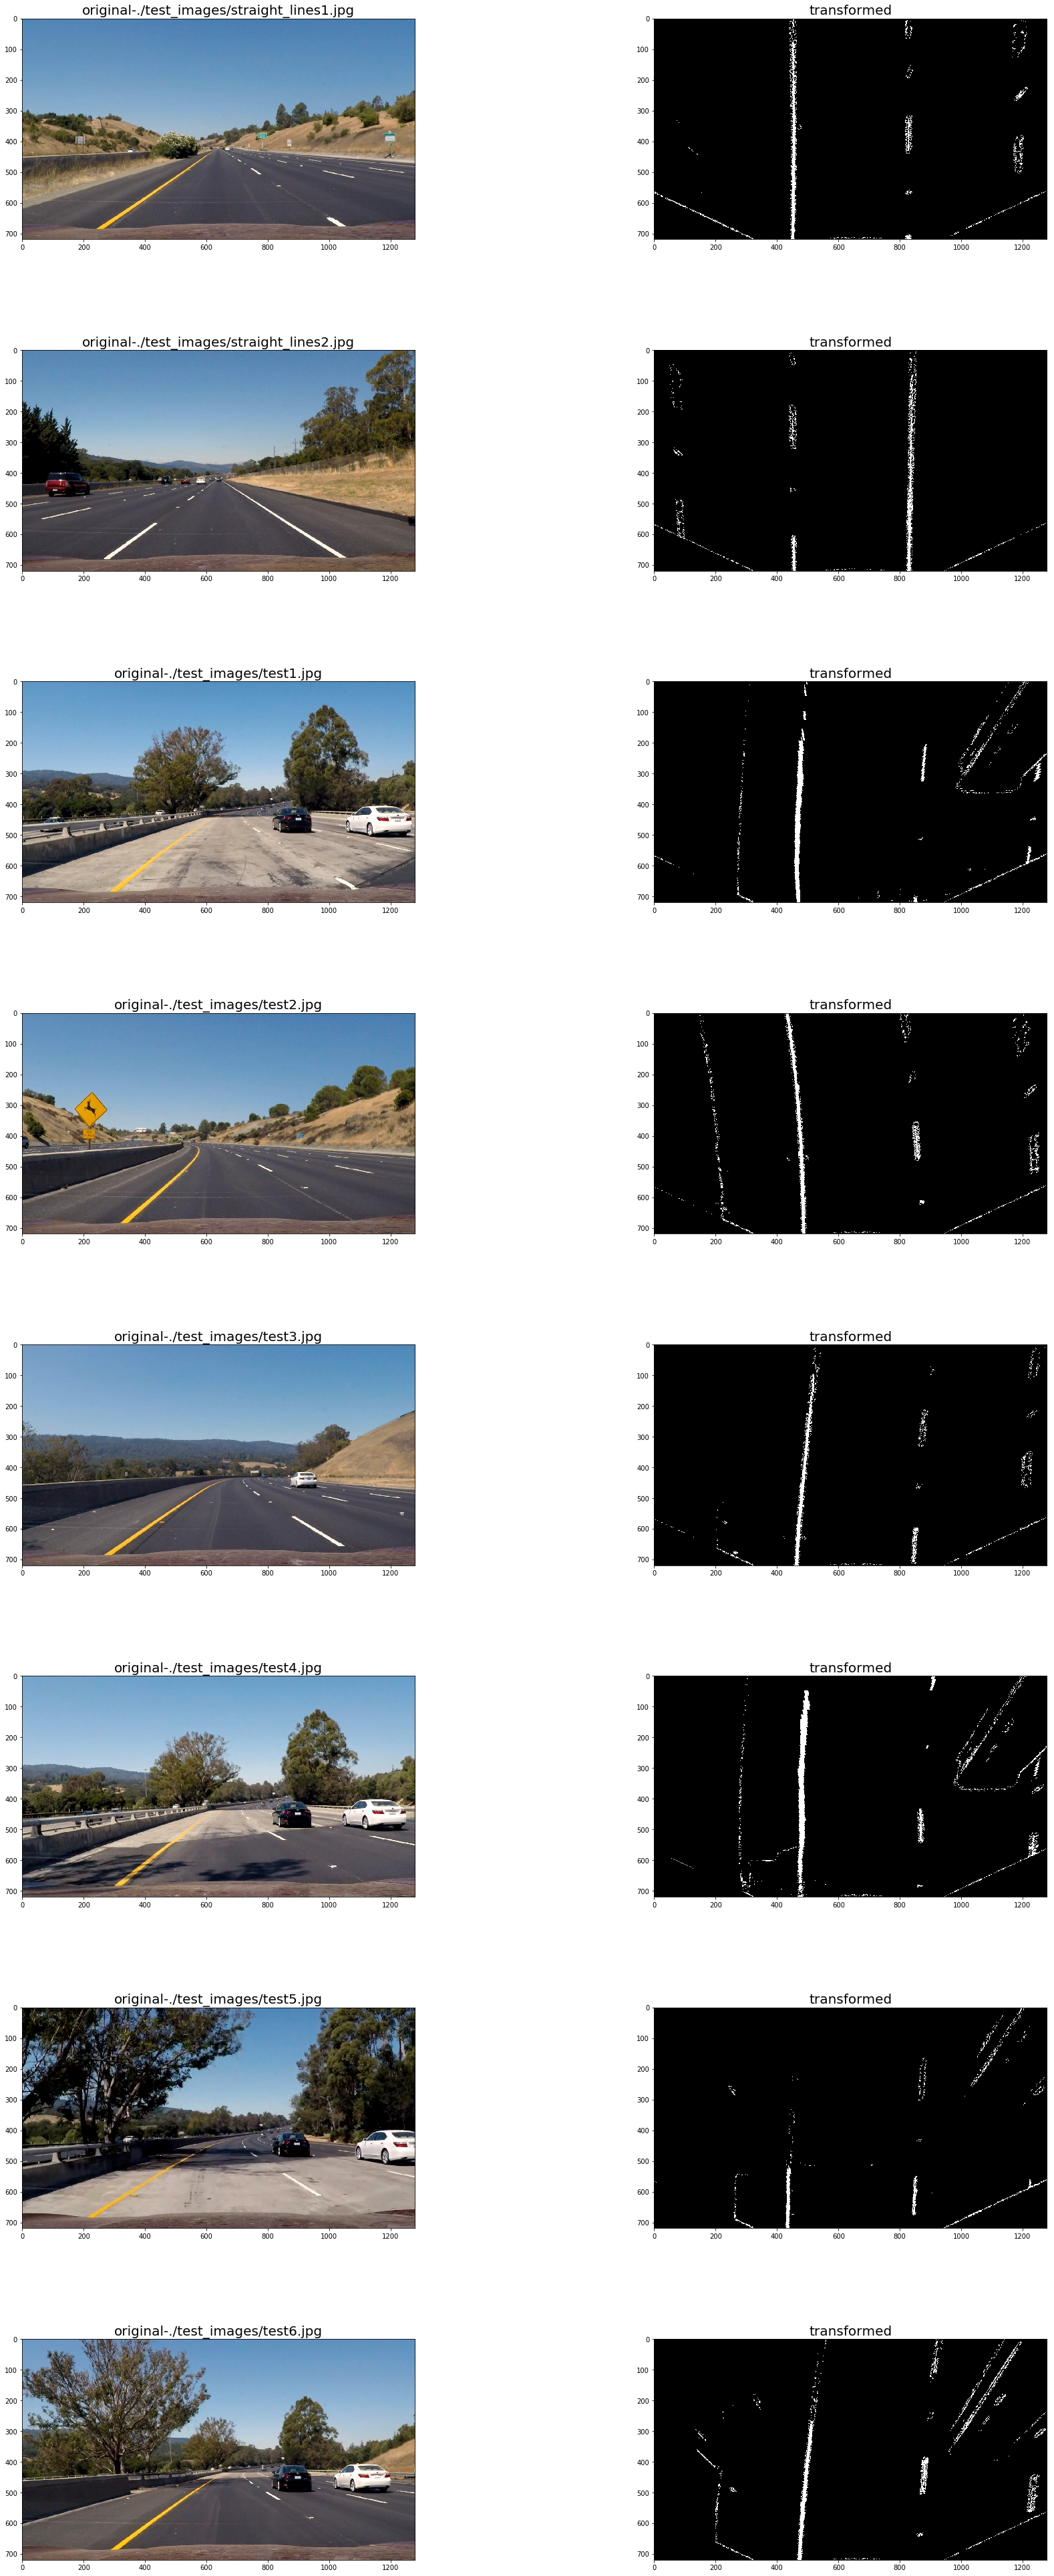

In [124]:
images = glob.glob('./test_images/*.jpg') 
# images = glob.glob('./vid_frames/*.jpg')
# images = glob.glob('./vid_frame_10/*.jpg')
# images = glob.glob('./frame_41/*.jpg')
# images = glob.glob('./fram_22/*.jpg')

size = len(images)
f, axs = plt.subplots(size, 2, figsize=(30,70))
f.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_processed, M_, Minv_ = pipeline(img)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title('original-'+image, fontsize=20)
    i += 1
    axs[i].imshow(img_processed, cmap='gray')
    axs[i].set_title('transformed', fontsize=20)
    i += 1

In [127]:
# plot a histogram of the image to see the peaks. This is used 
def show_hist(img_processed):
    histogram = np.sum(img_processed[img_processed.shape[0]//2:,:], axis=0)
    plt.figure()
    plt.plot(histogram)


#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?
We take the histogram of a given frame of an image. And find the 2 largest peaks in an image in a given search area around the center of the image(from the first quarter of the image to last quarter of the image). We then use this to find the max value of the histogram peaks that represent the left and right line base start point. Now we use a sliding window approach to build windows around lane centers to detect lane points all the way to the top of the frame. We do this for 10 windows. The function is in the code cell below.
In the next frame of video we don't need to do a blind search again, but instead we search in a margin around the previous line position as described by the method 'polyfit_from_prev_frame()' in a code cell below.
Visualize methods for each of the approaches are also present to test them along with the results on sample images.

In [134]:
# sliding window approach to identify lane line pixels from a given frame.
def sliding_window_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    index = int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[index:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    start_quarter_mark = np.int(midpoint/2)
    end_quarter_mark = np.int(midpoint + start_quarter_mark)
    leftx_base = np.argmax(histogram[start_quarter_mark:midpoint]) + start_quarter_mark
    rightx_base = np.argmax(histogram[midpoint:end_quarter_mark]) + midpoint
    print(leftx_base, rightx_base, midpoint)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

MARGIN = 80
# determine lane pixels from a previously detected lane line fit. (Used by subsequent frames to speed up the detection)
def polyfit_from_prev_frame(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    # get non zero components of image.
    nonzero = binary_warped.nonzero()
    # extract x & y non zero components
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - MARGIN)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + MARGIN))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - MARGIN)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + MARGIN)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [132]:
# visualize the polynomial and coordinates identified by the sliding window fit method above.
def visualize_sliding_window(warped_img, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    

438 848 640


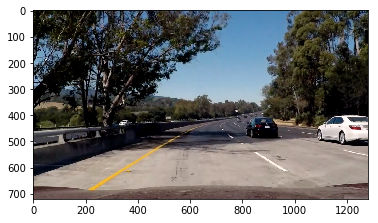

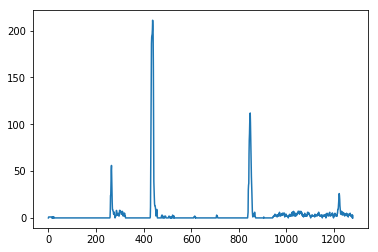

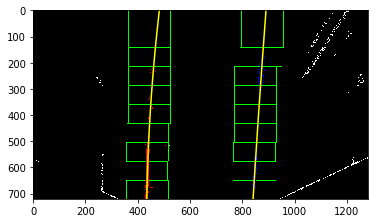

In [153]:
# sample_img = cv2.imread('test_images/straight_lines1.jpg')
sample_img = cv2.imread('test_images/test5.jpg')
# sample_img = cv2.imread('vid_frames/frame8.jpg')
# sample_img = cv2.imread('vid_frame_10/frame13.jpg')
# sample_img = cv2.imread('frame_41/frame7.jpg')
# sample_img = cv2.imread('fram_22/frame0.jpg')
sample_img  = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
img_processed, M_orig, Minv_orig = pipeline(sample_img)
plt.imshow(sample_img)
show_hist(img_processed)
left_fit_orig, right_fit_orig, left_lane_inds, right_lane_inds, out_img = sliding_window_fit(img_processed)
visualize_sliding_window(img_processed, left_fit_orig, right_fit_orig, left_lane_inds, right_lane_inds, out_img)


In [143]:
# visualize the lane line for a given frame from the detection method that uses the previous lane line info.
def visualize_sliding_window_prev_frame(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # get non zero components of image.
    nonzero = binary_warped.nonzero()
    # extract x & y non zero components
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-MARGIN, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+MARGIN, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-MARGIN, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+MARGIN, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.figure()
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

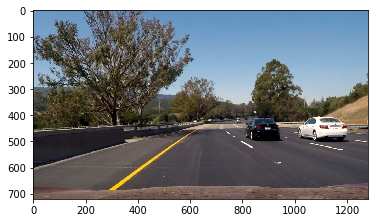

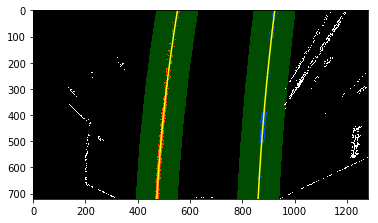

In [154]:
# testing sliding_window_lane_detetection using previous frame info.
# sample_img_next_frame = cv2.imread('test_images/straight_lines2.jpg')
# sample_img_next_frame = cv2.imread('vid_frame_10/frame.jpg')
# sample_img_next_frame = cv2.imread('frame_41/frame1.jpg')
sample_img_next_frame = cv2.imread('test_images/test6.jpg')
sample_img_next_frame  = cv2.cvtColor(sample_img_next_frame, cv2.COLOR_BGR2RGB)
img_processed_next_frame, M_prev, Minv_prev = pipeline(sample_img_next_frame)
plt.imshow(sample_img_next_frame)
left_fit_next_frame, right_fit_next_frame, left_lane_inds, right_lane_inds = polyfit_from_prev_frame(img_processed_next_frame, left_fit_orig, right_fit_orig)
visualize_sliding_window_prev_frame(img_processed_next_frame, left_fit_next_frame, right_fit_next_frame, left_lane_inds, right_lane_inds)


#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
I computed the radius of curvature based on the [following article](http://www.intmath.com/applications-differentiation/8-radius-curvature.php).
'y_eval' used in the formula is the position within the image upon which the curvature calculation is based (the bottom-most-y-the position of the car in the image)
The left and right curver radius computed is in pixel space, so we calculate new coefficients for the real world space by multiplying the coefficients by the conversion factor(ym_per_pix, xm_per_pix).

The position of the vehicle with respect to the center is computed by first taking the mean of the x & y intercepts at the base of the image and subtracting that from the car position (where camera is mounted - center of the base of the image). This is the distance of the car from the center.
The function is in the code cell below.





In [172]:
# computing the radius of curvature
def line_curvature(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print('in pixels', left_curverad, right_curverad)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - MARGIN)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + MARGIN))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - MARGIN)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + MARGIN)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

#     print((ploty*ym_per_pix).shape, len(ploty*ym_per_pix))
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # position of the car.
    car_position = binary_warped.shape[1]/2
    img_h = binary_warped.shape[0]
    l_xintercept = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    r_xintercept = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    center = (car_position - ((l_xintercept + r_xintercept)/2)) * xm_per_pix
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm', 'center-offset:', center)
    return left_curverad, right_curverad, center

In [173]:
# sample invocation of the method.
l_rad, r_rad, center = line_curvature(img_processed, left_fit_orig, right_fit_orig)

in pixels 7435.78845716 50510.0275527
2751.95715922 m 16498.1607939 m center-offset: 0.0113418203031


In [156]:
# Anotate the frame with the detected lines & enclosing area of the road as a polygon.
def draw_lines(image, warped, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result

# draw radius of curvature and deviation from center onto the image frame.
def draw_text(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,255, 0), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.2f}'.format(abs_center_dist) + 'm ' + direction + ' of the center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img


### Sample Image with lane annotated

array([[[ 47,  53,  75],
        [ 38,  44,  56],
        [ 33,  38,  41],
        ..., 
        [ 76,  94,  80],
        [102, 119, 103],
        [145, 159, 142]],

       [[ 40,  45,  64],
        [ 27,  34,  44],
        [ 19,  25,  23],
        ..., 
        [  9,  27,  15],
        [ 21,  38,  22],
        [ 90, 104,  89]],

       [[ 35,  41,  53],
        [ 23,  28,  32],
        [ 18,  23,  16],
        ..., 
        [ 19,  37,  25],
        [  7,  23,  10],
        [ 14,  28,  13]],

       ..., 
       [[ 31,  36,  40],
        [ 51,  50,  55],
        [ 97,  88,  91],
        ..., 
        [121, 106, 103],
        [121, 106, 103],
        [124, 109, 106]],

       [[ 42,  47,  51],
        [ 29,  30,  34],
        [ 66,  60,  64],
        ..., 
        [130, 115, 112],
        [131, 116, 113],
        [135, 120, 117]],

       [[ 47,  52,  58],
        [ 36,  37,  42],
        [ 37,  31,  35],
        ..., 
        [137, 122, 119],
        [138, 123, 120],
        [141, 126,

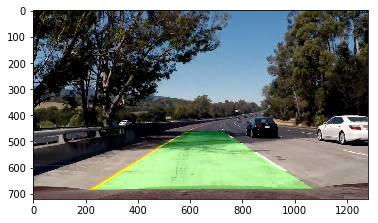

In [157]:
# sample image annotated.
draw_lines(sample_img, img_processed, left_fit_orig, right_fit_orig, Minv_orig)

The Line class is used to save the coefficient information for each detection like last fit, and the last 10 coefficient values. This can be used to average the current fit of the last 10 frames using the weights. This is useful for discarding incorrect of detections that may seem off the usual average values.

We have 'l_line' & 'r_line' for the left & right lines to keep track of this information for the left & right lane lines. We use 'diffs' array in the lines to identify difference from last best fit to ensure weird values are discarded.
We perform sanity check before adding any coefficient to the line class.

In [166]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # weights to normalize the average
        self.weights = np.arange(1,10+1)/10
    
    def set(self, fit):
        if fit is not None:
#             print("best fit", self.best_fit)
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
#             print('diffs', self.diffs)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.):
                self.detected = True
            else:    
                self.detected = True
                self.best_fit = fit
                self.current_fit.append(fit)
                if len(self.current_fit) > 10:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-10:]
        else:
            self.detected = False
     
    def average_fit(self):
        return np.average(self.current_fit, 0, self.weights[-len(self.current_fit):])
                
def process_image(img):
    img_copy = np.copy(img)
    img_processed, M, Minv = pipeline(img)
#     plt.figure()
#     plt.imshow(img_processed)
#     plt.figure()
#     show_hist(img_processed)
#     histogram = np.sum(img_processed[img_processed.shape[0]//2:,:], axis=0)
#     plt.plot(histogram)
    if l_line.detected or not r_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = sliding_window_fit(img_processed)
    else:
        avg_l = l_line.average_fit()
        avg_r = r_line.avergae_fit()  
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_from_prev_frame(img_processed, avg_l, avg_r)
   
    # finding x-intercept for sanity check
    y_val = img.shape[0]
    avg_width = 350
    w_margin = 100 # error tolerance in the width
    if left_fit is not None and right_fit is not None:
        left_fit_x = left_fit[0]*y_val**2 + left_fit[1]*y_val + left_fit[2]
        right_fit_x = right_fit[0]*y_val**2 + right_fit[1]*y_val + right_fit[2]
        x_diff = np.abs(left_fit_x - right_fit_x)
        diff = np.abs(avg_width - x_diff)
#         print('diff, ', diff)
        if diff > w_margin:
            left_fit = None
            right_fit = None

    l_line.set(left_fit)
    r_line.set(right_fit)    
    
    final_output_img = None
    avg_l_best = l_line.average_fit()
    avg_r_best = r_line.average_fit()
    if avg_l_best is not None and avg_r_best is not None:
#         print(l_line.current_fit)
#         print(weights)
        l_rad, r_rad, dcenter = line_curvature(img_processed, avg_l_best, avg_r_best)
#         print(l_line.best_fit, r_line.best_fit)
        output_img = draw_lines(img, img_processed, avg_l_best, avg_r_best, Minv)
        final_output_img = draw_text(output_img, ((l_rad +  r_rad)/2), dcenter)
#         plt.figure()
#         plt.imshow(output_img)
    else:
        final_output_img = img_copy
        
    return final_output_img    
        

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

The code below runs the pipeline on each frame of the video and finally generates a video with the lane annotated.
Here's a [link to the final video.](https://youtu.be/YHl2jC9uCDE)

480 864 640
in pixels 5078.84888248 7338.08406441
1668.15084846 m 18368.6525413 m
[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


  0%|          | 1/1261 [00:00<07:28,  2.81it/s]

480 864 640
in pixels 5078.84888248 7338.08406441
1668.15084846 m 18368.6525413 m


  0%|          | 2/1261 [00:00<07:49,  2.68it/s]

480 862 640
in pixels 4924.98238945 6202.17929988
1538.32058534 m 2235.53140271 m


  0%|          | 3/1261 [00:01<08:06,  2.58it/s]

479 864 640
in pixels 4812.13026515 6689.73375398
1499.32355397 m 3232.79421445 m


  0%|          | 4/1261 [00:01<09:39,  2.17it/s]

480 864 640
in pixels 4673.79263946 6524.5809056
1416.03173053 m 2104.04561762 m


  0%|          | 5/1261 [00:02<09:49,  2.13it/s]

480 866 640
in pixels 4593.73520122 6255.63259849
1430.51197043 m 1881.0836794 m


  0%|          | 6/1261 [00:02<09:17,  2.25it/s]

481 867 640
in pixels 4536.78742802 5574.67904646
1432.66371868 m 1299.81997523 m


  1%|          | 7/1261 [00:03<09:15,  2.26it/s]

482 851 640
in pixels 4495.66906962 5131.67013632
1438.60314558 m 1314.0768659 m


  1%|          | 8/1261 [00:03<09:01,  2.31it/s]

483 849 640
in pixels 4453.6900343 4943.98336594
1425.93919563 m 1927.51653189 m


  1%|          | 9/1261 [00:03<08:36,  2.42it/s]

483 853 640
in pixels 4437.33450892 5018.0810381
1462.61724886 m 2229.59360567 m


  1%|          | 10/1261 [00:04<08:14,  2.53it/s]

483 858 640
in pixels 4411.15947704 5181.01384463
1444.49707161 m 3080.63431926 m


  1%|          | 11/1261 [00:04<08:04,  2.58it/s]

483 857 640
in pixels 4403.47763289 5421.99475755
1458.07038379 m 3111.79732558 m


  1%|          | 12/1261 [00:05<07:57,  2.62it/s]

481 860 640
in pixels 4464.64384193 5822.35072384
1572.60533652 m 3437.75517829 m


  1%|          | 13/1261 [00:05<08:03,  2.58it/s]

482 859 640
in pixels 4565.95114586 6165.02643305
1656.82415559 m 22823.0146381 m


  1%|          | 14/1261 [00:05<08:08,  2.55it/s]

480 861 640
in pixels 4699.4795025 6832.50464064
1734.82856968 m 47156.6499503 m


  1%|          | 15/1261 [00:06<08:30,  2.44it/s]

482 860 640
in pixels 4870.72611832 7234.88781465
1843.31542785 m 4889.93710186 m


  1%|▏         | 16/1261 [00:06<08:48,  2.35it/s]

482 859 640
in pixels 5069.547757 8279.18082961
1933.19992096 m 6582.36400922 m


  1%|▏         | 17/1261 [00:07<09:13,  2.25it/s]

482 859 640
in pixels 5334.41854585 8866.64980489
2127.06326285 m 3681.53819079 m


  1%|▏         | 18/1261 [00:07<09:32,  2.17it/s]

482 858 640
in pixels 5636.86013747 8530.99605504
2256.3978316 m 2137.26573023 m


  2%|▏         | 19/1261 [00:08<09:37,  2.15it/s]

480 861 640
in pixels 5979.2111505 8646.79459411
2405.45329393 m 2813.9008606 m


  2%|▏         | 20/1261 [00:08<09:03,  2.28it/s]

480 839 640
in pixels 6370.09499828 8488.60960195
2582.83786966 m 2495.69761478 m


  2%|▏         | 21/1261 [00:08<08:43,  2.37it/s]

476 841 640
in pixels 6878.16625952 7496.88887197
2990.41547587 m 1617.2146885 m


  2%|▏         | 22/1261 [00:09<08:44,  2.36it/s]

476 845 640
in pixels 7427.70919806 6734.10604277
3192.84257189 m 1588.54400229 m


  2%|▏         | 23/1261 [00:09<08:42,  2.37it/s]

475 850 640
in pixels 7972.17989496 6480.54638679
3258.36242463 m 1994.60021314 m


  2%|▏         | 24/1261 [00:10<08:43,  2.36it/s]

475 850 640
in pixels 8313.26404587 6607.88629199
2901.96260485 m 2723.42655985 m


  2%|▏         | 25/1261 [00:10<08:52,  2.32it/s]

475 851 640
in pixels 8425.12814359 6219.74886331
2627.99947107 m 1714.69437124 m


  2%|▏         | 26/1261 [00:11<09:02,  2.27it/s]

469 856 640
in pixels 8484.19186349 6036.40733667
2650.82706631 m 1898.74045654 m


  2%|▏         | 27/1261 [00:11<09:01,  2.28it/s]

469 857 640
in pixels 8306.36666467 6170.23682106
2386.14319354 m 2398.82764775 m


  2%|▏         | 28/1261 [00:12<09:06,  2.26it/s]

468 859 640
in pixels 8220.378275 6309.67694321
2544.77645586 m 2341.07445136 m


  2%|▏         | 29/1261 [00:12<09:19,  2.20it/s]

468 860 640
in pixels 7881.12282852 6833.54571269
2201.44419308 m 3580.57197788 m


  2%|▏         | 30/1261 [00:12<09:20,  2.20it/s]

468 859 640
in pixels 7309.29511694 6695.93636686
1864.69685462 m 1903.87186968 m


  2%|▏         | 31/1261 [00:13<08:45,  2.34it/s]

471 860 640
in pixels 6696.95407081 6474.84881455
1682.74640965 m 1745.28885516 m


  3%|▎         | 32/1261 [00:13<09:42,  2.11it/s]

472 862 640
in pixels 6086.45536863 6327.78765382
1511.76153402 m 1840.14590456 m


  3%|▎         | 33/1261 [00:14<09:19,  2.19it/s]

471 851 640
in pixels 5671.29090911 5999.09836679
1544.84116438 m 1614.18950981 m


  3%|▎         | 34/1261 [00:14<09:32,  2.14it/s]

472 845 640
in pixels 5316.25252045 5876.74995133
1476.34030607 m 1835.85375455 m


  3%|▎         | 35/1261 [00:15<10:19,  1.98it/s]

473 848 640
in pixels 4995.31490281 5797.4223867
1396.59580354 m 1840.22355753 m


  3%|▎         | 36/1261 [00:15<09:32,  2.14it/s]

474 845 640
in pixels 4726.3658461 5761.27242491
1354.65563267 m 1927.04471121 m


  3%|▎         | 37/1261 [00:16<09:31,  2.14it/s]

475 849 640
in pixels 4494.71343823 5949.63214575
1304.93054411 m 2448.35170583 m


  3%|▎         | 38/1261 [00:16<09:44,  2.09it/s]

476 856 640
in pixels 4302.18228564 5603.97763555
1273.38736407 m 1488.14988741 m


  3%|▎         | 39/1261 [00:17<08:55,  2.28it/s]

476 851 640
in pixels 4116.34412775 5872.29976915
1199.50003814 m 2578.36538169 m


  3%|▎         | 40/1261 [00:17<08:19,  2.44it/s]

476 854 640
in pixels 3958.97410981 6242.91712525
1165.99152722 m 2735.11470213 m


  3%|▎         | 41/1261 [00:17<07:54,  2.57it/s]

477 857 640
in pixels 3843.02059764 6080.80178624
1168.78304321 m 1696.21367033 m


  3%|▎         | 42/1261 [00:18<07:32,  2.70it/s]

477 856 640
in pixels 3749.26094187 6074.34795876
1158.77908746 m 1913.63257659 m


  3%|▎         | 43/1261 [00:18<07:25,  2.74it/s]

478 857 640
in pixels 3678.15950898 5471.12523463
1162.30650051 m 1218.72118651 m


  3%|▎         | 44/1261 [00:18<07:11,  2.82it/s]

477 861 640
in pixels 3636.19922565 5260.34827835
1179.64605589 m 1516.72103544 m


  4%|▎         | 45/1261 [00:19<07:06,  2.85it/s]

477 850 640
in pixels 3619.21434614 5210.99119813
1199.4532648 m 1729.56883413 m


  4%|▎         | 46/1261 [00:19<06:57,  2.91it/s]

477 850 640
in pixels 3612.23329727 4947.00324664
1200.71669901 m 1384.88064014 m


  4%|▎         | 47/1261 [00:19<06:50,  2.96it/s]

477 850 640
in pixels 3631.00481983 4911.51374287
1235.45908281 m 1676.59505224 m


  4%|▍         | 48/1261 [00:20<06:51,  2.95it/s]

478 845 640
in pixels 3648.28593406 4922.51420416
1225.54513409 m 1713.67837 m


  4%|▍         | 49/1261 [00:20<06:50,  2.95it/s]

477 849 640
in pixels 3695.50560389 5089.07934947
1278.20321197 m 2120.84149602 m


  4%|▍         | 50/1261 [00:20<06:46,  2.98it/s]

477 853 640
in pixels 3769.64790714 5363.32556238
1338.80297686 m 2362.36356714 m


  4%|▍         | 51/1261 [00:21<06:46,  2.98it/s]

477 854 640
in pixels 3881.8372195 5258.20919864
1434.94998059 m 1518.3971126 m


  4%|▍         | 52/1261 [00:21<06:45,  2.98it/s]

478 855 640
in pixels 4005.79942298 5244.84120355
1479.20582142 m 1634.09736802 m


  4%|▍         | 53/1261 [00:21<06:39,  3.02it/s]

478 855 640
in pixels 4179.65606265 5596.14298772
1620.17155524 m 2420.09551809 m


  4%|▍         | 54/1261 [00:22<06:39,  3.02it/s]

478 857 640
in pixels 4378.61421598 5727.96056458
1709.99322263 m 1984.74350615 m


  4%|▍         | 55/1261 [00:22<06:37,  3.04it/s]

476 857 640
in pixels 4639.95988473 5985.30441992
1903.29079923 m 2317.87212877 m


  4%|▍         | 56/1261 [00:22<06:36,  3.04it/s]

477 857 640
in pixels 5001.71318896 5635.19864281
2226.21919659 m 1397.77184496 m


  5%|▍         | 57/1261 [00:23<06:39,  3.01it/s]

475 861 640
in pixels 5422.89578538 5287.24757599
2429.15924937 m 1358.03718337 m


  5%|▍         | 58/1261 [00:23<06:38,  3.02it/s]

477 836 640
in pixels 5938.88731831 5367.58559879
2751.19574075 m 1967.19741978 m


  5%|▍         | 59/1261 [00:23<07:17,  2.75it/s]

477 836 640
in pixels 6505.44791743 5351.41758245
2938.00021714 m 1791.85172121 m


  5%|▍         | 60/1261 [00:24<08:35,  2.33it/s]

475 837 640
in pixels 6972.05945226 5326.73598783
2710.97071255 m 1747.95691577 m


  5%|▍         | 61/1261 [00:24<08:21,  2.39it/s]

475 837 640
in pixels 7289.66510789 5430.79865546
2510.76581426 m 1951.06155103 m


  5%|▍         | 62/1261 [00:25<08:39,  2.31it/s]

475 842 640
in pixels 7410.41383776 5375.64611779
2296.70064998 m 1696.15203127 m


  5%|▍         | 63/1261 [00:25<08:27,  2.36it/s]

474 844 640
in pixels 7369.22886374 5347.14696587
2167.67475783 m 1749.88315011 m


  5%|▌         | 64/1261 [00:26<07:53,  2.53it/s]

473 846 640
in pixels 7125.8643004 5720.08280111
1958.92755204 m 2722.0993718 m


  5%|▌         | 65/1261 [00:26<07:52,  2.53it/s]

469 847 640
in pixels 6786.99473996 6267.18592644
1842.37406657 m 3316.10775033 m


  5%|▌         | 66/1261 [00:26<07:41,  2.59it/s]

472 849 640
in pixels 6386.24184464 6782.28665866
1718.37345719 m 2936.15252212 m


  5%|▌         | 67/1261 [00:27<07:25,  2.68it/s]

472 849 640
in pixels 6027.28178029 6806.07195973
1675.89756344 m 2013.71116761 m


  5%|▌         | 68/1261 [00:27<07:38,  2.60it/s]

468 849 640
in pixels 5653.79518701 6772.63615553
1556.11234271 m 2028.20784161 m


  5%|▌         | 69/1261 [00:28<08:40,  2.29it/s]

470 849 640
in pixels 5355.20598714 6832.23020622
1532.98520506 m 2183.1571435 m


  6%|▌         | 70/1261 [00:28<08:51,  2.24it/s]

468 826 640
in pixels 5100.70426437 7035.0647153
1482.26077867 m 2508.26482819 m


  6%|▌         | 71/1261 [00:28<08:28,  2.34it/s]

469 822 640
in pixels 4961.13744242 6750.5790735
1558.16312582 m 3795.95095287 m


  6%|▌         | 72/1261 [00:29<08:37,  2.30it/s]

468 831 640
in pixels 4929.09931911 7540.07148333
1684.64457383 m 5078.2493552 m


  6%|▌         | 73/1261 [00:29<08:23,  2.36it/s]

468 829 640
in pixels 4979.43310057 8824.61852622
1806.81956167 m 10625.8821566 m


  6%|▌         | 74/1261 [00:30<08:34,  2.31it/s]

468 834 640
in pixels 5146.90827289 9267.13248366
2039.41320678 m 3590.66238057 m


  6%|▌         | 75/1261 [00:30<08:46,  2.25it/s]

467 838 640
in pixels 5419.81357362 9270.37591931
2303.25128364 m 2784.02796153 m


  6%|▌         | 76/1261 [00:31<09:31,  2.07it/s]

468 839 640
in pixels 5845.7737478 8913.12475645
2760.80304822 m 2282.00001547 m


  6%|▌         | 77/1261 [00:31<09:17,  2.12it/s]

466 842 640
in pixels 6436.48211273 7977.75240313
3303.2611344 m 1680.96669932 m


  6%|▌         | 78/1261 [00:32<11:34,  1.70it/s]

466 844 640
in pixels 7213.40262726 7529.88014401
3939.53525514 m 1963.10569583 m


  6%|▋         | 79/1261 [00:33<11:17,  1.75it/s]

465 845 640
in pixels 8288.85217056 7589.09620541
5092.51710352 m 2707.69577359 m
465 845 640
in pixels 9612.49100656 7492.80685904
5766.54850968 m 2460.95738093 m


  6%|▋         | 81/1261 [00:34<11:19,  1.74it/s]

465 848 640
in pixels 10983.7458951 6814.589648
5448.97224138 m 1663.20281258 m


  7%|▋         | 82/1261 [00:34<10:39,  1.84it/s]

462 849 640
in pixels 12532.0911975 6329.04413498
6004.39933018 m 1747.06130421 m


  7%|▋         | 83/1261 [00:35<09:46,  2.01it/s]

456 833 640
in pixels 13712.1475768 6071.31797667
5080.96958153 m 1872.32731466 m


  7%|▋         | 84/1261 [00:35<09:44,  2.02it/s]

454 845 640
in pixels 14827.8510348 5854.35315787
5433.10513993 m 1759.88323263 m


  7%|▋         | 85/1261 [00:36<09:29,  2.07it/s]

454 841 640
in pixels 15160.9836104 5408.36526417
4535.56794047 m 1369.27164964 m


  7%|▋         | 86/1261 [00:36<09:59,  1.96it/s]

454 840 640
in pixels 14553.2677125 5294.21393768
3703.41380451 m 1669.51188605 m


  7%|▋         | 87/1261 [00:37<09:39,  2.02it/s]

459 839 640
in pixels 12890.2566232 5370.82578616
2755.36267002 m 1985.43751331 m


  7%|▋         | 88/1261 [00:37<08:57,  2.18it/s]

459 840 640
in pixels 11162.9893252 5375.78738438
2373.82743616 m 1862.53151421 m


  7%|▋         | 89/1261 [00:38<08:46,  2.23it/s]

459 839 640
in pixels 9432.89489957 5637.76980681
1954.32611261 m 2510.30472874 m


  7%|▋         | 90/1261 [00:38<08:16,  2.36it/s]

461 841 640
in pixels 8067.18928834 6056.42345481
1758.73682697 m 2930.27844048 m


  7%|▋         | 91/1261 [00:38<07:59,  2.44it/s]

460 841 640
in pixels 7167.33505634 6436.74150947
1758.87005296 m 2657.77236222 m


  7%|▋         | 92/1261 [00:39<07:58,  2.45it/s]

461 845 640
in pixels 6615.88795614 7377.95165926
1846.58650742 m 5397.99195117 m


  7%|▋         | 93/1261 [00:39<09:07,  2.13it/s]

462 842 640
in pixels 6097.49520462 7175.42378388
1667.60572452 m 1845.33808433 m


  7%|▋         | 94/1261 [00:40<09:24,  2.07it/s]

463 845 640
in pixels 5667.21654579 7025.25762552
1578.48382357 m 1892.23351458 m


  8%|▊         | 95/1261 [00:40<10:11,  1.91it/s]

462 824 640
in pixels 5390.67053203 7065.08431461
1608.62806474 m 2169.74286247 m


  8%|▊         | 96/1261 [00:41<10:21,  1.88it/s]

462 827 640
in pixels 5185.40930622 7100.49575045
1579.36731607 m 2298.47092702 m


  8%|▊         | 97/1261 [00:41<09:35,  2.02it/s]

463 829 640
in pixels 5052.84819801 7593.14634981
1584.41502712 m 3596.04904483 m


  8%|▊         | 98/1261 [00:42<09:11,  2.11it/s]

463 831 640
in pixels 4997.1561196 7737.70820222
1639.357239 m 2727.66476571 m


  8%|▊         | 99/1261 [00:42<09:25,  2.05it/s]

464 832 640
in pixels 4984.86001976 7387.67142003
1666.30553436 m 2027.72118512 m


  8%|▊         | 100/1261 [00:43<08:50,  2.19it/s]

464 840 640
in pixels 5011.85010111 7331.89274232
1716.61091604 m 2395.66854972 m


  8%|▊         | 101/1261 [00:43<08:34,  2.26it/s]

465 837 640
in pixels 5063.90437535 6430.13814298
1768.78653983 m 1375.21620691 m


  8%|▊         | 102/1261 [00:43<08:10,  2.36it/s]

466 837 640
in pixels 5099.01391738 6229.66049128
1726.36497653 m 1898.78055336 m


  8%|▊         | 103/1261 [00:44<07:54,  2.44it/s]

466 839 640
in pixels 5190.01342246 6489.39159799
1824.23829993 m 2703.05674601 m


  8%|▊         | 104/1261 [00:44<07:43,  2.49it/s]

467 841 640
in pixels 5316.59101148 6313.3430292
1909.07899001 m 1880.21142316 m


  8%|▊         | 105/1261 [00:45<07:40,  2.51it/s]

467 845 640
in pixels 5443.33652966 6053.04630942
1936.65091605 m 1742.20857818 m


  8%|▊         | 106/1261 [00:45<07:27,  2.58it/s]

467 849 640
in pixels 5582.93832274 5902.89653
1990.8974329 m 1845.71792442 m


  8%|▊         | 107/1261 [00:45<07:20,  2.62it/s]

467 845 640
in pixels 5721.23905426 5750.21930237
2025.67136071 m 1794.03014932 m


  9%|▊         | 108/1261 [00:46<07:26,  2.58it/s]

468 845 640
in pixels 5723.58971612 5501.12028978
1814.23360272 m 1557.37008447 m


  9%|▊         | 109/1261 [00:46<07:37,  2.52it/s]

468 839 640
in pixels 5739.23741094 5358.14079143
1856.87332585 m 1615.23864579 m


  9%|▊         | 110/1261 [00:47<07:39,  2.50it/s]

468 842 640
in pixels 5693.22465683 5273.01720876
1773.29750306 m 1663.80474916 m


  9%|▉         | 111/1261 [00:47<07:33,  2.54it/s]

469 841 640
in pixels 5585.57188679 5279.0437884
1680.23616513 m 1768.49146193 m


  9%|▉         | 112/1261 [00:47<07:24,  2.59it/s]

468 847 640
in pixels 5510.37094419 5574.69633767
1717.79000209 m 2598.94021194 m


  9%|▉         | 113/1261 [00:48<07:53,  2.43it/s]

469 847 640
in pixels 5386.95948819 5691.72536053
1636.30099811 m 2096.14153876 m


  9%|▉         | 114/1261 [00:48<08:02,  2.38it/s]

470 849 640
in pixels 5260.63626123 5811.87616144
1606.48044795 m 2046.29215128 m


  9%|▉         | 115/1261 [00:49<08:30,  2.24it/s]

471 849 640
in pixels 5059.08644279 5677.64918905
1460.71398146 m 1630.64670304 m


  9%|▉         | 116/1261 [00:49<08:56,  2.13it/s]

471 849 640
in pixels 4924.79523442 5591.95561028
1503.99962781 m 1682.55142372 m


  9%|▉         | 117/1261 [00:50<09:22,  2.03it/s]

471 851 640
in pixels 4816.41720272 5949.18542939
1498.32904971 m 2666.96528196 m


  9%|▉         | 118/1261 [00:50<09:20,  2.04it/s]

472 850 640
in pixels 4728.97307029 5704.75427819
1486.88427962 m 1522.81110246 m


  9%|▉         | 119/1261 [00:51<09:24,  2.02it/s]

473 854 640
in pixels 4625.70129202 5449.723298
1429.65574385 m 1481.83161626 m


 10%|▉         | 120/1261 [00:51<09:11,  2.07it/s]

474 845 640
in pixels 4516.85669183 5120.98756335
1381.61279731 m 1350.82465931 m


 10%|▉         | 121/1261 [00:52<08:34,  2.22it/s]

474 838 640
in pixels 4438.71025384 4868.9039006
1393.27928593 m 1376.85011197 m


 10%|▉         | 122/1261 [00:52<08:08,  2.33it/s]

475 841 640
in pixels 4403.34953301 4907.91176958
1439.0489084 m 1829.91211935 m


 10%|▉         | 123/1261 [00:52<07:44,  2.45it/s]

476 840 640
in pixels 4331.40939453 4655.36549317
1352.9194739 m 1291.31284223 m


 10%|▉         | 124/1261 [00:53<07:29,  2.53it/s]

476 841 640
in pixels 4256.48162961 4515.96670299
1321.25717165 m 1369.15877409 m


 10%|▉         | 125/1261 [00:53<07:20,  2.58it/s]

477 843 640
in pixels 4202.53179905 4506.44434973
1328.60165639 m 1534.28125033 m


 10%|▉         | 126/1261 [00:53<07:17,  2.59it/s]

477 848 640
in pixels 4173.56294741 4258.6961236
1357.85999784 m 1159.45614574 m


 10%|█         | 127/1261 [00:54<07:12,  2.62it/s]

477 849 640
in pixels 4120.75851968 4454.7401811
1302.91292999 m 1992.9081067 m


 10%|█         | 128/1261 [00:54<07:10,  2.63it/s]

478 852 640
in pixels 4101.45395207 4576.83540316
1342.11907073 m 1704.67641893 m


 10%|█         | 129/1261 [00:55<07:17,  2.59it/s]

479 852 640
in pixels 4064.49468779 4816.04184542
1297.93983362 m 2003.92967824 m


 10%|█         | 130/1261 [00:55<07:31,  2.51it/s]

479 854 640
in pixels 4090.83864067 4567.00972583
1401.21323078 m 1174.70552696 m


 10%|█         | 131/1261 [00:55<07:23,  2.55it/s]

478 854 640
in pixels 4145.86410118 4608.53482644
1460.11040504 m 1561.29792715 m


 10%|█         | 132/1261 [00:56<07:50,  2.40it/s]

479 855 640
in pixels 4218.2822185 4524.62604573
1500.0240777 m 1365.74964843 m


 11%|█         | 133/1261 [00:56<07:49,  2.40it/s]

480 836 640
in pixels 4338.71989891 4593.18771174
1605.04713691 m 1591.88867097 m


 11%|█         | 134/1261 [00:57<08:24,  2.23it/s]

481 839 640
in pixels 4468.69021077 4557.4575144
1640.75632692 m 1434.6540608 m


 11%|█         | 135/1261 [00:57<08:00,  2.34it/s]

482 841 640
in pixels 4620.4344266 4776.46064972
1712.28179513 m 2008.67411545 m


 11%|█         | 136/1261 [00:58<08:23,  2.23it/s]

483 842 640
in pixels 4796.19235831 4731.48867751
1793.7136062 m 1464.51433582 m


 11%|█         | 137/1261 [00:58<08:13,  2.28it/s]

483 851 640
in pixels 4970.60618108 5038.61230795
1818.27079562 m 2398.71500751 m


 11%|█         | 138/1261 [00:59<08:11,  2.28it/s]

481 854 640
in pixels 5153.08920192 5263.43273568
1881.53393281 m 2077.92025546 m


 11%|█         | 139/1261 [00:59<08:29,  2.20it/s]

480 855 640
in pixels 5334.04202872 5204.34625157
1926.18268218 m 1544.29127819 m


 11%|█         | 140/1261 [00:59<08:05,  2.31it/s]

480 858 640
in pixels 5460.58319657 5468.4863144
1881.56775506 m 2119.90880881 m


 11%|█         | 141/1261 [01:00<08:00,  2.33it/s]

476 860 640
in pixels 5589.18108287 5566.55434755
1940.16800128 m 1868.95128291 m


 11%|█▏        | 142/1261 [01:00<07:38,  2.44it/s]

476 861 640
in pixels 5615.06935048 5896.8843298
1801.82105962 m 2435.81638747 m


 11%|█▏        | 143/1261 [01:01<07:23,  2.52it/s]

476 859 640
in pixels 5672.9177597 5975.44588354
1896.75904102 m 1961.74253707 m


 11%|█▏        | 144/1261 [01:01<07:15,  2.56it/s]

476 858 640
in pixels 5692.74576244 6003.18539836
1859.82090117 m 1915.17185648 m


 11%|█▏        | 145/1261 [01:01<07:03,  2.64it/s]

476 861 640
in pixels 5736.45047733 6077.66903291
1929.01380982 m 2068.56703043 m


 12%|█▏        | 146/1261 [01:02<07:03,  2.64it/s]

478 837 640
in pixels 5785.88346951 6289.29454959
1963.53868418 m 2358.58681076 m


 12%|█▏        | 147/1261 [01:02<07:10,  2.59it/s]

478 845 640
in pixels 5860.14272022 6459.0387908
2029.32203844 m 2376.90607273 m


 12%|█▏        | 148/1261 [01:03<08:31,  2.18it/s]

480 839 640
in pixels 5911.35179226 6601.39780117
2004.46500331 m 2295.2818318 m


 12%|█▏        | 149/1261 [01:03<08:17,  2.24it/s]

480 842 640
in pixels 6020.25709759 7163.85034876
2131.23528715 m 3469.67606003 m


 12%|█▏        | 150/1261 [01:04<08:03,  2.30it/s]

479 849 640
in pixels 6150.10639558 7609.62030334
2189.0433035 m 3187.96685091 m


 12%|█▏        | 151/1261 [01:04<07:43,  2.39it/s]

478 851 640
in pixels 6326.46770468 7558.71072484
2313.48488225 m 2229.43647537 m


 12%|█▏        | 152/1261 [01:05<08:31,  2.17it/s]

478 853 640
in pixels 6540.50554958 7619.81929955
2419.73047636 m 2455.30118821 m


 12%|█▏        | 153/1261 [01:05<09:25,  1.96it/s]

478 853 640
in pixels 6691.05147046 7299.24990875
2336.26154325 m 1918.55042087 m


 12%|█▏        | 154/1261 [01:06<09:35,  1.92it/s]

477 856 640
in pixels 6880.38270795 7549.41439058
2457.27668131 m 2857.04410213 m


 12%|█▏        | 155/1261 [01:06<09:03,  2.03it/s]

477 858 640
in pixels 7081.92649223 7115.89902747
2541.04016101 m 1839.3194244 m


 12%|█▏        | 156/1261 [01:07<08:49,  2.09it/s]

477 856 640
in pixels 7158.22587644 6651.7329435
2352.76477386 m 1728.14390027 m


 12%|█▏        | 157/1261 [01:07<08:55,  2.06it/s]

476 861 640
in pixels 7100.53076837 6219.62748531
2170.40597745 m 1653.22785646 m


 13%|█▎        | 158/1261 [01:07<08:34,  2.14it/s]

474 845 640
in pixels 6836.93067679 5768.91629557
1889.62743171 m 1517.60993806 m


 13%|█▎        | 159/1261 [01:08<08:51,  2.07it/s]

474 841 640
in pixels 6655.40713013 5443.84648877
1967.76125377 m 1552.3938464 m


 13%|█▎        | 160/1261 [01:09<09:01,  2.03it/s]

472 839 640
in pixels 6325.65826423 5486.29102654
1735.23642843 m 2066.37707261 m


 13%|█▎        | 161/1261 [01:09<08:52,  2.07it/s]

473 843 640
in pixels 6090.01404694 5548.43898197
1786.86813387 m 2039.61051474 m


 13%|█▎        | 162/1261 [01:09<08:58,  2.04it/s]

470 849 640
in pixels 5882.18738166 5861.22945975
1763.23244362 m 2715.58408646 m


 13%|█▎        | 163/1261 [01:10<08:48,  2.08it/s]

470 850 640
in pixels 5722.8182779 6144.31617499
1770.79226055 m 2542.24063458 m


 13%|█▎        | 164/1261 [01:10<08:52,  2.06it/s]

470 849 640
in pixels 5489.6866578 6566.985269
1604.52975378 m 2965.026516 m


 13%|█▎        | 165/1261 [01:11<09:10,  1.99it/s]

471 849 640
in pixels 5279.52908096 7088.27540464
1557.60745276 m 3084.08651409 m


 13%|█▎        | 166/1261 [01:11<09:11,  1.99it/s]

471 852 640
in pixels 5137.69615687 7887.55616601
1579.53372484 m 4001.26498826 m


 13%|█▎        | 167/1261 [01:12<08:45,  2.08it/s]

471 853 640
in pixels 5046.09936472 8291.59863216
1598.58783213 m 2833.78335777 m


 13%|█▎        | 168/1261 [01:12<08:44,  2.08it/s]

471 855 640
in pixels 5011.51869128 8554.33886495
1650.45664475 m 2715.01969773 m


 13%|█▎        | 169/1261 [01:13<08:21,  2.18it/s]

470 856 640
in pixels 4975.98998797 8901.75983556
1627.18810895 m 3080.84996266 m


 13%|█▎        | 170/1261 [01:13<08:07,  2.24it/s]

469 854 640
in pixels 5048.81858685 8662.32882827
1808.32490039 m 2378.02242438 m
468 837 640
in pixels 5169.02293282 7738.41235252
1922.86644602

 14%|█▎        | 171/1261 [01:14<11:34,  1.57it/s]

 m 1688.27600898 m


 14%|█▎        | 172/1261 [01:15<10:34,  1.72it/s]

467 845 640
in pixels 5387.29917975 7082.38403023
2152.75587471 m 1747.54462037 m


 14%|█▎        | 173/1261 [01:15<09:28,  1.91it/s]

467 838 640
in pixels 5662.50650526 6688.83778178
2313.39014286 m 1879.83626683 m


 14%|█▍        | 174/1261 [01:16<08:54,  2.03it/s]

467 837 640
in pixels 5953.43774581 6200.34041446
2337.2268232 m 1654.99877528 m


 14%|█▍        | 175/1261 [01:16<08:21,  2.16it/s]

468 841 640
in pixels 6247.86512979 5648.9437228
2380.17560195 m 1433.87051085 m


 14%|█▍        | 176/1261 [01:16<07:45,  2.33it/s]

467 842 640
in pixels 6513.79975264 4904.2887501
2375.83515898 m 1086.58552643 m


 14%|█▍        | 177/1261 [01:17<07:24,  2.44it/s]

466 844 640
in pixels 6875.4025077 4270.38744954
2673.42228314 m 958.381626912 m


 14%|█▍        | 178/1261 [01:17<07:09,  2.52it/s]

466 847 640
in pixels 7322.23499988 3984.44542257
2980.4662201 m 1126.00114234 m


 14%|█▍        | 179/1261 [01:17<06:56,  2.60it/s]

466 850 640
in pixels 7574.36988719 3755.26451884
2642.24195328 m 1092.24236428 m


 14%|█▍        | 180/1261 [01:18<06:56,  2.59it/s]

466 851 640
in pixels 7772.41524699 3659.14163977
2652.82499289 m 1196.7687698 m


 14%|█▍        | 181/1261 [01:18<07:02,  2.56it/s]

465 856 640
in pixels 7548.46826847 3441.99762989
2087.06044143 m 953.531948888 m


 14%|█▍        | 182/1261 [01:19<07:00,  2.57it/s]

460 852 640
in pixels 7265.85650637 3333.53290505
2011.47497374 m 1037.22101397 m


 15%|█▍        | 183/1261 [01:19<07:02,  2.55it/s]

460 841 640
in pixels 6795.16949056 3184.00641389
1743.73458214 m 925.079626107 m


 15%|█▍        | 184/1261 [01:19<06:59,  2.57it/s]

463 836 640
in pixels 6250.65423799 3224.34132676
1568.75561039 m 1199.27275592 m


 15%|█▍        | 185/1261 [01:20<06:59,  2.57it/s]

465 842 640
in pixels 5660.42817024 3186.86642549
1377.70421641 m 1016.2527724 m


 15%|█▍        | 186/1261 [01:20<07:12,  2.49it/s]

466 838 640
in pixels 5033.13966827 3217.0302746
1178.10295932 m 1107.12741498 m


 15%|█▍        | 187/1261 [01:21<07:03,  2.54it/s]

466 844 640
in pixels 4544.20110379 3214.02923372
1134.15430704 m 1045.89239394 m


 15%|█▍        | 188/1261 [01:21<07:05,  2.52it/s]

468 846 640
in pixels 4142.64839688 3353.48410955
1074.97921767 m 1373.13303143 m


 15%|█▍        | 189/1261 [01:21<07:05,  2.52it/s]

469 849 640
in pixels 3850.34100916 3652.25066977
1060.81784988 m 1914.66601345 m


 15%|█▌        | 190/1261 [01:22<07:17,  2.45it/s]

471 850 640
in pixels 3665.3400302 3508.60107437
1097.26603647 m 930.430535075 m


 15%|█▌        | 191/1261 [01:22<07:13,  2.47it/s]

472 852 640
in pixels 3522.87475692 3499.2390279
1075.28925693 m 1081.41050795 m


 15%|█▌        | 192/1261 [01:23<07:40,  2.32it/s]

473 854 640
in pixels 3463.51505301 3447.72811974
1148.61063336 m 1031.09516034 m


 15%|█▌        | 193/1261 [01:23<07:27,  2.39it/s]

474 856 640
in pixels 3441.81188169 3483.72325936
1167.77418664 m 1177.49715412 m


 15%|█▌        | 194/1261 [01:24<07:30,  2.37it/s]

475 852 640
in pixels 3475.50905817 3539.4003465
1240.3992433 m 1250.15517741 m


 15%|█▌        | 195/1261 [01:24<07:12,  2.47it/s]

476 829 640
in pixels 3545.88570614 3648.24549992
1292.08847937 m 1368.26031 m


 16%|█▌        | 196/1261 [01:24<07:16,  2.44it/s]

474 831 640
in pixels 3687.86347181 3841.46128966
1445.21780078 m 1628.35312975 m


 16%|█▌        | 197/1261 [01:25<07:42,  2.30it/s]

472 845 640
in pixels 3859.26075004 4092.4708395
1522.25238135 m 1829.10720144 m


 16%|█▌        | 198/1261 [01:25<07:53,  2.24it/s]

470 850 640
in pixels 4102.88030295 4245.97734153
1726.85958276 m 1603.82757658 m


 16%|█▌        | 199/1261 [01:26<08:29,  2.09it/s]

468 851 640
in pixels 4390.42102932 4459.6570203
1869.4893605 m 1746.38462723 m


 16%|█▌        | 200/1261 [01:26<08:12,  2.15it/s]

467 855 640
in pixels 4680.796568 4968.71684151
1911.36873545 m 2599.00674657 m


 16%|█▌        | 201/1261 [01:27<08:00,  2.21it/s]

467 856 640
in pixels 4975.1013929 5318.2709945
1961.39251978 m 2090.25214409 m


 16%|█▌        | 202/1261 [01:27<07:47,  2.27it/s]

465 854 640
in pixels 5266.56124118 5664.05782138
2018.59286593 m 2154.55399653 m


 16%|█▌        | 203/1261 [01:28<07:42,  2.29it/s]

465 855 640
in pixels 5559.90653315 5633.88290339
2100.13636128 m 1609.05044477 m


 16%|█▌        | 204/1261 [01:28<07:23,  2.38it/s]

465 855 640
in pixels 5817.33475528 5896.23442779
2116.78951877 m 2215.24402533 m


 16%|█▋        | 205/1261 [01:28<07:17,  2.42it/s]

465 854 640
in pixels 5995.41349921 5985.58849495
2055.84186108 m 1973.39133112 m


 16%|█▋        | 206/1261 [01:29<07:06,  2.47it/s]

466 854 640
in pixels 6069.67258856 5601.16573534
1965.65022867 m 1391.76709022 m


 16%|█▋        | 207/1261 [01:29<07:03,  2.49it/s]

467 829 640
in pixels 5934.91324869 5223.09076573
1704.34027861 m 1326.13499564 m


 16%|█▋        | 208/1261 [01:29<06:57,  2.52it/s]

468 829 640
in pixels 5714.27831261 4930.95860684
1609.37221712 m 1335.82327167 m


 17%|█▋        | 209/1261 [01:30<07:04,  2.48it/s]

468 836 640
in pixels 5532.11628067 4787.13672934
1617.31844935 m 1485.02256703 m


 17%|█▋        | 210/1261 [01:30<06:56,  2.52it/s]

468 840 640
in pixels 5399.16332013 4762.16672521
1653.179722 m 1667.71188082 m


 17%|█▋        | 211/1261 [01:31<07:01,  2.49it/s]

467 842 640
in pixels 5359.77338461 4809.63963611
1781.28254849 m 1763.80359379 m


 17%|█▋        | 212/1261 [01:31<07:02,  2.48it/s]

467 849 640
in pixels 5267.50291101 4905.43610672
1671.71255912 m 1840.86036801 m


 17%|█▋        | 213/1261 [01:31<06:56,  2.52it/s]

467 851 640
in pixels 5134.3692879 4867.59257687
1600.04309082 m 1550.92408556 m


 17%|█▋        | 214/1261 [01:32<06:50,  2.55it/s]

466 849 640
in pixels 4983.09889986 4827.09754775
1500.57543555 m 1539.28282533 m


 17%|█▋        | 215/1261 [01:32<06:42,  2.60it/s]

466 850 640
in pixels 4827.6715209 5009.12015015
1433.68948169 m 1940.87066252 m


 17%|█▋        | 216/1261 [01:33<06:37,  2.63it/s]

465 851 640
in pixels 4693.65797574 5154.9219524
1409.38021026 m 1827.06821276 m


 17%|█▋        | 217/1261 [01:33<06:34,  2.65it/s]

465 851 640
in pixels 4570.34323913 5186.03557636
1375.7793652 m 1652.69290184 m


 17%|█▋        | 218/1261 [01:33<06:31,  2.66it/s]

464 851 640
in pixels 4495.90297879 5108.11701792
1417.62438752 m 1519.41014957 m


 17%|█▋        | 219/1261 [01:34<06:37,  2.62it/s]

464 849 640
in pixels 4423.6680992 5097.28209457
1401.55388075 m 1645.84132951 m


 17%|█▋        | 220/1261 [01:34<06:32,  2.65it/s]

463 829 640
in pixels 4429.67185097 5168.36054067
1521.44941382 m 1822.13735095 m


 18%|█▊        | 221/1261 [01:34<06:27,  2.68it/s]

464 830 640
in pixels 4498.47004436 5580.93423187
1639.29175652 m 2847.75190016 m


 18%|█▊        | 222/1261 [01:35<06:43,  2.58it/s]

464 834 640
in pixels 4615.212443 5783.49754777
1727.93469327 m 2163.60558222 m


 18%|█▊        | 223/1261 [01:35<06:33,  2.64it/s]

464 837 640
in pixels 4765.34416674 6558.36876216
1796.09779637 m 4576.34017494 m


 18%|█▊        | 224/1261 [01:36<06:27,  2.67it/s]

466 836 640
in pixels 4882.81492402 6762.93054075
1736.05144378 m 2275.30289882 m


 18%|█▊        | 225/1261 [01:36<06:31,  2.65it/s]

465 839 640
in pixels 5028.16795419 7247.23917833
1817.36250562 m 3028.45875947 m


 18%|█▊        | 226/1261 [01:36<06:31,  2.64it/s]

465 840 640
in pixels 5130.63283409 7755.53525061
1752.47723059 m 3069.59625435 m


 18%|█▊        | 227/1261 [01:37<06:35,  2.61it/s]

464 841 640
in pixels 5272.23571896 8505.88170022
1865.6614465 m 3787.04831112 m


 18%|█▊        | 228/1261 [01:37<06:32,  2.63it/s]

463 843 640
in pixels 5429.46642561 9733.23032078
1950.76679365 m 5831.39976968 m


 18%|█▊        | 229/1261 [01:37<06:32,  2.63it/s]

462 844 640
in pixels 5587.41735321 10287.9662301
1996.97299837 m 3594.82570697 m


 18%|█▊        | 230/1261 [01:38<06:29,  2.65it/s]

461 842 640
in pixels 5739.40153488 10380.0381215
2051.76888131 m 3091.72388688 m


 18%|█▊        | 231/1261 [01:38<06:23,  2.69it/s]

461 844 640
in pixels 5884.31503742 9630.36469532
2092.92570582 m 2265.77134017 m


 18%|█▊        | 232/1261 [01:39<06:31,  2.63it/s]

459 822 640
in pixels 6041.6985759 8792.06316998
2162.5514632 m 2116.48420995 m


 18%|█▊        | 233/1261 [01:39<06:24,  2.67it/s]

454 823 640
in pixels 6228.24667408 7553.34457628
2263.02754895 m 2076.31692328 m


 19%|█▊        | 234/1261 [01:39<06:22,  2.69it/s]

453 822 640
in pixels 6529.83101479 6943.03274791
2568.92026004 m 1957.33566018 m


 19%|█▊        | 235/1261 [01:40<06:23,  2.67it/s]

453 826 640
in pixels 6803.30885487 6484.07855612
2555.56887443 m 2225.24936862 m


 19%|█▊        | 236/1261 [01:40<06:25,  2.66it/s]

453 830 640
in pixels 6954.88903918 6219.48191757
2359.14685857 m 1941.89300062 m


 19%|█▉        | 237/1261 [01:41<06:29,  2.63it/s]

453 832 640
in pixels 7021.74043095 5556.84235086
2274.7726565 m 1344.14174981 m


 19%|█▉        | 238/1261 [01:41<06:25,  2.65it/s]

453 830 640
in pixels 7028.45880796 5296.85213915
2221.07080617 m 1613.10361185 m


 19%|█▉        | 239/1261 [01:41<06:20,  2.69it/s]

453 831 640
in pixels 7099.59902919 5348.58732364
2368.83365122 m 2052.3598641 m


 19%|█▉        | 240/1261 [01:42<06:25,  2.65it/s]

454 834 640
in pixels 7113.29257094 5334.33321757
2306.29322993 m 1828.92727132 m


 19%|█▉        | 241/1261 [01:42<06:22,  2.66it/s]

454 834 640
in pixels 7033.21316494 5235.88290525
2176.15502141 m 1614.52214051 m


 19%|█▉        | 242/1261 [01:42<06:24,  2.65it/s]

452 836 640
in pixels 6957.21428836 4968.94306297
2187.95437608 m 1334.93085158 m


 19%|█▉        | 243/1261 [01:43<06:37,  2.56it/s]

453 838 640
in pixels 6728.37905841 4655.90694061
1952.85868806 m 1204.65924627 m


 19%|█▉        | 244/1261 [01:43<06:59,  2.42it/s]

450 818 640
in pixels 6503.78062926 4442.16736762
1911.2222003 m 1295.12296424 m


 19%|█▉        | 245/1261 [01:44<06:52,  2.46it/s]

452 812 640
in pixels 6302.20766655 3723.32424081
1876.2166344 m 1269.09185107 m


 20%|█▉        | 246/1261 [01:44<06:37,  2.55it/s]

450 815 640
in pixels 6089.34495435 3659.77241526
1793.10044052 m 1608.74403409 m


 20%|█▉        | 247/1261 [01:44<06:31,  2.59it/s]

450 817 640
in pixels 5912.32176788 3408.92007364
1783.6425721 m 1595.85164001 m


 20%|█▉        | 248/1261 [01:45<06:26,  2.62it/s]

450 820 640
in pixels 5705.04931794 3539.308186
1685.58253411 m 1635.59923813 m


 20%|█▉        | 249/1261 [01:45<06:20,  2.66it/s]

450 826 640
in pixels 5530.6594323 3394.12111003
1673.95515799 m 1538.02336168 m


 20%|█▉        | 250/1261 [01:45<06:21,  2.65it/s]

450 830 640
in pixels 5405.50465795 3490.38854301
1687.57775441 m 1417.01638887 m


 20%|█▉        | 251/1261 [01:46<06:31,  2.58it/s]

450 830 640
in pixels 5322.32407481 3728.99709584
1703.9823653 m 1813.6131345 m


 20%|█▉        | 252/1261 [01:46<06:29,  2.59it/s]

449 833 640
in pixels 5340.78696317 4067.72001351
1850.18359938 m 2091.72850916 m


 20%|██        | 253/1261 [01:47<06:26,  2.61it/s]

450 833 640
in pixels 5370.504546 4259.88807648
1843.71414418 m 1566.43978964 m


 20%|██        | 254/1261 [01:47<06:24,  2.62it/s]

450 836 640
in pixels 5453.0388155 4345.90487379
1939.23627886 m 1376.86727757 m


 20%|██        | 255/1261 [01:47<06:22,  2.63it/s]

450 837 640
in pixels 5489.1218923 4491.86210923
1845.73838559 m 1486.8055432 m


 20%|██        | 256/1261 [01:48<06:15,  2.68it/s]

450 813 640
in pixels 5581.76966733 4504.98341287
1952.18768464 m 1554.11975668 m


 20%|██        | 257/1261 [01:48<06:18,  2.65it/s]

452 813 640
in pixels 5661.01333585 3932.12934716
1936.94885092 m 1368.969994 m


 20%|██        | 258/1261 [01:49<06:21,  2.63it/s]

452 818 640
in pixels 5728.58324076 3938.2840173
1927.17304127 m 2081.89153163 m


 21%|██        | 259/1261 [01:49<06:30,  2.57it/s]

452 818 640
in pixels 5822.69742729 3759.92512504
2003.41429944 m 2494.60943586 m


 21%|██        | 260/1261 [01:49<06:31,  2.55it/s]

452 822 640
in pixels 5874.17571319 4032.68892936
1955.71628349 m 2265.85736032 m


 21%|██        | 261/1261 [01:50<06:44,  2.47it/s]

452 830 640
in pixels 5965.47326756 4077.30650205
2062.56237483 m 1492.93361955 m


 21%|██        | 262/1261 [01:50<07:13,  2.31it/s]

453 830 640
in pixels 6053.12272458 4198.37001881
2093.80910023 m 1642.10214484 m


 21%|██        | 263/1261 [01:51<07:19,  2.27it/s]

453 833 640
in pixels 6170.49288565 4518.98648988
2176.92556099 m 2184.00826041 m


 21%|██        | 264/1261 [01:51<07:54,  2.10it/s]

453 834 640
in pixels 6311.9210897 4725.99289058
2257.8410091 m 1785.21335234 m


 21%|██        | 265/1261 [01:52<08:01,  2.07it/s]

453 836 640
in pixels 6362.35720086 4865.9304623
2103.64482114 m 1656.05345911 m


 21%|██        | 266/1261 [01:52<08:12,  2.02it/s]

452 841 640
in pixels 6419.88364344 4938.11244028
2145.01206241 m 1542.53051033 m


 21%|██        | 267/1261 [01:53<08:34,  1.93it/s]

453 841 640
in pixels 6406.7291776 4951.89281263
2038.78212045 m 1465.21896496 m


 21%|██▏       | 268/1261 [01:54<08:57,  1.85it/s]

452 838 640
in pixels 6388.15465351 5041.49835682
2040.14603402 m 1740.74699219 m


 21%|██▏       | 269/1261 [01:54<09:23,  1.76it/s]

450 834 640
in pixels 6390.90869833 5078.28728482
2089.48262264 m 1680.48601376 m


 21%|██▏       | 270/1261 [01:55<09:21,  1.77it/s]

450 830 640
in pixels 6397.57808599 5320.34790768
2105.61502109 m 2301.92586293 m


 21%|██▏       | 271/1261 [01:55<08:52,  1.86it/s]

451 834 640
in pixels 6377.48400493 5552.97110864
2073.59811659 m 2212.56375448 m


 22%|██▏       | 272/1261 [01:56<08:23,  1.97it/s]

453 836 640
in pixels 6263.44694145 5593.52848607
1917.36474825 m 1851.16877068 m


 22%|██▏       | 273/1261 [01:56<08:29,  1.94it/s]

454 836 640
in pixels 6130.9469466 5394.37308352
1865.77815218 m 1503.02662266 m


 22%|██▏       | 274/1261 [01:57<07:56,  2.07it/s]

456 838 640
in pixels 5966.89311292 5702.5974515
1782.3910037 m 2446.11771556 m


 22%|██▏       | 275/1261 [01:57<07:35,  2.16it/s]

456 838 640
in pixels 5924.76468588 6184.73810992
1931.57606793 m 3006.36917321 m


 22%|██▏       | 276/1261 [01:57<07:07,  2.30it/s]

456 842 640
in pixels 5892.92915424 6320.99993305
1933.32263504 m 2104.45369491 m


 22%|██▏       | 277/1261 [01:58<07:01,  2.34it/s]

456 842 640
in pixels 5888.73395299 6510.03224529
1964.39251646 m 2276.95433017 m


 22%|██▏       | 278/1261 [01:58<06:50,  2.39it/s]

456 843 640
in pixels 5901.3594455 6359.70696821
1989.0319024 m 1811.63344765 m


 22%|██▏       | 279/1261 [01:59<06:44,  2.43it/s]

457 845 640
in pixels 5930.59872556 6368.99479513
2015.57293785 m 2060.17969469 m


 22%|██▏       | 280/1261 [01:59<06:59,  2.34it/s]

458 831 640
in pixels 5991.73895611 6277.66738337
2070.17388997 m 1936.54262622 m


 22%|██▏       | 281/1261 [01:59<06:54,  2.36it/s]

459 833 640
in pixels 6072.1242773 6217.99387044
2102.37393967 m 1953.51599252 m


 22%|██▏       | 282/1261 [02:00<06:45,  2.42it/s]

460 836 640
in pixels 6228.19670024 6228.66811935
2258.04755246 m 2049.61614564 m


 22%|██▏       | 283/1261 [02:00<06:45,  2.41it/s]

460 838 640
in pixels 6418.78015257 6457.53424562
2357.15545204 m 2549.79236296 m


 23%|██▎       | 284/1261 [02:01<06:52,  2.37it/s]

461 840 640
in pixels 6626.7794384 6545.87115683
2432.8722253 m 2352.26151304 m


 23%|██▎       | 285/1261 [02:01<06:52,  2.36it/s]

461 843 640
in pixels 6854.42117645 6656.82184684
2538.00492028 m 2387.3967379 m


 23%|██▎       | 286/1261 [02:01<06:49,  2.38it/s]

461 845 640
in pixels 7110.43638516 7275.19011757
2648.3061953 m 3895.33377088 m


 23%|██▎       | 287/1261 [02:02<07:12,  2.25it/s]

461 849 640
in pixels 7454.02999642 7667.57490999
2915.01660604 m 3024.77496133 m


 23%|██▎       | 288/1261 [02:03<08:03,  2.01it/s]

461 849 640
in pixels 7717.74255035 8323.2609018
2791.21347913 m 3766.52807677 m


 23%|██▎       | 289/1261 [02:03<08:26,  1.92it/s]

463 849 640
in pixels 8182.4903997 8736.20579199
3363.08372113 m 3185.90380385 m


 23%|██▎       | 290/1261 [02:04<08:57,  1.81it/s]

463 855 640
in pixels 8623.10054761 8494.5960122
3376.74804923 m 2241.68278459 m


 23%|██▎       | 291/1261 [02:04<09:13,  1.75it/s]

465 849 640
in pixels 8900.85080623 8430.96580754
3111.15232632 m 2502.14634252 m


 23%|██▎       | 292/1261 [02:05<09:20,  1.73it/s]

466 848 640
in pixels 9258.46694828 8133.37393516
3402.14249992 m 2241.27886988 m


 23%|██▎       | 293/1261 [02:06<09:39,  1.67it/s]

466 842 640
in pixels 9649.95124955 7748.80422705
3623.82860453 m 2121.29401738 m


 23%|██▎       | 294/1261 [02:06<09:34,  1.68it/s]

467 842 640
in pixels 9922.87621289 8087.07550788
3455.54137103 m 3482.38661054 m


 23%|██▎       | 295/1261 [02:07<09:33,  1.68it/s]

467 845 640
in pixels 10221.8972802 8184.87068669
3660.7632087 m 2950.99677719 m


 23%|██▎       | 296/1261 [02:07<09:13,  1.74it/s]

468 846 640
in pixels 10419.4534288 8405.36530272
3545.45286185 m 3310.45294793 m


 24%|██▎       | 297/1261 [02:08<08:21,  1.92it/s]

467 847 640
in pixels 10516.8503611 8186.51772148
3464.14291768 m 2419.66605507 m


 24%|██▎       | 298/1261 [02:08<08:33,  1.87it/s]

467 848 640
in pixels 10548.6336865 7855.06267381
3436.48415411 m 2199.74577878 m


 24%|██▎       | 299/1261 [02:09<08:39,  1.85it/s]

467 851 640
in pixels 10855.9238467 8503.32565316
4092.18546105 m 4444.72268711 m


 24%|██▍       | 300/1261 [02:10<08:59,  1.78it/s]

466 852 640
in pixels 11114.5564322 8216.51658414
3989.56796987 m 2237.05562905 m


 24%|██▍       | 301/1261 [02:10<08:52,  1.80it/s]

466 855 640
in pixels 11069.158721 8171.62928155
3470.01623684 m 2566.03924528 m


 24%|██▍       | 302/1261 [02:11<08:44,  1.83it/s]

465 855 640
in pixels 11289.0982386 8076.94430717
4012.53908451 m 2491.25144655 m


 24%|██▍       | 303/1261 [02:11<08:27,  1.89it/s]

465 852 640
in pixels 11493.801207 7918.17921964
4035.31517984 m 2412.34392193 m


 24%|██▍       | 304/1261 [02:12<08:22,  1.91it/s]

465 850 640
in pixels 11729.0659051 7727.9414542
4132.95445478 m 2384.55845307 m


 24%|██▍       | 305/1261 [02:12<08:23,  1.90it/s]

464 846 640
in pixels 12212.1860073 8812.07235125
4927.23976356 m 17755.6489321 m


 24%|██▍       | 306/1261 [02:13<08:01,  1.98it/s]

465 845 640
in pixels 12893.8041507 9493.58382061
5405.09743852 m 4503.81557529 m


 24%|██▍       | 307/1261 [02:13<07:33,  2.10it/s]

465 847 640
in pixels 13685.5900243 10234.291919
5704.59521089 m 4491.87079611 m


 24%|██▍       | 308/1261 [02:13<07:12,  2.20it/s]

467 846 640
in pixels 14286.939935 11349.8461105
5332.65953045 m 5860.75636821 m


 25%|██▍       | 309/1261 [02:14<06:47,  2.33it/s]

467 848 640
in pixels 14892.6825055 12854.3573522
5605.42554574 m 7678.85458882 m


 25%|██▍       | 310/1261 [02:14<06:40,  2.37it/s]

468 849 640
in pixels 15733.141384 18305.3738797
6270.92088632 m 10585.4039642 m


 25%|██▍       | 311/1261 [02:15<06:33,  2.42it/s]

469 850 640
in pixels 16637.3538952 23262.5258626
6446.94958075 m 22696.7907968 m


 25%|██▍       | 312/1261 [02:15<06:31,  2.42it/s]

469 850 640
in pixels 17969.3322359 29969.3573412
7996.30184897 m 23161.6444467 m


 25%|██▍       | 313/1261 [02:15<06:55,  2.28it/s]

472 850 640
in pixels 19445.6420241 31608.139874
8583.95348981 m 7157.08435355 m


 25%|██▍       | 314/1261 [02:16<07:02,  2.24it/s]

472 850 640
in pixels 20974.9720111 37899.5648576
8981.42769362 m 18877.9178764 m


 25%|██▍       | 315/1261 [02:16<07:00,  2.25it/s]

472 852 640
in pixels 22486.0666726 39693.5848101
9308.98680223 m 11841.7359311 m


 25%|██▌       | 316/1261 [02:17<06:45,  2.33it/s]

472 850 640
in pixels 24312.2324966 39401.7601693
10539.1725962 m 9568.21483175 m


 25%|██▌       | 317/1261 [02:17<06:33,  2.40it/s]

472 843 640
in pixels 28522.2844028 31670.7857474
25059.7807167 m 5169.67423249 m


 25%|██▌       | 318/1261 [02:18<06:26,  2.44it/s]

474 841 640
in pixels 32511.9921308 35492.1050024
17862.0013363 m 33639.5113932 m


 25%|██▌       | 319/1261 [02:18<06:50,  2.30it/s]

473 843 640
in pixels 38324.198762 49848.3286116
27200.2838366 m 15775.1990105 m


 25%|██▌       | 320/1261 [02:19<07:45,  2.02it/s]

475 843 640
in pixels 49324.3785033 71704.4064048
329896.405584 m 20327.4584879 m


 25%|██▌       | 321/1261 [02:19<07:56,  1.97it/s]

474 845 640
in pixels 69270.5177042 38902.5370146
76017.7749686 m 3921.85124446 m


 26%|██▌       | 322/1261 [02:20<08:17,  1.89it/s]

474 849 640
in pixels 101898.596792 38271.2293208
103833.641457 m 11620.8208418 m


 26%|██▌       | 323/1261 [02:20<09:10,  1.70it/s]

474 849 640
in pixels 205502.745249 32528.4906553
35034.6542597 m 6230.37179749 m


 26%|██▌       | 324/1261 [02:21<08:53,  1.76it/s]

473 849 640
in pixels 1031406.24616 28656.7404374
39295.6489499 m 6458.55657328 m


 26%|██▌       | 325/1261 [02:22<08:44,  1.78it/s]

473 849 640
in pixels 251862.03595 24334.7198272
17667.8168865 m 5018.43313247 m


 26%|██▌       | 326/1261 [02:22<08:39,  1.80it/s]

473 850 640
in pixels 119668.834719 17741.3112435
15692.041426 m 2757.24639119 m


 26%|██▌       | 327/1261 [02:23<08:42,  1.79it/s]

472 850 640
in pixels 90134.1064941 15334.0670426
19232.438765 m 3559.00894078 m


 26%|██▌       | 328/1261 [02:23<08:26,  1.84it/s]

471 850 640
in pixels 70976.7242542 13462.9153844
15271.9179103 m 3408.36065969 m
469 855 640
in pixels 58601.5354675 12049.166591
12588.6103825 m 3184.57097694 m


 26%|██▌       | 330/1261 [02:25<10:15,  1.51it/s]

471 853 640
in pixels 51090.3169103 12394.73938
12360.6023869 m 5988.19706961 m


 26%|██▌       | 331/1261 [02:25<10:25,  1.49it/s]

472 851 640
in pixels 49838.6203363 13010.6721116
18016.1940672 m 6120.35414074 m


 26%|██▋       | 332/1261 [02:26<10:01,  1.54it/s]

475 848 640
in pixels 55680.3219401 12347.5987023
61540.6145026 m 3480.44217626 m


 26%|██▋       | 333/1261 [02:27<09:55,  1.56it/s]

476 851 640
in pixels 67599.1631992 13048.7136841
1169289.56907 m 6044.45649364 m


 26%|██▋       | 334/1261 [02:27<09:12,  1.68it/s]

476 848 640
in pixels 96256.2879581 17994.383685
40801.3891853 m 8791.95729567 m


 27%|██▋       | 335/1261 [02:28<08:57,  1.72it/s]

477 852 640
in pixels 175382.20263 26705.6652673
29203.8933808 m 10937.10416 m


 27%|██▋       | 336/1261 [02:28<08:37,  1.79it/s]

474 852 640
in pixels 499033.244534 35403.7618615
37355.615862 m 34668.5298886 m


 27%|██▋       | 337/1261 [02:29<08:24,  1.83it/s]

474 853 640
in pixels 461002.497704 40705.7116441
22842.0407934 m 11378.8988167 m


 27%|██▋       | 338/1261 [02:29<07:41,  2.00it/s]

474 854 640
in pixels 152080.857238 39512.3780463
17462.4990552 m 7012.32952529 m


 27%|██▋       | 339/1261 [02:30<07:45,  1.98it/s]

475 853 640
in pixels 92440.3658438 38077.4796494
14970.1928631 m 7628.92143364 m


 27%|██▋       | 340/1261 [02:30<07:19,  2.09it/s]

476 849 640
in pixels 66991.6744877 35733.002272
12659.2793015 m 7956.58963566 m


 27%|██▋       | 341/1261 [02:31<07:26,  2.06it/s]

476 849 640
in pixels 70220.8751691 37650.2843821
68271.6306014 m 14525.8647395 m


 27%|██▋       | 342/1261 [02:31<07:42,  1.99it/s]

479 847 640
in pixels 81645.1632265 55351.7733531
4749764.07124 m 16957.4144232 m


 27%|██▋       | 343/1261 [02:32<07:26,  2.06it/s]

478 849 640
in pixels 113407.021172 95942.7627854
44064.7077063 m 12593.1931796 m


 27%|██▋       | 344/1261 [02:32<07:36,  2.01it/s]

476 850 640
in pixels 253711.282671 802412.702961
20298.5403595 m 5834.11320924 m


 27%|██▋       | 345/1261 [02:33<07:30,  2.03it/s]

475 853 640
in pixels 718188.444062 375103.946452
15553.3709158 m 184313.016804 m


 27%|██▋       | 346/1261 [02:33<07:10,  2.12it/s]

474 852 640
in pixels 124040.592899 118119.18932
10362.239681 m 14234.5378742 m


 28%|██▊       | 347/1261 [02:33<07:26,  2.05it/s]

475 851 640
in pixels 67322.3785575 576207.179643
9018.83306837 m 5317.61803213 m


 28%|██▊       | 348/1261 [02:34<07:00,  2.17it/s]

473 852 640
in pixels 46203.4895915 98108.2661492
7917.42178104 m 5925.68297818 m


 28%|██▊       | 349/1261 [02:34<06:59,  2.17it/s]

475 852 640
in pixels 39143.8282453 84818.9230382
10380.0775967 m 17721.3231295 m


 28%|██▊       | 350/1261 [02:35<06:48,  2.23it/s]

473 853 640
in pixels 34339.0793256 116162.851665
9332.63028478 m 32183.9173404 m


 28%|██▊       | 351/1261 [02:35<06:35,  2.30it/s]

473 852 640
in pixels 34122.6564714 62672.5020933
14493.919547 m 7716.91195653 m


 28%|██▊       | 352/1261 [02:36<06:18,  2.40it/s]

475 852 640
in pixels 36297.4698472 44466.4637967
22293.5971761 m 8196.23997319 m


 28%|██▊       | 353/1261 [02:36<06:08,  2.47it/s]

473 856 640
in pixels 46647.25327 48960.3274866
47315.3543763 m 259849.954097 m


 28%|██▊       | 354/1261 [02:36<06:28,  2.33it/s]

473 855 640
in pixels 70380.6817647 56979.3969262
21294.6593351 m 101540.356348 m


 28%|██▊       | 355/1261 [02:37<06:50,  2.21it/s]

473 855 640
in pixels 476860.727492 80046.0547412
7228.94873619 m 33056.2034384 m


 28%|██▊       | 356/1261 [02:37<06:47,  2.22it/s]

474 854 640
in pixels 83935.4061649 67456.6452744
5251.42003898 m 10990.3466444 m


 28%|██▊       | 357/1261 [02:38<06:39,  2.26it/s]

477 855 640
in pixels 36415.9945516 164548.943597
4083.01502207 m 12756.5325628 m


 28%|██▊       | 358/1261 [02:38<06:31,  2.31it/s]

476 856 640
in pixels 23499.4453211 358707.979759
3662.49564516 m 9343.69641358 m


 28%|██▊       | 359/1261 [02:39<07:14,  2.08it/s]

479 851 640
in pixels 18330.0054759 204943.721896
3827.20783337 m 7029.41098603 m


 29%|██▊       | 360/1261 [02:39<07:21,  2.04it/s]

477 852 640
in pixels 15396.6719722 69563.5473283
3701.5352792 m 5511.11310357 m


 29%|██▊       | 361/1261 [02:40<07:21,  2.04it/s]

477 852 640
in pixels 14470.3705642 39133.4754166
4920.90257752 m 4331.52615764 m


 29%|██▊       | 362/1261 [02:40<07:07,  2.10it/s]

478 855 640
in pixels 14058.0048405 29861.9653436
5136.93212229 m 5356.92810066 m


 29%|██▉       | 363/1261 [02:41<07:20,  2.04it/s]

477 852 640
in pixels 15137.6539088 22504.9214445
10059.4013632 m 4104.79588897 m


 29%|██▉       | 364/1261 [02:41<07:33,  1.98it/s]

480 850 640
in pixels 17336.8605731 19784.5790453
19368.9998468 m 5337.65394065 m


 29%|██▉       | 365/1261 [02:42<07:30,  1.99it/s]

478 851 640
in pixels 23302.8756982 18348.7974131
18208.9640046 m 5848.3836991 m


 29%|██▉       | 366/1261 [02:42<07:21,  2.03it/s]

478 853 640
in pixels 39681.6602165 19168.0385922
8103.98092796 m 11648.1192436 m


 29%|██▉       | 367/1261 [02:43<07:01,  2.12it/s]

477 852 640
in pixels 239632.97572 19251.6337758
4758.54691647 m 8294.00898388 m


 29%|██▉       | 368/1261 [02:43<06:47,  2.19it/s]

476 854 640
in pixels 52992.0260325 17920.5768674
3455.56545566 m 4787.390503 m


 29%|██▉       | 369/1261 [02:43<06:26,  2.31it/s]

476 851 640
in pixels 23687.0435827 19501.9679839
2850.30712746 m 9993.74005122 m


 29%|██▉       | 370/1261 [02:44<06:21,  2.34it/s]

475 854 640
in pixels 15800.8320129 24381.7917708
2672.54839983 m 4522915.09929 m


 29%|██▉       | 371/1261 [02:44<06:11,  2.40it/s]

475 852 640
in pixels 12088.0330111 28683.5338899
2430.30107157 m 19812.3976447 m


 30%|██▉       | 372/1261 [02:45<06:26,  2.30it/s]

473 852 640
in pixels 10151.2268591 32454.7725019
2427.95432463 m 14795.0974277 m


 30%|██▉       | 373/1261 [02:45<06:16,  2.36it/s]

472 853 640
in pixels 9379.33183828 28935.793945
2909.84772789 m 5369.03055712 m


 30%|██▉       | 374/1261 [02:46<06:08,  2.41it/s]

472 853 640
in pixels 8926.96501157 28202.1652738
2920.91198382 m 7528.2989467 m


 30%|██▉       | 375/1261 [02:46<06:15,  2.36it/s]

473 850 640
in pixels 8998.05432569 26023.6361811
3623.95086951 m 6171.59546811 m


 30%|██▉       | 376/1261 [02:47<07:04,  2.09it/s]

477 846 640
in pixels 9383.62918043 28080.3544942
4235.68569066 m 15549.5899047 m


 30%|██▉       | 377/1261 [02:47<07:29,  1.97it/s]

477 847 640
in pixels 10262.9102746 30365.2293715
5845.35640194 m 15524.3403971 m


 30%|██▉       | 378/1261 [02:48<07:33,  1.95it/s]

477 847 640
in pixels 11982.1666147 41633.3867445
11601.1760852 m 21948.3439675 m


 30%|███       | 379/1261 [02:48<08:08,  1.81it/s]

476 850 640
in pixels 14788.5214602 73041.8706296
28477.4130033 m 10557.2746054 m


 30%|███       | 380/1261 [02:49<09:57,  1.47it/s]

476 850 640
in pixels 20317.9451285 79355.2456732
25474.6415388 m 24693.9399619 m


 30%|███       | 381/1261 [02:50<09:06,  1.61it/s]

476 851 640
in pixels 32956.3935195 168509.249999
11297.7134518 m 20470.0458906 m


 30%|███       | 382/1261 [02:50<08:50,  1.66it/s]

476 854 640
in pixels 87397.743278 166318.480123
7189.358618 m 6791.72964883 m


 30%|███       | 383/1261 [02:51<08:45,  1.67it/s]

476 851 640
in pixels 177013.377501 137550.403395
6095.13028157 m 96786.6218197 m


 30%|███       | 384/1261 [02:51<08:07,  1.80it/s]

477 850 640
in pixels 49692.5912285 117171.238498
5842.23567582 m 135586.723387 m


 31%|███       | 385/1261 [02:52<07:50,  1.86it/s]

477 851 640
in pixels 31671.7364053 113909.650064
5817.4987631 m 232287.52799 m


 31%|███       | 386/1261 [02:52<07:36,  1.91it/s]

476 854 640
in pixels 24873.0765841 105707.832802
5904.5703534 m 35394.7841317 m


 31%|███       | 387/1261 [02:53<07:36,  1.91it/s]

475 852 640
in pixels 22651.5613167 129465.70457
7626.14664773 m 335284.918197 m


 31%|███       | 388/1261 [02:53<07:47,  1.87it/s]

475 851 640
in pixels 22314.6470988 2000676.76695
9403.20660709 m 9479.9182503 m


 31%|███       | 389/1261 [02:54<07:08,  2.03it/s]

474 855 640
in pixels 23902.6378532 108553.272329
15519.5017767 m 7767.21268284 m


 31%|███       | 390/1261 [02:54<07:04,  2.05it/s]

472 853 640
in pixels 26795.865956 143098.941215
20575.6410693 m 31213.753668 m


 31%|███       | 391/1261 [02:55<07:24,  1.96it/s]

471 852 640
in pixels 32182.2736305 123323.003638
48444.5597158 m 59834.4865132 m


 31%|███       | 392/1261 [02:55<06:57,  2.08it/s]

470 852 640
in pixels 40867.7653612 57609.9933891
125841.754429 m 6274.31936962 m


 31%|███       | 393/1261 [02:56<06:37,  2.18it/s]

471 849 640
in pixels 54373.0268243 58675.6153862
268564.971958 m 33457.698039 m


 31%|███       | 394/1261 [02:56<06:24,  2.25it/s]

470 850 640
in pixels 85729.9287595 71985.0450011
43201.4217975 m 63930.6905249 m


 31%|███▏      | 395/1261 [02:57<06:15,  2.30it/s]

469 850 640
in pixels 108179.512606 96051.5487558
33834.1947606 m 45482.4755228 m


 31%|███▏      | 396/1261 [02:57<06:30,  2.21it/s]

469 850 640
in pixels 132283.895559 43522.8909799
36161.7179445 m 4082.76141686 m


 31%|███▏      | 397/1261 [02:58<06:33,  2.20it/s]

468 849 640
in pixels 112185.266883 37599.4081628
15535.7850493 m 8165.94925573 m


 32%|███▏      | 398/1261 [02:58<06:25,  2.24it/s]

468 850 640
in pixels 74713.3678518 38170.217073
9101.29128938 m 14895.5470552 m


 32%|███▏      | 399/1261 [02:59<08:08,  1.77it/s]

466 849 640
in pixels 56468.1740519 50187.5334952
9278.03508662 m 28501.5776649 m


 32%|███▏      | 400/1261 [02:59<07:33,  1.90it/s]

466 849 640
in pixels 41141.016662 75487.3900183
6772.14169824 m 17168.2095044 m


 32%|███▏      | 401/1261 [03:00<07:23,  1.94it/s]

465 849 640
in pixels 33158.0237787 87074.3146748
6882.14927317 m 46646.6521846 m


 32%|███▏      | 402/1261 [03:00<07:18,  1.96it/s]

465 850 640
in pixels 28726.8327364 256807.39536
7245.64665928 m 13214.5062137 m


 32%|███▏      | 403/1261 [03:01<07:08,  2.00it/s]

466 850 640
in pixels 25958.1488003 861264.127267
7383.03913161 m 56043.4166945 m


 32%|███▏      | 404/1261 [03:01<07:03,  2.02it/s]

464 852 640
in pixels 22577.2307394 2155721.84179
5380.30653536 m 246064.170816 m


 32%|███▏      | 405/1261 [03:02<06:51,  2.08it/s]

465 846 640
in pixels 23333.458875 201736.737801
11611.8465003 m 19631.7272671 m


 32%|███▏      | 406/1261 [03:02<06:55,  2.06it/s]

464 847 640
in pixels 26185.1486582 65329.014407
28449.5899715 m 6581.7186254 m


 32%|███▏      | 407/1261 [03:03<06:49,  2.09it/s]

463 846 640
in pixels 30282.101631 37550.8177264
35912.9017798 m 4808.71559583 m


 32%|███▏      | 408/1261 [03:03<06:39,  2.14it/s]

463 850 640
in pixels 42804.3293872 36552.5121019
20687.893608 m 15751.3389105 m


 32%|███▏      | 409/1261 [03:03<06:17,  2.26it/s]

463 848 640
in pixels 68036.5074911 48958.8644711
21061.3862742 m 19318.7402699 m


 33%|███▎      | 410/1261 [03:04<06:14,  2.27it/s]

463 844 640
in pixels 197550.781229 39630.3651244
12609.1794515 m 7340.95656058 m


 33%|███▎      | 411/1261 [03:04<06:15,  2.27it/s]

462 843 640
in pixels 229211.442756 32509.4408785
10126.1830258 m 6407.60199806 m


 33%|███▎      | 412/1261 [03:05<06:23,  2.21it/s]

462 846 640
in pixels 80588.9385946 39635.7960996
9965.25375547 m 87686.4456274 m


 33%|███▎      | 413/1261 [03:05<06:04,  2.33it/s]

462 844 640
in pixels 55088.5016909 111136.388233
11644.5303812 m 5017.26720047 m


 33%|███▎      | 414/1261 [03:06<06:11,  2.28it/s]

463 845 640
in pixels 47705.250873 448761.656591
16925.2646696 m 7290.29025043 m


 33%|███▎      | 415/1261 [03:06<05:57,  2.37it/s]

462 841 640
in pixels 53321.6112284 80861.8318904
1888750.60611 m 7514.51400327 m


 33%|███▎      | 416/1261 [03:07<06:47,  2.07it/s]

459 843 640
in pixels 68693.9162207 64309.8831071
39586.8622521 m 28565.9795546 m


 33%|███▎      | 417/1261 [03:07<06:30,  2.16it/s]

460 843 640
in pixels 118764.559935 115091.486547
17696.3926744 m 8734.2781698 m


 33%|███▎      | 418/1261 [03:08<06:55,  2.03it/s]

459 843 640
in pixels 1176906.0316 97446.0361654
12033.8327761 m 3251.0795816 m


 33%|███▎      | 419/1261 [03:08<06:35,  2.13it/s]

459 841 640
in pixels 122666.757898 47557.3236275
8319.79917355 m 5128.50864724 m


 33%|███▎      | 420/1261 [03:08<06:40,  2.10it/s]

460 843 640
in pixels 60759.6469521 50867.9187587
7980.45241584 m 60868.9762041 m


 33%|███▎      | 421/1261 [03:09<06:17,  2.23it/s]

460 842 640
in pixels 40394.308603 55746.342596
6866.57142042 m 689258.326524 m


 33%|███▎      | 422/1261 [03:09<06:00,  2.33it/s]

462 843 640
in pixels 29737.6112268 38472.6889339
5564.69525891 m 6822.59147934 m


 34%|███▎      | 423/1261 [03:10<05:49,  2.40it/s]

460 838 640
in pixels 24886.9798325 40169.5474346
5920.07266672 m 110914.108725 m


 34%|███▎      | 424/1261 [03:10<05:43,  2.44it/s]

459 838 640
in pixels 21777.1305674 47151.7505207
5532.98193992 m 73896.1177376 m


 34%|███▎      | 425/1261 [03:10<05:34,  2.50it/s]

458 837 640
in pixels 20660.803163 79419.4819351
6660.07718746 m 11937.9738831 m


 34%|███▍      | 426/1261 [03:11<05:37,  2.48it/s]

456 840 640
in pixels 20439.1173306 160114.287501
7557.93019916 m 24533.6819199 m


 34%|███▍      | 427/1261 [03:11<05:28,  2.53it/s]

457 839 640
in pixels 20517.3546794 323657.747784
7627.4502782 m 10944.3569055 m


 34%|███▍      | 428/1261 [03:12<05:23,  2.58it/s]

456 837 640
in pixels 21063.558276 1505677.41858
8297.03711937 m 11766.1505167 m


 34%|███▍      | 429/1261 [03:12<05:19,  2.60it/s]

456 837 640
in pixels 21908.4117592 220593.607985
8711.99765395 m 9162.12068555 m


 34%|███▍      | 430/1261 [03:12<05:17,  2.62it/s]

455 839 640
in pixels 23746.6069602 78426.3767639
11664.0100228 m 6616.14297567 m


 34%|███▍      | 431/1261 [03:13<05:35,  2.47it/s]

454 841 640
in pixels 26306.0947693 62476.0488035
13823.3124969 m 12267.5365925 m


 34%|███▍      | 432/1261 [03:13<05:31,  2.50it/s]

454 835 640
in pixels 29842.6598973 104015.558814
17182.2114277 m 13935.3835052 m


 34%|███▍      | 433/1261 [03:14<05:28,  2.52it/s]

453 841 640
in pixels 33013.4681481 105129.92447
14792.0985492 m 85086.0926811 m


 34%|███▍      | 434/1261 [03:14<05:27,  2.53it/s]

453 840 640
in pixels 38449.4700362 84703.7711287
25217.8399729 m 19176.889436 m


 34%|███▍      | 435/1261 [03:14<05:23,  2.55it/s]

452 841 640
in pixels 44797.920002 52011.5354219
28140.3038977 m 6917.13954026 m


 35%|███▍      | 436/1261 [03:15<05:46,  2.38it/s]

452 838 640
in pixels 50016.3983957 81824.2424503
21376.7298676 m 13482.1889763 m


 35%|███▍      | 437/1261 [03:15<05:48,  2.36it/s]

453 836 640
in pixels 54863.9350781 762817.756572
20992.3312001 m 6997.86732162 m


 35%|███▍      | 438/1261 [03:16<05:38,  2.43it/s]

452 838 640
in pixels 69490.0297477 202724.610362
215755.502614 m 14304.229195 m


 35%|███▍      | 439/1261 [03:16<05:48,  2.36it/s]

453 837 640
in pixels 110472.599224 63970.5284018
31135.3490961 m 6249.30056811 m


 35%|███▍      | 440/1261 [03:17<06:03,  2.26it/s]

455 832 640
in pixels 444604.000201 73201.601062
14018.9154797 m 39596.2101079 m


 35%|███▍      | 441/1261 [03:17<07:33,  1.81it/s]

453 833 640
in pixels 227257.257748 81222.3847024
11838.7054878 m 446724.122578 m


 35%|███▌      | 442/1261 [03:18<07:44,  1.76it/s]

453 836 640
in pixels 74572.7424159 67416.9070371
7159.26319034 m 14184.8168626 m


 35%|███▌      | 443/1261 [03:19<08:51,  1.54it/s]

450 838 640
in pixels 49218.6404873 49230.4886321
8045.66714074 m 8339.55674803 m


 35%|███▌      | 444/1261 [03:19<08:38,  1.57it/s]

450 835 640
in pixels 38230.0511156 48831.23488
7961.60709634 m 22674.61036 m


 35%|███▌      | 445/1261 [03:20<08:08,  1.67it/s]

449 835 640
in pixels 32312.7855006 51811.8097053
8028.08450732 m 32031.7298728 m


 35%|███▌      | 446/1261 [03:20<07:29,  1.81it/s]

448 840 640
in pixels 28263.978832 77732.2202981
7429.89972012 m 25477.8680035 m


 35%|███▌      | 447/1261 [03:21<06:59,  1.94it/s]

449 837 640
in pixels 25550.8304905 49685.4669122
7073.85530228 m 5593.28276171 m


 36%|███▌      | 448/1261 [03:21<06:29,  2.09it/s]

448 835 640
in pixels 24697.7341192 32251.7420912
8336.96728956 m 4115.91444646 m


 36%|███▌      | 449/1261 [03:22<06:02,  2.24it/s]

449 833 640
in pixels 24913.9778723 27110.7772149
9629.79877855 m 5664.5085114 m


 36%|███▌      | 450/1261 [03:22<05:40,  2.38it/s]

449 836 640
in pixels 24700.9444203 25078.7252362
8148.85478016 m 7705.56377504 m


 36%|███▌      | 451/1261 [03:22<05:27,  2.48it/s]

450 837 640
in pixels 24857.4587109 24460.5938158
8489.764774 m 8920.40046046 m


 36%|███▌      | 452/1261 [03:23<05:38,  2.39it/s]

450 834 640
in pixels 27439.8883579 33234.0575147
16131.0441164 m 13498.7825115 m


 36%|███▌      | 453/1261 [03:23<05:26,  2.48it/s]

450 839 640
in pixels 30533.9920081 42593.6560482
17917.9338618 m 54022.384478 m


 36%|███▌      | 454/1261 [03:24<05:20,  2.52it/s]

453 836 640
in pixels 32560.7854962 49308.3233682
13040.7714685 m 40272.0490829 m


 36%|███▌      | 455/1261 [03:24<05:19,  2.52it/s]

453 834 640
in pixels 40549.7596185 48338.1878455
216109.607525 m 12011.5195191 m
454 835 640
in pixels 46780.7192433 83594.555711
25672.2361581 m 15514.1944161 m


 36%|███▌      | 457/1261 [03:25<07:03,  1.90it/s]

456 834 640
in pixels 58875.8493943 1912188.0605
92132.0772421 m 8893.28560209 m


 36%|███▋      | 458/1261 [03:26<07:13,  1.85it/s]

456 836 640
in pixels 73135.9718316 9781465.40571
62991.5987191 m 25299.4143054 m


 36%|███▋      | 459/1261 [03:26<06:56,  1.93it/s]

458 834 640
in pixels 96078.8544449 83962.7214298
159993.027994 m 4332.54970583 m


 36%|███▋      | 460/1261 [03:27<06:21,  2.10it/s]

457 835 640
in pixels 114541.054099 56857.2955044
43349.7836038 m 7683.18081355 m


 37%|███▋      | 461/1261 [03:27<06:15,  2.13it/s]

458 836 640
in pixels 176980.406413 50946.4042915
96131.1355329 m 14432.8766234 m


 37%|███▋      | 462/1261 [03:27<05:42,  2.33it/s]

457 839 640
in pixels 292942.923882 47856.4275821
109851.272625 m 19210.4930253 m


 37%|███▋      | 463/1261 [03:28<05:24,  2.46it/s]

456 842 640
in pixels 831965.93429 39896.9486463
63292.4871545 m 8829.49491602 m


 37%|███▋      | 464/1261 [03:28<05:12,  2.55it/s]

458 837 640
in pixels 203478.099856 57979.914623
11311.361623 m 13463.3569202 m


 37%|███▋      | 465/1261 [03:29<05:08,  2.58it/s]

458 839 640
in pixels 91097.6436531 219029.46424
9611.25964549 m 6037.26485615 m


 37%|███▋      | 466/1261 [03:29<05:07,  2.58it/s]

459 839 640
in pixels 50966.1400382 312199.097418
6319.25023154 m 9236.66475552 m


 37%|███▋      | 467/1261 [03:29<04:56,  2.68it/s]

459 839 640
in pixels 32902.3624312 251211.540099
4677.93673488 m 226033.375948 m


 37%|███▋      | 468/1261 [03:30<04:46,  2.77it/s]

459 837 640
in pixels 25036.5415864 74328.6491093
4634.17253166 m 7720.93204143 m


 37%|███▋      | 469/1261 [03:30<04:36,  2.87it/s]

460 836 640
in pixels 20469.7378505 33179.6394068
4380.34226673 m 3741.51610077 m


 37%|███▋      | 470/1261 [03:30<04:34,  2.88it/s]

459 836 640
in pixels 17797.0386185 20899.1463842
4440.16624705 m 2991.34371408 m


 37%|███▋      | 471/1261 [03:31<04:31,  2.91it/s]

460 837 640
in pixels 15928.0355338 20591.862506
4208.37348805 m 10418.5883344 m


 37%|███▋      | 472/1261 [03:31<04:47,  2.74it/s]

459 835 640
in pixels 14662.2608004 20219.4520805
4156.48618163 m 8657.85690507 m


 38%|███▊      | 473/1261 [03:31<04:50,  2.72it/s]

459 836 640
in pixels 14626.352305 20030.9477061
5702.9529547 m 7995.5289258 m


 38%|███▊      | 474/1261 [03:32<04:39,  2.81it/s]

460 836 640
in pixels 15181.1267525 21631.4354163
6824.65949622 m 12629.1582388 m


 38%|███▊      | 475/1261 [03:32<04:35,  2.85it/s]

456 840 640
in pixels 16454.5011326 22980.75105
9206.44549183 m 10404.8167107 m


 38%|███▊      | 476/1261 [03:32<04:33,  2.87it/s]

457 836 640
in pixels 18996.2158244 24245.2684275
17150.5834291 m 10348.1891192 m


 38%|███▊      | 477/1261 [03:33<04:45,  2.74it/s]

455 839 640
in pixels 23304.9438702 34150.2000889
46270.5848363 m 14963.7784793 m


 38%|███▊      | 478/1261 [03:33<04:44,  2.75it/s]

454 839 640
in pixels 31753.9426435 41742.1665761
38981.3743428 m 26234.3715042 m


 38%|███▊      | 479/1261 [03:33<04:39,  2.80it/s]

454 839 640
in pixels 49594.6759828 47774.1915542
20765.967982 m 14811.2136504 m


 38%|███▊      | 480/1261 [03:34<04:40,  2.79it/s]

453 842 640
in pixels 109482.296439 48239.4110797
14142.3443099 m 10546.6158226 m


 38%|███▊      | 481/1261 [03:34<04:43,  2.75it/s]

454 838 640
in pixels 735367.669213 55118.6274009
10952.0361879 m 32345.9084788 m


 38%|███▊      | 482/1261 [03:35<04:44,  2.74it/s]

452 841 640
in pixels 97363.7861085 58095.407984
10234.2221821 m 19164.1765796 m


 38%|███▊      | 483/1261 [03:35<04:44,  2.74it/s]

451 842 640
in pixels 56942.2450787 78007.9134793
9574.66318445 m 82001.5472491 m


 38%|███▊      | 484/1261 [03:35<04:36,  2.81it/s]

452 848 640
in pixels 46594.8618975 1174194.19286
13222.4976698 m 6539.65194592 m


 38%|███▊      | 485/1261 [03:36<04:40,  2.76it/s]

451 849 640
in pixels 42737.9308868 134983.547914
15395.6937838 m 8766.82092114 m


 39%|███▊      | 486/1261 [03:36<04:31,  2.85it/s]

452 848 640
in pixels 39108.3170836 71205.6174537
11597.5949554 m 9271.05335743 m


 39%|███▊      | 487/1261 [03:36<04:43,  2.73it/s]

453 846 640
in pixels 39912.8915422 54315.1553263
17968.3616584 m 11079.5942154 m


 39%|███▊      | 488/1261 [03:37<05:18,  2.43it/s]

456 845 640
in pixels 45438.7884548 47291.3082689
47673.4930654 m 15345.8682947 m


 39%|███▉      | 489/1261 [03:37<05:18,  2.42it/s]

458 845 640
in pixels 57449.4505667 54130.806951
182111.303747 m 65803.7993236 m


 39%|███▉      | 490/1261 [03:38<05:12,  2.46it/s]

458 841 640
in pixels 73003.0246774 92929.5502651
243181.516075 m 10593.5005325 m


 39%|███▉      | 491/1261 [03:38<05:03,  2.54it/s]

458 844 640
in pixels 110371.836592 218272.203966
55246.2863942 m 14583.5365146 m


 39%|███▉      | 492/1261 [03:38<04:55,  2.60it/s]

457 842 640
in pixels 199093.043688 105118.803445
52640.3226807 m 8785.88512173 m


 39%|███▉      | 493/1261 [03:39<05:21,  2.39it/s]

456 839 640
in pixels 427915.300789 900304.762018
124405.492836 m 10760.4465988 m


 39%|███▉      | 494/1261 [03:39<05:07,  2.49it/s]

455 841 640
in pixels 4072594.43989 370648.101138
56953.5204732 m 37749.2875233 m


 39%|███▉      | 495/1261 [03:40<04:54,  2.60it/s]

454 846 640
in pixels 798780.342647 65211.9622878
2081439.86427 m 5200.88988937 m


 39%|███▉      | 496/1261 [03:40<04:48,  2.65it/s]

455 849 640
in pixels 6416454.40432 142769.016869
29934.5370688 m 7798.99107694 m


 39%|███▉      | 497/1261 [03:40<04:44,  2.69it/s]

454 848 640
in pixels 501303.096456 93815.5343302
31778.4520683 m 3488.47909365 m


 39%|███▉      | 498/1261 [03:41<05:02,  2.52it/s]

455 847 640
in pixels 5716351.42518 36835.8347864
31083.2120855 m 3486.84844215 m


 40%|███▉      | 499/1261 [03:41<04:46,  2.66it/s]

453 846 640
in pixels 386820.965018 25237.8115715
26797.6427371 m 4135.12084481 m


 40%|███▉      | 500/1261 [03:42<04:44,  2.68it/s]

451 849 640
in pixels 394527.329581 19986.48277
2564258.90692 m 4289.62569159 m


 40%|███▉      | 501/1261 [03:42<04:51,  2.61it/s]

450 851 640
in pixels 841810.553552 23194.9922627
46108.3325616 m 39732.0315963 m


 40%|███▉      | 502/1261 [03:42<04:42,  2.69it/s]

450 850 640
in pixels 443684.670771 25867.1759332
54481.9174778 m 48408.0556878 m


 40%|███▉      | 503/1261 [03:43<05:07,  2.47it/s]

451 851 640
in pixels 1067242.83568 28638.89674
56147.217414 m 43014.5284814 m


 40%|███▉      | 504/1261 [03:43<05:22,  2.35it/s]

451 851 640
in pixels 976855.92948 29397.5538577
212070.16141 m 12115.7804996 m


 40%|████      | 505/1261 [03:44<05:09,  2.44it/s]

451 850 640
in pixels 704050.220611 33963.5201596
82417.4863265 m 31411.6973073 m


 40%|████      | 506/1261 [03:44<05:47,  2.17it/s]

451 849 640
in pixels 751592.420699 123120.210087
25437.0660834 m 4415.00242171 m


 40%|████      | 507/1261 [03:45<06:02,  2.08it/s]

451 851 640
in pixels 217119.039717 111547.351089
18061.6908475 m 5241.79588382 m


 40%|████      | 508/1261 [03:45<05:49,  2.15it/s]

451 850 640
in pixels 111959.074497 41124.6784903
13271.2916022 m 4777.02879554 m


 40%|████      | 509/1261 [03:45<05:18,  2.36it/s]

450 851 640
in pixels 73120.6476212 26675.6741044
10740.7261228 m 4497.34222613 m


 40%|████      | 510/1261 [03:46<05:09,  2.42it/s]

450 849 640
in pixels 57902.4148934 26570.3160135
11508.5529006 m 19705.4138697 m


 41%|████      | 511/1261 [03:46<04:52,  2.56it/s]

450 849 640
in pixels 49574.8578843 26318.2708515
11903.3022746 m 12095.2875202 m


 41%|████      | 512/1261 [03:47<04:41,  2.66it/s]

450 847 640
in pixels 44053.0111422 29825.9957286
11904.440814 m 131939.594476 m


 41%|████      | 513/1261 [03:47<04:38,  2.69it/s]

452 845 640
in pixels 46528.1399555 44335.0262146
31566.5878257 m 10152.9671601 m


 41%|████      | 514/1261 [03:47<05:06,  2.44it/s]

451 842 640
in pixels 52986.873641 105507.593491
106163.423228 m 7078.40232432 m


 41%|████      | 515/1261 [03:48<05:15,  2.37it/s]

452 844 640
in pixels 56589.0985053 253604.055492
28915.0500617 m 6539.08636859 m


 41%|████      | 516/1261 [03:48<04:58,  2.49it/s]

451 845 640
in pixels 58847.7530205 65120.4666926
20825.8655763 m 7607.94100333 m


 41%|████      | 517/1261 [03:49<04:45,  2.60it/s]

451 842 640
in pixels 63428.4591687 37045.9390519
25190.8134186 m 5846.09041361 m


 41%|████      | 518/1261 [03:49<04:40,  2.65it/s]

451 843 640
in pixels 64720.1469394 29021.6456368
18722.9112031 m 7280.10435478 m


 41%|████      | 519/1261 [03:49<04:44,  2.61it/s]

451 841 640
in pixels 82383.0943042 28914.6534502
985411.266355 m 20360.2010179 m


 41%|████      | 520/1261 [03:50<04:59,  2.47it/s]

452 847 640
in pixels 107067.233314 35462.4504125
2438728.99976 m 30351.7408173 m


 41%|████▏     | 521/1261 [03:50<04:48,  2.56it/s]

452 847 640
in pixels 146510.66326 34548.1126773
286985.629102 m 11315.6964235 m


 41%|████▏     | 522/1261 [03:50<04:36,  2.67it/s]

453 850 640
in pixels 183453.724324 30213.1571171
145850.486163 m 6150.34675575 m


 41%|████▏     | 523/1261 [03:51<04:41,  2.63it/s]

453 850 640
in pixels 393790.702536 30428.1743102
37594.8172567 m 9429.80904059 m


 42%|████▏     | 524/1261 [03:51<04:33,  2.69it/s]

455 846 640
in pixels 508328.196988 26500.3107048
16909.107634 m 5196.96045665 m


 42%|████▏     | 525/1261 [03:52<04:39,  2.63it/s]

456 843 640
in pixels 238067.059707 25155.2091884
35817.1422598 m 6682.01583209 m


 42%|████▏     | 526/1261 [03:52<04:37,  2.65it/s]

455 847 640
in pixels 373043.607246 32224.3771271
34869.302686 m 32554.2686432 m


 42%|████▏     | 527/1261 [03:52<04:24,  2.77it/s]

452 850 640
in pixels 952698.623854 41222.4571731
34959.6197749 m 70240.7038456 m


 42%|████▏     | 528/1261 [03:53<04:39,  2.62it/s]

450 850 640
in pixels 517102.621716 65692.9439952
19943.0827571 m 14152.2665039 m


 42%|████▏     | 529/1261 [03:53<04:45,  2.56it/s]

450 849 640
in pixels 116826.605909 62594.8251485
9024.717693 m 13770.7342649 m


 42%|████▏     | 530/1261 [03:54<05:08,  2.37it/s]

453 842 640
in pixels 177533.820058 45381.052604
26193.8217963 m 6101.61378982 m


 42%|████▏     | 531/1261 [03:54<04:50,  2.51it/s]

454 845 640
in pixels 131375.032878 31447.9053554
24927.2565544 m 4070.67494322 m


 42%|████▏     | 532/1261 [03:54<04:39,  2.61it/s]

459 841 640
in pixels 125452.091421 28616.6548526
57609.7619986 m 6650.20519067 m


 42%|████▏     | 533/1261 [03:55<04:59,  2.43it/s]

459 842 640
in pixels 133372.034104 31207.8708212
223891.700186 m 20953.3684952 m


 42%|████▏     | 534/1261 [03:55<04:51,  2.49it/s]

462 843 640
in pixels 73757.1534695 31577.0390733
8598.55741334 m 11861.81701 m


 42%|████▏     | 535/1261 [03:55<04:33,  2.65it/s]

462 844 640
in pixels 42147.8053248 36308.2971721
4914.31338598 m 93612.8041742 m


 43%|████▎     | 536/1261 [03:56<04:47,  2.52it/s]

458 847 640
in pixels 31854.8775506 36130.7277929
5791.36374442 m 14655.7157188 m


 43%|████▎     | 537/1261 [03:56<04:54,  2.46it/s]

458 848 640
in pixels 27434.0002311 26325.0714561
6383.297285 m 4022.38515473 m


 43%|████▎     | 538/1261 [03:57<04:46,  2.53it/s]

456 848 640
in pixels 14357.2510583 53462.394447
1574.51339897 m 4527.11478125 m


 43%|████▎     | 539/1261 [03:57<04:45,  2.53it/s]

463 845 640
in pixels 13232.7080791 61876.6478565
3446.35600005 m 22459.0379415 m


 43%|████▎     | 540/1261 [03:57<04:32,  2.65it/s]

457 844 640
in pixels 13323.4685271 83613.873481
6744.16526865 m 71680.8568497 m


 43%|████▎     | 541/1261 [03:58<04:25,  2.72it/s]

457 849 640
in pixels 15107.9768795 549242.018503
37440.6178684 m 9950.91702181 m


 43%|████▎     | 542/1261 [03:58<04:18,  2.79it/s]

460 847 640
in pixels 16651.7353827 193548.945783
14022.6727305 m 12148.357425 m


 43%|████▎     | 543/1261 [03:59<04:31,  2.65it/s]

465 847 640
in pixels 20659.0240918 91329.6228015
63762.6597224 m 11708.2541097 m


 43%|████▎     | 544/1261 [03:59<04:36,  2.60it/s]

460 845 640
in pixels 23856.2359866 83008.0339721
14497.5979786 m 49338.6230574 m


 43%|████▎     | 545/1261 [03:59<04:23,  2.72it/s]

459 844 640
in pixels 24078.0992412 36627.858186
6009.26909162 m 3734.55094841 m


 43%|████▎     | 546/1261 [04:00<04:18,  2.77it/s]

465 844 640
in pixels 21221.7759197 30300.6231839
3881.54313015 m 7372.10524151 m


 43%|████▎     | 547/1261 [04:00<04:12,  2.83it/s]

462 843 640
in pixels 21211.8459909 19412.9513203
5637.16654139 m 2699.1540999 m


 43%|████▎     | 548/1261 [04:00<04:04,  2.91it/s]

463 843 640
in pixels 21412.8298691 10668.404845
5025.60713976 m 1205.20311126 m


 44%|████▎     | 549/1261 [04:01<04:12,  2.82it/s]

464 843 640
in pixels 19103.2139734 5371.68678598
4188.84993026 m 575.914442095 m


 44%|████▎     | 550/1261 [04:01<04:19,  2.74it/s]

460 847 640
in pixels 26172.2505176 3703.52831176
9669.19712549 m 561.644537225 m


 44%|████▎     | 551/1261 [04:01<04:17,  2.76it/s]

460 846 640
in pixels 33267.9421658 2855.73464072
38566.8116748 m 524.433563403 m


 44%|████▍     | 552/1261 [04:02<04:26,  2.66it/s]

457 846 640
in pixels 53463.6133106 2513.77955
11504.2219658 m 645.347191504 m


 44%|████▍     | 553/1261 [04:02<04:17,  2.74it/s]

454 859 640
in pixels 187005.932403 2483.48775176
7573.22125238 m 1157.66827693 m


 44%|████▍     | 554/1261 [04:03<04:29,  2.62it/s]

457 859 640
in pixels 109250.092556 2768.08240281
5732.26157493 m 5057.5182101 m


 44%|████▍     | 555/1261 [04:03<04:58,  2.36it/s]

457 858 640
in pixels 123276.846135 3811.38479158
14924.4818619 m 1312.437157 m


 44%|████▍     | 556/1261 [04:03<04:40,  2.51it/s]

460 854 640
in pixels 23765.1752604 5738.32478929
1500.02763548 m 1632.37823234 m


 44%|████▍     | 557/1261 [04:04<04:26,  2.64it/s]

460 852 640
in pixels 23797.9233949 11556.1062016
6587.4438209 m 1400.31565288 m


 44%|████▍     | 558/1261 [04:04<04:34,  2.56it/s]

456 850 640
in pixels 21944.8029014 21699.2705953
4469.73104538 m 7171.72804494 m


 44%|████▍     | 559/1261 [04:05<05:54,  1.98it/s]

451 859 640
in pixels 25599.4183641 54366.2707381
22919.2639647 m 15152.1521992 m


 44%|████▍     | 560/1261 [04:05<05:37,  2.08it/s]

443 867 640
in pixels 33159.3570865 41081.7295643
6418.15447035 m 2127.53143775 m


 44%|████▍     | 561/1261 [04:06<05:06,  2.28it/s]

440 864 640
in pixels 43672.9891951 21359.5467208
20625.1138727 m 6140.88051865 m


 45%|████▍     | 562/1261 [04:06<04:44,  2.46it/s]

436 867 640
in pixels 41111.896317 22026.1869831
10488.1226556 m 95277.4311711 m


 45%|████▍     | 563/1261 [04:06<04:24,  2.64it/s]

442 858 640
in pixels 35391.1124162 35532.079557
6415.60872794 m 5008.88377004 m


 45%|████▍     | 564/1261 [04:07<04:18,  2.69it/s]

446 866 640
in pixels 32980.7198786 155171.298277
6486.91893591 m 14738.0144215 m


 45%|████▍     | 565/1261 [04:07<04:07,  2.81it/s]

451 860 640
in pixels 39120.3526988 135588.15116
23903.9996551 m 5359.7661486 m


 45%|████▍     | 566/1261 [04:07<04:02,  2.87it/s]

457 853 640
in pixels 31677.7507548 600350.155818
3828.90460055 m 44582.6145974 m


 45%|████▍     | 567/1261 [04:08<03:54,  2.96it/s]

460 850 640
in pixels 74922.1969586 217356.17831
67641.7891138 m 14971.300361 m


 45%|████▌     | 568/1261 [04:08<03:50,  3.01it/s]

461 847 640
in pixels 189004.607177 81265.8330988
11169.1785559 m 4764.91667818 m


 45%|████▌     | 569/1261 [04:08<03:45,  3.07it/s]

459 849 640
in pixels 2131716.32477 61427.7056148
16710.1007715 m 11329.5551825 m


 45%|████▌     | 570/1261 [04:09<03:53,  2.96it/s]

457 851 640
in pixels 137172.442624 92077.4984967
8807.01061393 m 13227.9879238 m


 45%|████▌     | 571/1261 [04:09<03:55,  2.94it/s]

454 853 640
in pixels 59385.0227846 235150.664261
6803.5482505 m 12980.8587295 m


 45%|████▌     | 572/1261 [04:09<04:09,  2.77it/s]

455 850 640
in pixels 46274.9211696 217579.430456
13018.1626517 m 7686.56300096 m


 45%|████▌     | 573/1261 [04:10<04:22,  2.62it/s]

452 851 640
in pixels 63857.391297 81749.3195088
11695.972004 m 7904.56741883 m


 46%|████▌     | 574/1261 [04:10<04:18,  2.66it/s]

453 849 640
in pixels 727173.261383 23334.4770914
5795.07429682 m 1648.85077477 m


 46%|████▌     | 575/1261 [04:11<04:24,  2.59it/s]

454 849 640
in pixels 113021.556934 14464.1071859
6393.80432002 m 1608.05390276 m


 46%|████▌     | 576/1261 [04:11<04:25,  2.58it/s]

456 863 640
in pixels 476652.557423 33040.5252123
5358.32061345 m 4460.17045842 m


 46%|████▌     | 577/1261 [04:11<04:15,  2.67it/s]

457 860 640
in pixels 3421899.03492 119078.963835
72524.4701395 m 1704.16279608 m


 46%|████▌     | 578/1261 [04:12<04:12,  2.70it/s]

459 858 640
in pixels 14992.4709327 50163.8286301
909.798592655 m 5370.76798337 m


 46%|████▌     | 579/1261 [04:12<04:15,  2.67it/s]

461 854 640
in pixels 18082.4556568 387841.508419
10555.6043863 m 2636.91659295 m


 46%|████▌     | 580/1261 [04:12<04:12,  2.70it/s]

461 855 640
in pixels 27763.9757847 47956.0470671
4341.58264182 m 2816.77480757 m


 46%|████▌     | 581/1261 [04:13<04:24,  2.57it/s]

461 855 640
in pixels 68596.9251276 50553.6917833
3596.03193432 m 1657.12870998 m


 46%|████▌     | 582/1261 [04:13<04:28,  2.52it/s]

460 852 640
in pixels 282182.623481 12931.1279725
8554.10161704 m 1045.47033799 m


 46%|████▌     | 583/1261 [04:14<04:14,  2.66it/s]

460 850 640
in pixels 420831.122085 14151.9185119
28358.1503941 m 70759.4632645 m


 46%|████▋     | 584/1261 [04:14<04:35,  2.45it/s]

461 849 640
in pixels 376084.160897 32927.6054539
7346.41849447 m 1757.5835433 m


 46%|████▋     | 585/1261 [04:15<04:35,  2.45it/s]

457 848 640
in pixels 137506.368766 54207.975117
14693.0349884 m 1398.3468374 m


 46%|████▋     | 586/1261 [04:15<04:28,  2.52it/s]

459 848 640
in pixels 112582.740355 6554.579224
14921.8467389 m 462.501731165 m


 47%|████▋     | 587/1261 [04:15<04:19,  2.60it/s]

458 848 640
in pixels 138225.404384 4665.94795832
4890.43790259 m 817.439980418 m


 47%|████▋     | 588/1261 [04:16<04:11,  2.68it/s]

459 852 640
in pixels 29376.6260375 6122.00018549
2484.37004842 m 2042.13322892 m


 47%|████▋     | 589/1261 [04:16<04:09,  2.70it/s]

459 853 640
in pixels 16641.2151546 13301.9472368
1851.61397626 m 878.076694669 m


 47%|████▋     | 590/1261 [04:16<03:58,  2.81it/s]

456 858 640
in pixels 12855.4082988 207377.065791
2248.3877862 m 972.843518902 m


 47%|████▋     | 591/1261 [04:17<04:01,  2.77it/s]

453 851 640
in pixels 17533.6742582 23414.4835885
5624.79765095 m 1283.53852677 m


 47%|████▋     | 592/1261 [04:17<04:00,  2.78it/s]

453 845 640
in pixels 29008.7716105 7548.20952392
3943.37347366 m 677.942306987 m


 47%|████▋     | 593/1261 [04:17<03:53,  2.86it/s]

451 844 640
in pixels 74075.932005 7548.20952392
3787.50759832 m 225.92025642 m


 47%|████▋     | 594/1261 [04:18<03:48,  2.92it/s]

449 844 640
in pixels 60392.8019264 5723.08270591
2241.72379172 m 1369.52827924 m


 47%|████▋     | 595/1261 [04:18<03:46,  2.95it/s]

449 843 640
in pixels 25374.7903325 8470.69246439
2805.88235501 m 1148.78315171 m


 47%|████▋     | 596/1261 [04:18<03:41,  3.00it/s]

448 845 640
in pixels 20792.7436581 6746.32338843
7005.95019696 m 1764.72112341 m


 47%|████▋     | 597/1261 [04:19<04:37,  2.39it/s]

447 855 640
in pixels 16371.0866872 6775.59979223
4496.23773112 m 5692.07013832 m


 47%|████▋     | 598/1261 [04:19<05:00,  2.21it/s]

447 854 640
in pixels 14637.7065098 6663.1726319
349455.868993 m 2159.33707998 m


 48%|████▊     | 599/1261 [04:20<04:48,  2.29it/s]

446 854 640
in pixels 16126.2521292 8837.59453043
1250090.68053 m 34579.4927262 m


 48%|████▊     | 600/1261 [04:20<04:35,  2.40it/s]

445 852 640
in pixels 16048.4477282 6823.31671731
6107.56526099 m 909.732018072 m


 48%|████▊     | 601/1261 [04:21<04:29,  2.45it/s]

441 866 640
in pixels 18576.8166851 5713.29641321
12889.4191487 m 2802.78415177 m


 48%|████▊     | 602/1261 [04:21<04:15,  2.58it/s]

441 858 640
in pixels 45477.6974637 6545.37225649
3088.83212658 m 6148.3324159 m


 48%|████▊     | 603/1261 [04:21<04:16,  2.56it/s]

440 856 640
in pixels 65948.3710862 7457.32197614
2122.69368407 m 6048.03830268 m


 48%|████▊     | 604/1261 [04:22<04:16,  2.57it/s]

440 855 640
in pixels 28550.5266428 7493.10608999
3919.81292902 m 2967.62792508 m


 48%|████▊     | 605/1261 [04:22<04:19,  2.53it/s]

441 848 640
in pixels 25400.8547541 7711.29225674
15440.192706 m 4079.17364154 m


 48%|████▊     | 606/1261 [04:23<04:53,  2.23it/s]

443 844 640
in pixels 27183.7703574 7489.83282546
105168.878817 m 2065.48793235 m


 48%|████▊     | 607/1261 [04:23<05:18,  2.05it/s]

445 850 640
in pixels 32939.6093706 7036.47845953
16494.6890059 m 1798.79086733 m


 48%|████▊     | 608/1261 [04:24<05:44,  1.89it/s]

443 850 640
in pixels 20875.8715644 7694.24590091
2795.21393783 m 4061.73830083 m
440 850 640
in pixels 13745.5110496 8203.48818082
1783.31811071 m 3964.97091452 m


 48%|████▊     | 610/1261 [04:26<07:09,  1.51it/s]

438 838 640
in pixels 11403.5422045 10477.6682853
1637.98774835 m 11319.8102646 m


 48%|████▊     | 611/1261 [04:26<06:24,  1.69it/s]

436 837 640
in pixels 7546.57149461 8279.02908077
1036.11782457 m 1604.93178243 m


 49%|████▊     | 612/1261 [04:27<06:13,  1.74it/s]

438 848 640
in pixels 6075.16343409 6182.11819709
1037.20539708 m 827.036501293 m


 49%|████▊     | 613/1261 [04:27<07:07,  1.51it/s]

438 845 640
in pixels 5135.44195281 4221.01780877
1093.04746331 m 570.560487966 m


 49%|████▊     | 614/1261 [04:28<07:08,  1.51it/s]

438 842 640
in pixels 4481.15234767 3034.14527161
1028.37233339 m 407.157775845 m


 49%|████▉     | 615/1261 [04:29<06:36,  1.63it/s]

437 845 640
in pixels 4132.91931304 2643.10009586
1172.86906349 m 548.336534798 m


 49%|████▉     | 616/1261 [04:29<06:36,  1.63it/s]

436 831 640
in pixels 3813.86392907 3043.24606657
1061.57546465 m 6812.00786269 m


 49%|████▉     | 617/1261 [04:30<06:22,  1.68it/s]

437 830 640
in pixels 3527.22330953 4201.44670425
964.990394283 m 1715.77481093 m


 49%|████▉     | 618/1261 [04:30<05:55,  1.81it/s]

435 830 640
in pixels 2724.21246663 4524.27211671
454.679568682 m 2379.09458492 m


 49%|████▉     | 619/1261 [04:31<06:15,  1.71it/s]

438 839 640
in pixels 2338.55549099 4676.51991988
501.951618958 m 1656.16365087 m


 49%|████▉     | 620/1261 [04:31<05:51,  1.82it/s]

438 839 640
in pixels 2339.11927733 5017.42426353
941.004431468 m 1951.15345966 m


 49%|████▉     | 621/1261 [04:32<05:52,  1.82it/s]

439 826 640
in pixels 2754.24052387 6319.48700901
21239.7104818 m 8357.33358899 m


 49%|████▉     | 622/1261 [04:32<05:34,  1.91it/s]

439 839 640
in pixels 3121.54049653 7576.94446654
2991.47796014 m 4033.86594885 m


 49%|████▉     | 623/1261 [04:33<05:41,  1.87it/s]

448 840 640
in pixels 3496.64100175 9065.02402444
2259.71686052 m 6062.0548731 m


 49%|████▉     | 624/1261 [04:34<05:52,  1.81it/s]

450 840 640
in pixels 3748.66187386 10306.0234077
1682.23021242 m 5258.67483139 m


 50%|████▉     | 625/1261 [04:34<05:40,  1.87it/s]

453 836 640
in pixels 3771.25159734 10534.1468892
1196.69733395 m 3229.95872099 m


 50%|████▉     | 626/1261 [04:34<05:12,  2.03it/s]

453 836 640
in pixels 3747.54539072 9633.76240615
1053.54213528 m 2749.89404953 m


 50%|████▉     | 627/1261 [04:35<05:49,  1.82it/s]

454 838 640
in pixels 3697.76768944 8946.02429701
1050.35743529 m 2590.89044141 m


 50%|████▉     | 628/1261 [04:36<05:29,  1.92it/s]

456 841 640
in pixels 3713.37735309 8873.38339423
1047.11546795 m 2639.50101075 m


 50%|████▉     | 629/1261 [04:36<05:20,  1.97it/s]

455 847 640
in pixels 3744.70665573 7633.13606099
1230.14877475 m 1503.73448743 m


 50%|████▉     | 630/1261 [04:37<05:33,  1.89it/s]

452 864 640
in pixels 3740.52963582 7800.12098844
1356.373945 m 3132.52335101 m


 50%|█████     | 631/1261 [04:37<05:48,  1.81it/s]

448 873 640
in pixels 3735.09294382 6594.43446459
1421.88870675 m 6218.23373815 m


 50%|█████     | 632/1261 [04:38<05:46,  1.81it/s]

445 871 640
in pixels 3933.41689083 6281.79222048
1869.56853904 m 4035.33674435 m


 50%|█████     | 633/1261 [04:38<05:33,  1.88it/s]

445 851 640
in pixels 4225.56306527 6666.78605542
2061.09158742 m 3586.17571277 m


 50%|█████     | 634/1261 [04:39<05:30,  1.90it/s]

450 846 640
in pixels 4799.0742279 6427.17400036
3216.04282154 m 1915.39888799 m


 50%|█████     | 635/1261 [04:39<05:14,  1.99it/s]

454 851 640
in pixels 5155.44021941 6048.29777537
1964.7243955 m 1634.27402694 m


 50%|█████     | 636/1261 [04:40<04:55,  2.12it/s]

456 847 640
in pixels 5325.48701542 6142.91247612
1650.77171073 m 2291.10303433 m


 51%|█████     | 637/1261 [04:40<04:42,  2.21it/s]

465 844 640
in pixels 5332.91615025 5866.77560594
1497.13648577 m 1629.07361503 m


 51%|█████     | 638/1261 [04:40<04:31,  2.29it/s]

465 844 640
in pixels 5384.18649171 5581.16613202
1649.6906524 m 1527.39895943 m


 51%|█████     | 639/1261 [04:41<05:17,  1.96it/s]

465 845 640
in pixels 5426.48831926 5314.59507928
1736.85920277 m 1455.44735789 m


 51%|█████     | 640/1261 [04:42<05:09,  2.01it/s]

460 856 640
in pixels 5558.01995457 5325.87680934
1994.95883263 m 1876.41762261 m


 51%|█████     | 641/1261 [04:42<05:14,  1.97it/s]

459 860 640
in pixels 5814.76650237 5634.54862344
2407.90222075 m 2567.08150771 m


 51%|█████     | 642/1261 [04:43<05:01,  2.05it/s]

459 864 640
in pixels 6496.16981731 6227.72936369
4612.70217446 m 4085.6886877 m


 51%|█████     | 643/1261 [04:43<04:58,  2.07it/s]

460 863 640
in pixels 6990.44758103 6522.35613586
3274.72474314 m 2654.99343674 m


 51%|█████     | 644/1261 [04:43<04:44,  2.17it/s]

469 856 640
in pixels 7496.19549549 6674.87390705
3241.00975507 m 2227.05813692 m


 51%|█████     | 645/1261 [04:44<05:05,  2.02it/s]

467 851 640
in pixels 8013.13340383 6639.80632456
3067.65985492 m 1948.06501857 m


 51%|█████     | 646/1261 [04:44<04:45,  2.16it/s]

474 848 640
in pixels 9456.4185366 6032.17299938
11314.2253175 m 1346.16442745 m


 51%|█████▏    | 647/1261 [04:45<05:00,  2.05it/s]

475 846 640
in pixels 11058.1280171 5633.17115366
24470.8585719 m 1396.12160694 m


 51%|█████▏    | 648/1261 [04:45<05:09,  1.98it/s]

476 846 640
in pixels 11931.4680772 5713.12267206
6495.32061907 m 2044.80432475 m


 51%|█████▏    | 649/1261 [04:46<05:22,  1.90it/s]

476 844 640
in pixels 12222.5578478 5690.12534001
3571.50861698 m 1902.07379499 m


 52%|█████▏    | 650/1261 [04:47<05:31,  1.84it/s]

476 844 640
in pixels 12430.0001119 5452.04320973
3781.77941346 m 1597.41852554 m


 52%|█████▏    | 651/1261 [04:47<05:37,  1.81it/s]

476 851 640
in pixels 12262.7745865 5291.00635742
3543.94253554 m 1665.8104308 m


 52%|█████▏    | 652/1261 [04:48<05:43,  1.77it/s]

474 851 640
in pixels 11780.1232346 5279.54600563
3263.05058237 m 1868.6085864 m


 52%|█████▏    | 653/1261 [04:48<05:43,  1.77it/s]

476 854 640
in pixels 11344.7017531 5326.29193295
3185.02387348 m 1888.76207173 m


 52%|█████▏    | 654/1261 [04:49<05:42,  1.77it/s]

476 856 640
in pixels 10577.5030233 5461.72015244
2764.03746267 m 2020.67749554 m


 52%|█████▏    | 655/1261 [04:49<05:16,  1.92it/s]

475 863 640
in pixels 10030.4975233 5614.3623637
2838.75028741 m 2024.12878551 m


 52%|█████▏    | 656/1261 [04:50<04:57,  2.03it/s]

478 859 640
in pixels 9231.67211206 5858.74608243
2421.57795113 m 2215.18543488 m


 52%|█████▏    | 657/1261 [04:50<04:47,  2.10it/s]

478 850 640
in pixels 8471.6389512 5815.4177939
2177.83702016 m 1762.09980484 m


 52%|█████▏    | 658/1261 [04:51<04:58,  2.02it/s]

478 853 640
in pixels 7729.34811063 5595.4277801
1932.09568768 m 1552.85453848 m


 52%|█████▏    | 659/1261 [04:51<04:58,  2.02it/s]

477 848 640
in pixels 7041.42283113 5686.32713812
1764.63019818 m 2003.33307572 m


 52%|█████▏    | 660/1261 [04:52<04:57,  2.02it/s]

478 846 640
in pixels 6447.41246296 6058.971986
1659.55489426 m 2750.87004127 m


 52%|█████▏    | 661/1261 [04:52<05:10,  1.93it/s]

478 849 640
in pixels 5954.96627789 6704.03800181
1582.51618218 m 3955.64188135 m


 52%|█████▏    | 662/1261 [04:53<05:06,  1.95it/s]

477 847 640
in pixels 5524.84785397 6976.08259213
1490.54345569 m 2589.57459689 m


 53%|█████▎    | 663/1261 [04:53<04:59,  2.00it/s]

477 846 640
in pixels 5228.02768697 6807.8847414
1513.30255097 m 1895.30600954 m


 53%|█████▎    | 664/1261 [04:54<05:01,  1.98it/s]

476 846 640
in pixels 4997.10786931 7046.59865965
1488.91658266 m 2597.51526604 m


 53%|█████▎    | 665/1261 [04:54<05:17,  1.87it/s]

476 850 640
in pixels 4845.23751824 7391.86559871
1516.62132647 m 2889.05184498 m


 53%|█████▎    | 666/1261 [04:55<05:05,  1.95it/s]

476 858 640
in pixels 4792.57633468 7587.0314652
1604.08826779 m 2605.69602165 m


 53%|█████▎    | 667/1261 [04:55<04:58,  1.99it/s]

476 858 640
in pixels 4924.31612837 7108.26253104
1947.85653382 m 1715.12545642 m


 53%|█████▎    | 668/1261 [04:56<04:50,  2.04it/s]

476 858 640
in pixels 5098.92992763 7176.19271306
2016.73088181 m 2411.61212118 m


 53%|█████▎    | 669/1261 [04:56<04:51,  2.03it/s]

475 864 640
in pixels 5366.47619245 7023.77559837
2239.59199805 m 2153.21909775 m


 53%|█████▎    | 670/1261 [04:57<04:43,  2.08it/s]

475 858 640
in pixels 5625.41578683 6772.12101252
2199.87351328 m 2003.80373738 m


 53%|█████▎    | 671/1261 [04:57<04:34,  2.15it/s]

475 859 640
in pixels 5869.63731209 6629.11935357
2176.48913735 m 2094.33120322 m


 53%|█████▎    | 672/1261 [04:58<04:40,  2.10it/s]

476 860 640
in pixels 6052.52573178 6317.07400667
2083.36771394 m 1751.26455788 m


 53%|█████▎    | 673/1261 [04:58<04:45,  2.06it/s]

476 853 640
in pixels 6293.48158495 6615.09808404
2266.97283523 m 2890.30029979 m


 53%|█████▎    | 674/1261 [04:59<04:43,  2.07it/s]

477 853 640
in pixels 6548.26678472 7065.52961696
2372.41001632 m 3497.25851812 m


 54%|█████▎    | 675/1261 [04:59<04:54,  1.99it/s]

477 850 640
in pixels 6891.22623529 6666.44455597
2681.85378957 m 1727.83103576 m


 54%|█████▎    | 676/1261 [05:00<04:53,  2.00it/s]

477 851 640
in pixels 7279.34197609 6783.62869047
2925.77548554 m 2398.05211337 m


 54%|█████▎    | 677/1261 [05:00<04:32,  2.14it/s]

478 849 640
in pixels 7718.29746416 6944.74633404
3200.31657278 m 2460.0963178 m


 54%|█████▍    | 678/1261 [05:01<04:23,  2.21it/s]

477 860 640
in pixels 8018.45437016 7040.08779214
2926.98458308 m 2418.80745242 m


 54%|█████▍    | 679/1261 [05:01<04:33,  2.13it/s]

477 856 640
in pixels 8343.69343202 7244.91054443
3067.86254423 m 2639.9119451 m


 54%|█████▍    | 680/1261 [05:02<05:06,  1.89it/s]

479 867 640
in pixels 8643.64828214 6504.36558962
3072.13725535 m 2106.85753318 m


 54%|█████▍    | 681/1261 [05:02<04:54,  1.97it/s]

478 856 640
in pixels 9209.83254953 6404.42686616
3801.66718404 m 2010.17614254 m


 54%|█████▍    | 682/1261 [05:03<04:34,  2.11it/s]

478 862 640
in pixels 9725.36576485 6219.37043798
3759.17074643 m 1861.93400606 m


 54%|█████▍    | 683/1261 [05:03<04:21,  2.21it/s]

478 853 640
in pixels 10187.7479345 5852.92551226
3806.22274198 m 1601.83880905 m


 54%|█████▍    | 684/1261 [05:03<04:09,  2.31it/s]

478 852 640
in pixels 10262.7150889 5315.52522935
3216.0598263 m 1293.99138636 m


 54%|█████▍    | 685/1261 [05:04<04:03,  2.37it/s]

479 851 640
in pixels 10517.6146576 5414.13861436
3671.8900097 m 2104.28479109 m


 54%|█████▍    | 686/1261 [05:04<04:19,  2.21it/s]

479 850 640
in pixels 10293.5662911 5302.30299688
2970.79518531 m 1702.40920833 m


 54%|█████▍    | 687/1261 [05:05<04:06,  2.32it/s]

480 851 640
in pixels 10085.4326433 5391.00446237
2984.96192487 m 2052.06310074 m


 55%|█████▍    | 688/1261 [05:05<03:57,  2.41it/s]

479 849 640
in pixels 9857.92924839 5614.5634592
2924.68181576 m 2359.8198635 m


 55%|█████▍    | 689/1261 [05:05<03:51,  2.47it/s]

480 855 640
in pixels 9406.59866521 5786.32366426
2598.42768434 m 2173.73495266 m


 55%|█████▍    | 690/1261 [05:06<03:47,  2.51it/s]

480 856 640
in pixels 9182.92449285 6110.31589592
2834.6619722 m 2479.11085583 m


 55%|█████▍    | 691/1261 [05:06<03:41,  2.58it/s]

480 865 640
in pixels 9229.13738995 6262.67170642
3298.88524149 m 2172.37431882 m


 55%|█████▍    | 692/1261 [05:07<03:36,  2.63it/s]

480 863 640
in pixels 9381.40766363 6313.87308447
3484.63501575 m 1994.06981164 m


 55%|█████▍    | 693/1261 [05:07<03:37,  2.61it/s]

480 854 640
in pixels 9398.85161695 6131.56426938
3172.65311995 m 1671.55036033 m


 55%|█████▌    | 694/1261 [05:07<03:40,  2.57it/s]

480 853 640
in pixels 8879.71222964 6441.82351388
2337.29302468 m 2591.7189851 m


 55%|█████▌    | 695/1261 [05:08<03:38,  2.59it/s]

480 855 640
in pixels 8372.32815815 6612.24082007
2223.91267462 m 2430.51618484 m


 55%|█████▌    | 696/1261 [05:08<03:36,  2.61it/s]

480 852 640
in pixels 7761.01092976 7572.53028416
1958.6639277 m 6597.9281173 m


 55%|█████▌    | 697/1261 [05:08<03:34,  2.63it/s]

480 850 640
in pixels 7043.69499623 8471.9055426
1694.56653562 m 5151.65198588 m


 55%|█████▌    | 698/1261 [05:09<03:33,  2.64it/s]

480 850 640
in pixels 6301.99888911 9654.31596948
1480.04116641 m 6360.19627656 m


 55%|█████▌    | 699/1261 [05:09<03:32,  2.65it/s]

480 848 640
in pixels 5701.54906363 10413.6275999
1410.22387639 m 4069.07233114 m


 56%|█████▌    | 700/1261 [05:10<03:33,  2.63it/s]

481 846 640
in pixels 5215.00864674 10087.9355458
1359.02816687 m 2484.3574014 m


 56%|█████▌    | 701/1261 [05:10<03:30,  2.66it/s]

481 851 640
in pixels 4850.37021288 9133.81863073
1348.40614169 m 1909.04840251 m


 56%|█████▌    | 702/1261 [05:10<03:28,  2.68it/s]

480 851 640
in pixels 4588.88562895 8484.23731901
1349.87712824 m 2011.02597428 m


 56%|█████▌    | 703/1261 [05:11<03:29,  2.67it/s]

480 860 640
in pixels 4507.43368197 7786.30593702
1525.0431843 m 1875.3184482 m


 56%|█████▌    | 704/1261 [05:11<03:30,  2.65it/s]

480 859 640
in pixels 4555.15706912 6652.01072329
1708.90699464 m 1396.28951568 m


 56%|█████▌    | 705/1261 [05:11<03:29,  2.65it/s]

479 856 640
in pixels 4636.17933452 6345.57978061
1736.8113408 m 1981.30448525 m


 56%|█████▌    | 706/1261 [05:12<03:31,  2.62it/s]

478 856 640
in pixels 4830.29342228 6137.36522666
1969.66155517 m 2074.26166789 m


 56%|█████▌    | 707/1261 [05:12<03:29,  2.64it/s]

478 856 640
in pixels 5046.96526917 5838.46618602
1985.28998371 m 1768.86164286 m


 56%|█████▌    | 708/1261 [05:13<03:31,  2.62it/s]

477 854 640
in pixels 5285.12246339 5306.98882299
2022.82673763 m 1333.06498122 m


 56%|█████▌    | 709/1261 [05:13<03:28,  2.65it/s]

477 851 640
in pixels 5549.47320367 5117.40731912
2105.88039433 m 1564.65395975 m


 56%|█████▋    | 710/1261 [05:13<03:27,  2.66it/s]

477 850 640
in pixels 5832.77582541 5051.52047876
2194.1539502 m 1655.18753884 m


 56%|█████▋    | 711/1261 [05:14<03:25,  2.67it/s]

477 849 640
in pixels 6083.02757206 5230.91517399
2193.35064908 m 2137.73842167 m


 56%|█████▋    | 712/1261 [05:14<03:26,  2.66it/s]

478 850 640
in pixels 6296.33639818 5366.30655844
2212.47922917 m 2019.55518352 m


 57%|█████▋    | 713/1261 [05:14<03:27,  2.64it/s]

477 850 640
in pixels 6359.82412158 5373.62131899
2043.30887311 m 1749.73415334 m


 57%|█████▋    | 714/1261 [05:15<03:28,  2.63it/s]

477 850 640
in pixels 6343.3285665 5329.06647602
1975.27607432 m 1651.05396655 m


 57%|█████▋    | 715/1261 [05:15<03:43,  2.44it/s]

479 857 640
in pixels 6399.87252454 5226.62651644
2134.54067061 m 1586.8999023 m


 57%|█████▋    | 716/1261 [05:16<03:42,  2.45it/s]

480 856 640
in pixels 6413.91922155 4851.91897021
2104.1268317 m 1206.70270772 m


 57%|█████▋    | 717/1261 [05:16<04:06,  2.21it/s]

479 857 640
in pixels 6393.41046972 4847.60772393
2057.95334439 m 1616.12532121 m


 57%|█████▋    | 718/1261 [05:17<04:19,  2.09it/s]

478 853 640
in pixels 6488.93932372 4985.10318001
2287.13732031 m 1902.05947855 m


 57%|█████▋    | 719/1261 [05:17<04:17,  2.10it/s]

480 853 640
in pixels 6628.54103479 4833.47923924
2404.81966625 m 1420.34774959 m


 57%|█████▋    | 720/1261 [05:18<04:06,  2.20it/s]

478 854 640
in pixels 6892.83335794 4469.4435235
2721.39334414 m 1126.85655746 m


 57%|█████▋    | 721/1261 [05:18<03:56,  2.28it/s]

478 855 640
in pixels 7117.40194017 4453.76641267
2639.59820152 m 1546.49921999 m


 57%|█████▋    | 722/1261 [05:19<03:55,  2.29it/s]

478 854 640
in pixels 7325.61732238 4575.7661569
2625.74989557 m 1814.3226597 m


 57%|█████▋    | 723/1261 [05:19<04:32,  1.98it/s]

480 855 640
in pixels 7489.44418888 4761.0577436
2560.59957123 m 1942.13728386 m


 57%|█████▋    | 724/1261 [05:20<04:30,  1.98it/s]

479 854 640
in pixels 7644.74818244 4897.00367358
2595.7690036 m 1804.43471747 m


 57%|█████▋    | 725/1261 [05:20<04:13,  2.11it/s]

480 855 640
in pixels 7720.6562712 5150.3611846
2520.56587593 m 2087.93799004 m


 58%|█████▊    | 726/1261 [05:21<04:24,  2.02it/s]

481 852 640
in pixels 7963.25432402 5570.33308218
2897.0864896 m 2583.27371982 m


 58%|█████▊    | 727/1261 [05:21<04:24,  2.02it/s]

481 872 640
in pixels 7939.19938499 5946.7107331
2470.60878767 m 2882.35067297 m


 58%|█████▊    | 728/1261 [05:22<04:27,  1.99it/s]

481 872 640
in pixels 8050.2745291 5302.70948395
2768.06523257 m 3911.41350396 m


 58%|█████▊    | 729/1261 [05:22<04:24,  2.01it/s]

481 870 640
in pixels 8056.72199363 5094.0963749
2623.62136867 m 3079.8424411 m


 58%|█████▊    | 730/1261 [05:23<04:29,  1.97it/s]

482 871 640
in pixels 8017.55298942 4780.23586234
2567.36922221 m 2319.12929175 m


 58%|█████▊    | 731/1261 [05:23<04:35,  1.93it/s]

485 865 640
in pixels 7784.98930664 4875.22071174
2252.28047009 m 1884.28440696 m


 58%|█████▊    | 732/1261 [05:24<04:23,  2.01it/s]

487 861 640
in pixels 7541.69154717 5191.05582248
2184.81212409 m 2640.28237009 m


 58%|█████▊    | 733/1261 [05:24<04:23,  2.01it/s]

487 860 640
in pixels 7289.4759914 5472.22669823
2114.02333106 m 2471.56129303 m


 58%|█████▊    | 734/1261 [05:25<04:06,  2.14it/s]

486 858 640
in pixels 6921.46815706 5712.13836535
1899.21057214 m 2321.18027038 m


 58%|█████▊    | 735/1261 [05:25<04:01,  2.18it/s]

486 856 640
in pixels 6662.70845116 5804.38373007
1951.70949275 m 1998.9308144 m


 58%|█████▊    | 736/1261 [05:25<03:50,  2.27it/s]

487 858 640
in pixels 6296.78084269 5962.28758021
1736.26501024 m 2115.578916 m


 58%|█████▊    | 737/1261 [05:26<03:47,  2.31it/s]

487 857 640
in pixels 6024.51435651 6416.23142332
1745.04117933 m 2782.84239623 m


 59%|█████▊    | 738/1261 [05:26<03:39,  2.39it/s]

487 856 640
in pixels 5852.46202106 6907.14102482
1813.22003352 m 2713.24028432 m


 59%|█████▊    | 739/1261 [05:27<03:36,  2.41it/s]

488 875 640
in pixels 5782.16417567 7178.16241502
1909.99184877 m 2934.16285328 m


 59%|█████▊    | 740/1261 [05:27<03:34,  2.43it/s]

489 872 640
in pixels 5757.73141296 5584.70122826
1939.8223871 m 2265.95518796 m


 59%|█████▉    | 741/1261 [05:27<03:30,  2.47it/s]

489 871 640
in pixels 5699.31299312 4821.17923431
1832.94372197 m 1620.19046113 m


 59%|█████▉    | 742/1261 [05:28<03:24,  2.53it/s]

489 868 640
in pixels 5671.12061652 4515.02463848
1849.54077361 m 1472.44297864 m


 59%|█████▉    | 743/1261 [05:28<03:21,  2.57it/s]

492 866 640
in pixels 5716.30884612 4552.6393717
1956.82057948 m 1812.34629165 m


 59%|█████▉    | 744/1261 [05:29<03:21,  2.57it/s]

492 862 640
in pixels 5806.00361858 4862.81197936
2028.1759194 m 2757.01181965 m


 59%|█████▉    | 745/1261 [05:29<03:19,  2.59it/s]

492 861 640
in pixels 5941.89466642 4770.38824054
2133.23704916 m 1522.04190383 m


 59%|█████▉    | 746/1261 [05:29<03:19,  2.58it/s]

491 862 640
in pixels 6081.45751196 4817.61391529
2148.33252721 m 1748.94280336 m


 59%|█████▉    | 747/1261 [05:30<03:18,  2.59it/s]

494 863 640
in pixels 6253.87626549 4697.39879096
2257.57434431 m 1418.53946947 m


 59%|█████▉    | 748/1261 [05:30<03:17,  2.60it/s]

493 863 640
in pixels 6411.57780392 4727.47075075
2274.02768615 m 1591.92885519 m


 59%|█████▉    | 749/1261 [05:30<03:16,  2.60it/s]

493 860 640
in pixels 6479.31319492 4769.73408279
2142.14928084 m 1548.58289636 m


 59%|█████▉    | 750/1261 [05:31<03:44,  2.27it/s]

494 862 640
in pixels 6516.59439626 5093.47791118
2110.73271492 m 2090.47623046 m


 60%|█████▉    | 751/1261 [05:32<03:52,  2.19it/s]

498 882 640
in pixels 6680.60466187 5119.17173685
2410.62586739 m 1822.63838997 m


 60%|█████▉    | 752/1261 [05:32<03:51,  2.19it/s]

498 883 640
in pixels 6789.84327573 4349.18630065
2373.64171277 m 1514.32156025 m


 60%|█████▉    | 753/1261 [05:32<03:48,  2.22it/s]

496 879 640
in pixels 6896.62187675 3755.93887897
2441.36803961 m 1334.17789124 m


 60%|█████▉    | 754/1261 [05:33<03:40,  2.30it/s]

497 875 640
in pixels 7002.40996203 3545.87668373
2441.71970138 m 1248.98186769 m


 60%|█████▉    | 755/1261 [05:33<03:30,  2.40it/s]

498 876 640
in pixels 7139.24051437 3237.26320991
2523.34220777 m 1013.644953 m


 60%|█████▉    | 756/1261 [05:34<03:26,  2.45it/s]

501 875 640
in pixels 7278.08318531 2924.51953112
2678.4439493 m 761.374481754 m


 60%|██████    | 757/1261 [05:34<03:19,  2.53it/s]

502 875 640
in pixels 7482.78798763 2782.68581768
2910.78288301 m 872.162427679 m


 60%|██████    | 758/1261 [05:34<03:17,  2.55it/s]

502 873 640
in pixels 7647.17016752 2865.55710952
2863.50996617 m 1247.41596303 m


 60%|██████    | 759/1261 [05:35<03:14,  2.58it/s]

502 872 640
in pixels 7710.76496495 3009.8571958
2644.80605595 m 1449.8784983 m


 60%|██████    | 760/1261 [05:35<03:13,  2.59it/s]

502 870 640
in pixels 7764.47108687 3256.92722967
2628.38908447 m 1753.21270657 m


 60%|██████    | 761/1261 [05:35<03:10,  2.63it/s]

502 869 640
in pixels 7743.23152873 3419.43119514
2497.42349558 m 1312.32076441 m


 60%|██████    | 762/1261 [05:36<03:10,  2.62it/s]

502 868 640
in pixels 7686.07804913 3873.84035077
2463.864902 m 2264.30054975 m


 61%|██████    | 763/1261 [05:36<03:10,  2.61it/s]

502 889 640
in pixels 7612.29446729 4224.18220896
2424.24631136 m 1956.89981676 m


 61%|██████    | 764/1261 [05:37<03:10,  2.61it/s]

503 893 640
in pixels 7351.50897957 3433.73915666
2130.31475429 m 806.485191982 m


 61%|██████    | 765/1261 [05:37<03:08,  2.62it/s]

502 894 640
in pixels 7070.45776352 3104.57481887
2050.96005435 m 968.495544945 m


 61%|██████    | 766/1261 [05:37<03:10,  2.60it/s]

503 890 640
in pixels 6797.7697599 2801.92150715
1993.82432625 m 699.984127568 m


 61%|██████    | 767/1261 [05:38<03:10,  2.59it/s]

506 885 640
in pixels 6441.55404764 2757.03561535
1828.63994111 m 839.937735344 m


 61%|██████    | 768/1261 [05:38<03:09,  2.60it/s]

506 884 640
in pixels 6142.40788876 2490.9032607
1799.62009195 m 481.915669611 m


 61%|██████    | 769/1261 [05:39<03:08,  2.61it/s]

507 881 640
in pixels 5812.7695783 2487.8057892
1675.74666298 m 677.867999907 m


 61%|██████    | 770/1261 [05:39<03:08,  2.61it/s]

507 877 640
in pixels 5459.65089481 2589.29441004
1517.95651501 m 808.042566251 m


 61%|██████    | 771/1261 [05:39<03:25,  2.38it/s]

507 878 640
in pixels 5159.05574409 2775.52563929
1471.99528588 m 1059.00264885 m


 61%|██████    | 772/1261 [05:40<03:38,  2.23it/s]

506 878 640
in pixels 4925.02990006 3085.94761407
1470.21900302 m 1982.32196781 m


 61%|██████▏   | 773/1261 [05:40<03:33,  2.29it/s]

505 877 640
in pixels 4775.75890008 3433.22247119
1491.28490274 m 1820.46510264 m


 61%|██████▏   | 774/1261 [05:41<03:28,  2.34it/s]

505 876 640
in pixels 4695.16499552 3989.28438143
1536.80979944 m 2351.49394307 m


 61%|██████▏   | 775/1261 [05:41<03:24,  2.37it/s]

505 894 640
in pixels 4704.10082346 4371.59582989
1671.44801459 m 1931.77842382 m


 62%|██████▏   | 776/1261 [05:42<03:18,  2.44it/s]

505 894 640
in pixels 4763.16938527 3671.49202235
1726.42871656 m 766.923568325 m


 62%|██████▏   | 777/1261 [05:42<03:15,  2.48it/s]

505 891 640
in pixels 4860.2151819 3312.2578855
1783.78017957 m 747.682731686 m


 62%|██████▏   | 778/1261 [05:42<03:13,  2.49it/s]

505 888 640
in pixels 5004.62355602 3021.19193589
1893.70679992 m 630.208061476 m


 62%|██████▏   | 779/1261 [05:43<03:12,  2.51it/s]

505 886 640
in pixels 5185.88499866 2865.48281421
1970.78600179 m 650.552604408 m


 62%|██████▏   | 780/1261 [05:43<03:12,  2.50it/s]

505 885 640
in pixels 5467.85709589 2382.57495447
2236.52092648 m 331.061834116 m


 62%|██████▏   | 781/1261 [05:44<03:11,  2.51it/s]

505 884 640
in pixels 5735.58296806 2332.06933314
2224.04857619 m 533.067970464 m


 62%|██████▏   | 782/1261 [05:44<03:09,  2.53it/s]

504 886 640
in pixels 5983.88053179 2364.23272267
2266.91950363 m 719.188734668 m


 62%|██████▏   | 783/1261 [05:44<03:07,  2.54it/s]

503 881 640
in pixels 6230.46031338 2489.16011157
2311.12528854 m 926.909903008 m


 62%|██████▏   | 784/1261 [05:45<03:07,  2.55it/s]

503 880 640
in pixels 6486.01006244 2738.80429492
2417.6183895 m 1618.86969361 m


 62%|██████▏   | 785/1261 [05:45<03:07,  2.54it/s]

502 879 640
in pixels 6787.86142985 3039.14089824
2627.9731551 m 1659.09211892 m


 62%|██████▏   | 786/1261 [05:45<03:05,  2.56it/s]

503 879 640
in pixels 7200.20800837 3489.50123814
3012.63225299 m 2001.14878588 m


 62%|██████▏   | 787/1261 [05:46<03:06,  2.54it/s]

504 884 640
in pixels 7502.23976532 3910.83244595
2813.02625834 m 1792.25744141 m


 62%|██████▏   | 788/1261 [05:46<03:06,  2.54it/s]

504 891 640
in pixels 7803.33880078 3487.15031671
2920.47339275 m 689.225721672 m


 63%|██████▎   | 789/1261 [05:47<03:07,  2.51it/s]

506 885 640
in pixels 7709.02278905 3315.77014605
2328.00276481 m 661.475864771 m


 63%|██████▎   | 790/1261 [05:47<03:06,  2.52it/s]

505 884 640
in pixels 7476.17069272 3097.3343745
2120.66109879 m 578.434038679 m


 63%|██████▎   | 791/1261 [05:47<03:05,  2.54it/s]

505 883 640
in pixels 7397.33568278 3036.1192718
2307.72394171 m 716.747760518 m


 63%|██████▎   | 792/1261 [05:48<03:05,  2.53it/s]

506 882 640
in pixels 7348.47633699 2596.54003741
2424.13618098 m 378.734986912 m


 63%|██████▎   | 793/1261 [05:48<03:08,  2.48it/s]

506 879 640
in pixels 7311.84580688 2535.2815371
2462.88380711 m 520.387999085 m


 63%|██████▎   | 794/1261 [05:49<03:05,  2.51it/s]

506 878 640
in pixels 7330.37587329 2609.70590179
2585.17750119 m 852.632473229 m


 63%|██████▎   | 795/1261 [05:49<03:04,  2.53it/s]

506 875 640
in pixels 7493.09156125 2743.68781479
2928.05279089 m 1024.26557417 m


 63%|██████▎   | 796/1261 [05:49<03:03,  2.53it/s]

509 871 640
in pixels 7750.83878667 3079.42355387
3343.50782762 m 2391.93922061 m


 63%|██████▎   | 797/1261 [05:50<03:01,  2.55it/s]

506 873 640
in pixels 8064.38303464 3551.65925446
3334.85308104 m 2675.41789062 m


 63%|██████▎   | 798/1261 [05:50<02:59,  2.57it/s]

506 873 640
in pixels 8515.66177141 4162.82719108
3679.5231422 m 2768.18318372 m


 63%|██████▎   | 799/1261 [05:51<02:57,  2.61it/s]

505 877 640
in pixels 9294.2684864 4872.78819208
4544.39173616 m 2887.73004584 m


 63%|██████▎   | 800/1261 [05:51<02:56,  2.61it/s]

506 885 640
in pixels 10224.7089312 4456.95851718
5232.09885969 m 934.981979287 m


 64%|██████▎   | 801/1261 [05:51<02:56,  2.60it/s]

505 884 640
in pixels 11391.5222145 4252.75638249
6095.17924742 m 992.145099568 m


 64%|██████▎   | 802/1261 [05:52<02:58,  2.57it/s]

504 882 640
in pixels 12743.6053291 4070.45979452
6690.74662404 m 917.059807481 m


 64%|██████▎   | 803/1261 [05:52<02:59,  2.55it/s]

504 880 640
in pixels 14287.0912526 4010.59206876
7329.32434393 m 1116.07045649 m


 64%|██████▍   | 804/1261 [05:53<03:00,  2.53it/s]

504 876 640
in pixels 16274.6285274 3706.70499711
8723.41711955 m 586.079052705 m


 64%|██████▍   | 805/1261 [05:53<03:00,  2.53it/s]

505 873 640
in pixels 17623.1652279 3799.07810125
6643.15628595 m 1116.61832116 m


 64%|██████▍   | 806/1261 [05:53<03:01,  2.50it/s]

508 873 640
in pixels 17562.0622198 3985.37190115
5189.42688358 m 1514.78522415 m


 64%|██████▍   | 807/1261 [05:54<03:00,  2.51it/s]

506 871 640
in pixels 16394.808456 4568.15393146
3982.13563001 m 4302.1513135 m


 64%|██████▍   | 808/1261 [05:54<02:59,  2.52it/s]

506 871 640
in pixels 14879.3845268 5547.48305584
3560.23760795 m 10146.7188935 m


 64%|██████▍   | 809/1261 [05:55<02:57,  2.55it/s]

505 873 640
in pixels 12768.1354549 6707.64865755
2730.33406818 m 6706.44795357 m


 64%|██████▍   | 810/1261 [05:55<02:56,  2.56it/s]

504 873 640
in pixels 11320.7710607 8316.96298229
2751.47375144 m 6063.36381774 m


 64%|██████▍   | 811/1261 [05:55<02:53,  2.59it/s]

503 879 640
in pixels 9979.7537832 9331.38432841
2390.81119189 m 3647.86397553 m


 64%|██████▍   | 812/1261 [05:56<02:53,  2.58it/s]

500 882 640
in pixels 9021.17986777 7642.90314914
2326.67596701 m 1270.99489663 m


 64%|██████▍   | 813/1261 [05:56<02:56,  2.53it/s]

498 882 640
in pixels 8215.29805895 6510.87818676
2168.5942199 m 1175.02845773 m


 65%|██████▍   | 814/1261 [05:57<03:06,  2.40it/s]

495 879 640
in pixels 7680.97140449 5707.82695238
2208.29220537 m 1081.33848097 m


 65%|██████▍   | 815/1261 [05:57<03:04,  2.42it/s]

494 877 640
in pixels 7232.19554285 5222.47697597
2054.03030346 m 1166.36914952 m


 65%|██████▍   | 816/1261 [05:57<02:59,  2.47it/s]

496 873 640
in pixels 6830.82807158 4412.42913065
1945.27862497 m 634.258422644 m


 65%|██████▍   | 817/1261 [05:58<03:01,  2.45it/s]

496 869 640
in pixels 6301.92970278 4184.6226116
1628.79257653 m 853.996746914 m


 65%|██████▍   | 818/1261 [05:58<03:03,  2.41it/s]

496 866 640
in pixels 5874.59337773 4008.3756418
1588.2545374 m 945.920424733 m


 65%|██████▍   | 819/1261 [05:59<03:10,  2.31it/s]

496 865 640
in pixels 5544.61847458 4094.11025409
1563.80767433 m 1333.58395828 m


 65%|██████▌   | 820/1261 [05:59<03:20,  2.19it/s]

494 870 640
in pixels 5379.00355337 4176.48332027
1676.12927583 m 1429.2936836 m


 65%|██████▌   | 821/1261 [06:00<03:29,  2.10it/s]

493 868 640
in pixels 5332.8365884 4415.034833
1809.94813519 m 1743.41196376 m


 65%|██████▌   | 822/1261 [06:00<03:55,  1.86it/s]

490 871 640
in pixels 5427.74941569 4477.02997168
2068.88949716 m 1408.77176184 m


 65%|██████▌   | 823/1261 [06:01<04:22,  1.67it/s]

489 869 640
in pixels 5650.11786494 4278.79183779
2369.20819983 m 814.11190348 m


 65%|██████▌   | 824/1261 [06:02<04:28,  1.63it/s]

489 868 640
in pixels 6026.19410967 4217.08476546
2819.76429774 m 961.338604106 m


 65%|██████▌   | 825/1261 [06:02<04:19,  1.68it/s]

487 864 640
in pixels 6536.47641593 4311.15941358
3195.02669367 m 1030.24840173 m


 66%|██████▌   | 826/1261 [06:03<04:11,  1.73it/s]

487 861 640
in pixels 7139.5578998 4434.03951272
3367.14033919 m 1232.76089456 m


 66%|██████▌   | 827/1261 [06:03<04:09,  1.74it/s]

487 858 640
in pixels 7839.73854639 4548.61917701
3541.66024484 m 1430.76625433 m


 66%|██████▌   | 828/1261 [06:04<03:56,  1.83it/s]

486 856 640
in pixels 8637.32497549 4688.49537088
3823.9652422 m 1793.64400024 m


 66%|██████▌   | 829/1261 [06:04<03:45,  1.92it/s]

486 858 640
in pixels 9272.39299229 4631.92910693
3466.90372783 m 1444.3158844 m


 66%|██████▌   | 830/1261 [06:05<03:38,  1.97it/s]

487 858 640
in pixels 9651.9608911 4687.49683558
3182.12679674 m 1616.34995402 m


 66%|██████▌   | 831/1261 [06:05<03:37,  1.97it/s]

486 856 640
in pixels 9941.22541614 4646.53914129
3262.86121384 m 1439.57097227 m


 66%|██████▌   | 832/1261 [06:06<03:45,  1.91it/s]

484 853 640
in pixels 9971.56415594 4749.48919679
3057.00455967 m 1658.66993685 m


 66%|██████▌   | 833/1261 [06:06<03:42,  1.93it/s]

484 854 640
in pixels 9683.74004909 4816.79572883
2728.91777062 m 1606.13795715 m


 66%|██████▌   | 834/1261 [06:07<03:35,  1.98it/s]

483 865 640
in pixels 9259.30294285 5008.2488371
2563.19074352 m 1959.76748363 m


 66%|██████▌   | 835/1261 [06:07<03:28,  2.05it/s]

481 864 640
in pixels 9053.14971954 5129.17279887
2811.50729458 m 1865.76077021 m


 66%|██████▋   | 836/1261 [06:08<03:34,  1.98it/s]

478 865 640
in pixels 8821.73137397 5300.48873891
2722.6340612 m 2006.70170006 m


 66%|██████▋   | 837/1261 [06:08<03:32,  1.99it/s]

475 863 640
in pixels 8382.19292689 5458.80239896
2350.86855158 m 1998.2092542 m


 66%|██████▋   | 838/1261 [06:09<03:33,  1.99it/s]

474 859 640
in pixels 7754.62669754 5570.1879174
1992.22067408 m 1914.94715941 m


 67%|██████▋   | 839/1261 [06:09<03:32,  1.99it/s]

474 858 640
in pixels 7220.41216339 5545.52635299
1907.5537508 m 1685.46698772 m


 67%|██████▋   | 840/1261 [06:10<03:33,  1.97it/s]

473 850 640
in pixels 6827.96617315 5198.97443362
1918.00728849 m 1296.98679386 m


 67%|██████▋   | 841/1261 [06:10<03:36,  1.94it/s]

473 849 640
in pixels 6468.30947649 5217.6031808
1834.06355888 m 1742.90563742 m


 67%|██████▋   | 842/1261 [06:11<03:39,  1.91it/s]

468 853 640
in pixels 6230.17267753 5177.83401616
1881.42499208 m 1672.69055577 m


 67%|██████▋   | 843/1261 [06:11<03:30,  1.99it/s]

466 849 640
in pixels 6010.65171201 5173.06071327
1812.96399131 m 1736.96397047 m


 67%|██████▋   | 844/1261 [06:12<03:35,  1.93it/s]

464 849 640
in pixels 5843.03647074 5389.28238905
1812.01270231 m 2280.8156134 m


 67%|██████▋   | 845/1261 [06:13<03:36,  1.93it/s]

463 846 640
in pixels 5654.87528484 5156.63157108
1691.03043651 m 1426.62671228 m


 67%|██████▋   | 846/1261 [06:13<03:30,  1.97it/s]

466 862 640
in pixels 5486.49256218 4961.56388233
1662.52359528 m 1418.62178617 m


 67%|██████▋   | 847/1261 [06:13<03:27,  1.99it/s]

466 861 640
in pixels 5348.68936712 5060.78438492
1632.69261696 m 1880.03779894 m


 67%|██████▋   | 848/1261 [06:14<03:28,  1.98it/s]

463 863 640
in pixels 5362.07929219 5441.2293425
1836.79133287 m 2697.73021849 m


 67%|██████▋   | 849/1261 [06:15<03:36,  1.90it/s]

463 859 640
in pixels 5291.43692256 5709.69227484
1671.38072428 m 2263.161316 m


 67%|██████▋   | 850/1261 [06:15<03:39,  1.87it/s]

462 857 640
in pixels 5253.23557408 6041.32367728
1704.02605388 m 2435.28060987 m


 67%|██████▋   | 851/1261 [06:16<03:36,  1.89it/s]

463 857 640
in pixels 5285.16808458 6668.79530731
1815.2003233 m 3631.48140132 m


 68%|██████▊   | 852/1261 [06:16<03:47,  1.80it/s]

462 855 640
in pixels 5398.81956715 7349.14627847
1983.92320811 m 3654.21380087 m


 68%|██████▊   | 853/1261 [06:17<03:49,  1.77it/s]

462 852 640
in pixels 5611.72066733 8063.64695848
2220.27391072 m 3684.88289501 m


 68%|██████▊   | 854/1261 [06:17<03:47,  1.79it/s]

461 851 640
in pixels 5949.11263047 8826.91258457
2570.27719381 m 3802.20637715 m


 68%|██████▊   | 855/1261 [06:18<03:48,  1.78it/s]

460 849 640
in pixels 6343.72126825 9458.84904095
2723.51074139 m 4025.81301692 m


 68%|██████▊   | 856/1261 [06:19<03:50,  1.75it/s]

461 848 640
in pixels 6910.63213404 10218.2284405
3286.23610434 m 4017.02213705 m


 68%|██████▊   | 857/1261 [06:19<03:47,  1.78it/s]

461 851 640
in pixels 7612.36917045 10368.7313356
3733.07686248 m 3329.3803445 m


 68%|██████▊   | 858/1261 [06:20<03:44,  1.80it/s]

461 872 640
in pixels 8523.542537 7657.38389783
4509.11890704 m 1726.90181391 m


 68%|██████▊   | 859/1261 [06:20<03:38,  1.84it/s]

462 869 640
in pixels 9647.89031673 5139.05860149
5110.32160084 m 725.999786916 m


 68%|██████▊   | 860/1261 [06:21<03:24,  1.96it/s]

461 866 640
in pixels 10806.0021064 5175.4276159
5046.55112859 m 2510.33473647 m


 68%|██████▊   | 861/1261 [06:21<03:25,  1.95it/s]

461 860 640
in pixels 11160.7296891 5148.31362533
3380.11618251 m 2046.5551302 m


 68%|██████▊   | 862/1261 [06:22<03:25,  1.94it/s]

462 859 640
in pixels 11109.0586616 5225.33256974
3064.28861718 m 2245.96472862 m


 68%|██████▊   | 863/1261 [06:22<03:31,  1.88it/s]

463 856 640
in pixels 10726.2843087 5109.73533969
2814.72146184 m 1716.46980667 m


 69%|██████▊   | 864/1261 [06:23<03:29,  1.89it/s]

462 855 640
in pixels 10374.6997421 5139.96310294
2901.1149875 m 1914.63854474 m


 69%|██████▊   | 865/1261 [06:23<03:32,  1.87it/s]

462 854 640
in pixels 9731.76971898 5338.50396667
2539.17270903 m 2238.17279992 m
462 851 640
in pixels 9317.53810669 5602.42627269
2728.1904257 m 2297.4116892 m


 69%|██████▉   | 867/1261 [06:25<04:12,  1.56it/s]

462 849 640
in pixels 9049.64610899 5737.60098237
2861.7030385 m 1882.9941649 m


 69%|██████▉   | 868/1261 [06:26<04:26,  1.47it/s]

462 847 640
in pixels 8825.06184969 5945.24328527
2844.05146963 m 1917.91245689 m


 69%|██████▉   | 869/1261 [06:26<04:18,  1.52it/s]

464 849 640
in pixels 8697.62058358 5904.9419413
2894.94933194 m 1651.42895593 m


 69%|██████▉   | 870/1261 [06:27<04:26,  1.47it/s]

463 872 640
in pixels 8814.81939903 4304.48453521
3256.24811673 m 1449.52796658 m


 69%|██████▉   | 871/1261 [06:27<04:13,  1.54it/s]

463 867 640
in pixels 9063.55060313 4312.31498968
3430.18776839 m 2258.97935362 m


 69%|██████▉   | 872/1261 [06:28<04:19,  1.50it/s]

462 870 640
in pixels 9407.79821203 4349.3150279
3628.52675757 m 2559.68887026 m


 69%|██████▉   | 873/1261 [06:29<04:14,  1.52it/s]

462 864 640
in pixels 9563.86616997 4667.58272845
3235.48616253 m 2640.4869167 m


 69%|██████▉   | 874/1261 [06:29<03:53,  1.66it/s]

461 863 640
in pixels 9863.35980076 4876.46955086
3567.45311986 m 2141.79087892 m


 69%|██████▉   | 875/1261 [06:30<03:33,  1.80it/s]

461 858 640
in pixels 9998.98530549 5319.17242345
3289.47876172 m 3027.92852338 m


 69%|██████▉   | 876/1261 [06:30<03:18,  1.94it/s]

462 857 640
in pixels 9843.66899193 5883.01131525
2903.03420438 m 3307.17668182 m


 70%|██████▉   | 877/1261 [06:31<03:13,  1.99it/s]

462 853 640
in pixels 9440.77869431 6440.32899632
2575.06397427 m 2905.86447729 m


 70%|██████▉   | 878/1261 [06:31<03:08,  2.03it/s]

461 853 640
in pixels 8809.94910277 6639.66792758
2239.07951163 m 2028.3582451 m


 70%|██████▉   | 879/1261 [06:31<02:56,  2.16it/s]

462 850 640
in pixels 8308.04251723 7026.83767617
2252.287254 m 2330.89656355 m


 70%|██████▉   | 880/1261 [06:32<02:49,  2.25it/s]

463 851 640
in pixels 7812.15414833 7082.98400506
2141.42068399 m 1882.24450599 m


 70%|██████▉   | 881/1261 [06:32<02:45,  2.30it/s]

463 873 640
in pixels 7511.41271849 6746.71715434
2268.09288073 m 2104.06556912 m


 70%|██████▉   | 882/1261 [06:33<02:40,  2.36it/s]

461 879 640
in pixels 7195.92914621 4185.96646327
2137.90322376 m 1485.95945891 m


 70%|███████   | 883/1261 [06:33<02:52,  2.19it/s]

461 873 640
in pixels 6844.29567592 3803.50733239
1965.42505384 m 2696.06009469 m


 70%|███████   | 884/1261 [06:34<02:53,  2.17it/s]

462 873 640
in pixels 6587.11555814 3828.14934547
1981.23349802 m 6286.02880906 m


 70%|███████   | 885/1261 [06:34<02:53,  2.17it/s]

461 865 640
in pixels 6460.85453892 4223.544348
2077.49625648 m 4079.65912601 m


 70%|███████   | 886/1261 [06:35<02:53,  2.16it/s]

463 859 640
in pixels 6458.17275226 4610.56048301
2219.38057823 m 3194.57843403 m


 70%|███████   | 887/1261 [06:35<02:51,  2.18it/s]

463 859 640
in pixels 6546.4124931 4684.18824557
2351.45207837 m 1698.49280464 m


 70%|███████   | 888/1261 [06:36<03:02,  2.04it/s]

463 856 640
in pixels 6817.82170113 4990.47162408
2759.97661744 m 2214.26169976 m


 70%|███████   | 889/1261 [06:36<03:04,  2.02it/s]

464 854 640
in pixels 7151.37449745 5251.07733495
2930.11083358 m 1998.85558931 m


 71%|███████   | 890/1261 [06:37<02:58,  2.08it/s]

463 853 640
in pixels 7636.95661597 5590.31148576
3370.84306317 m 2079.95254921 m


 71%|███████   | 891/1261 [06:37<02:53,  2.13it/s]

463 851 640
in pixels 8317.05649189 6136.79731975
4013.09889703 m 2481.8545177 m


 71%|███████   | 892/1261 [06:37<02:51,  2.16it/s]

463 849 640
in pixels 9199.98970215 6613.13032797
4631.99912507 m 2187.35266022 m


 71%|███████   | 893/1261 [06:38<02:43,  2.26it/s]

464 872 640
in pixels 10550.5283931 6335.6909459
6624.17967128 m 1870.16028111 m


 71%|███████   | 894/1261 [06:38<02:36,  2.35it/s]

465 869 640
in pixels 12016.7309641 5581.06748784
6481.35704836 m 2166.54632319 m


 71%|███████   | 895/1261 [06:39<02:32,  2.40it/s]

469 868 640
in pixels 14060.7649897 5623.29340199
9294.02469801 m 3354.1390056 m


 71%|███████   | 896/1261 [06:39<02:29,  2.45it/s]

469 868 640
in pixels 16362.032607 5770.0179018
9248.76356475 m 3684.8459116 m


 71%|███████   | 897/1261 [06:39<02:26,  2.49it/s]

468 863 640
in pixels 17830.7052165 6285.09079195
6371.19377891 m 3514.22072391 m


 71%|███████   | 898/1261 [06:40<02:23,  2.54it/s]

469 864 640
in pixels 17554.6116314 6987.2466177
4361.95110085 m 4456.37917292 m


 71%|███████▏  | 899/1261 [06:40<02:21,  2.57it/s]

471 861 640
in pixels 16675.4417522 7996.43803322
3977.36559287 m 5988.11957227 m


 71%|███████▏  | 900/1261 [06:41<02:19,  2.58it/s]

471 859 640
in pixels 15750.494883 9365.26349158
4019.82203836 m 7723.97922765 m


 71%|███████▏  | 901/1261 [06:41<02:18,  2.60it/s]

472 854 640
in pixels 15145.5646104 10943.889362
4344.53025429 m 7047.50686401 m


 72%|███████▏  | 902/1261 [06:41<02:17,  2.61it/s]

472 853 640
in pixels 14389.5420366 11638.5817196
4101.93100434 m 3541.79020135 m


 72%|███████▏  | 903/1261 [06:42<02:17,  2.60it/s]

471 851 640
in pixels 14011.9957307 13139.6409345
4602.4242934 m 5217.32698582 m


 72%|███████▏  | 904/1261 [06:42<02:17,  2.59it/s]

471 851 640
in pixels 13513.9535208 12121.0015038
4221.36311383 m 2372.35131522 m


 72%|███████▏  | 905/1261 [06:42<02:19,  2.55it/s]

471 875 640
in pixels 13330.148422 10442.3023388
4529.22717386 m 2552.86122333 m


 72%|███████▏  | 906/1261 [06:43<02:19,  2.54it/s]

471 872 640
in pixels 13165.4370052 7527.68121927
4383.66648975 m 2923.24861303 m


 72%|███████▏  | 907/1261 [06:43<02:30,  2.36it/s]

471 874 640
in pixels 13414.8428712 6032.71450718
4916.12419507 m 2644.98055445 m


 72%|███████▏  | 908/1261 [06:44<02:39,  2.22it/s]

472 866 640
in pixels 12987.897115 5716.10733827
3665.60353954 m 1992.07959916 m


 72%|███████▏  | 909/1261 [06:44<02:50,  2.07it/s]

472 863 640
in pixels 12855.1340747 5554.03198289
4008.18255754 m 2005.36032149 m


 72%|███████▏  | 910/1261 [06:45<02:53,  2.03it/s]

472 858 640
in pixels 12098.8479407 5293.54006497
3150.25951494 m 1681.9527805 m


 72%|███████▏  | 911/1261 [06:45<02:43,  2.14it/s]

472 856 640
in pixels 11174.1657456 5197.05932608
2800.06606956 m 1812.43830854 m


 72%|███████▏  | 912/1261 [06:46<02:46,  2.09it/s]

470 856 640
in pixels 10456.5250821 5135.16885372
2792.26155952 m 1745.45106996 m


 72%|███████▏  | 913/1261 [06:46<02:53,  2.00it/s]

471 850 640
in pixels 9516.54804695 5107.28879164
2353.37606349 m 1721.11147858 m


 72%|███████▏  | 914/1261 [06:47<03:00,  1.92it/s]

470 851 640
in pixels 8679.30242722 5042.6693929
2192.32389894 m 1552.33399891 m


 73%|███████▎  | 915/1261 [06:48<03:18,  1.74it/s]

470 850 640
in pixels 7935.91860933 4975.45789411
2043.55078198 m 1493.74284099 m


 73%|███████▎  | 916/1261 [06:48<03:16,  1.76it/s]

470 851 640
in pixels 7443.76408402 4758.68388056
2102.86764328 m 1257.71010653 m


 73%|███████▎  | 917/1261 [06:49<03:23,  1.69it/s]

468 872 640
in pixels 7041.4880909 4834.95094717
2041.56326913 m 2296.14508739 m


 73%|███████▎  | 918/1261 [06:50<03:31,  1.62it/s]

468 872 640
in pixels 6737.21099724 4493.34967279
2007.44915801 m 2320.34387416 m


 73%|███████▎  | 919/1261 [06:50<03:19,  1.72it/s]

468 869 640
in pixels 6465.51670351 4758.55971861
1937.93395286 m 3547.50826079 m


 73%|███████▎  | 920/1261 [06:51<03:13,  1.76it/s]

468 861 640
in pixels 6148.39245775 5071.4645556
1748.86659483 m 2429.52939731 m


 73%|███████▎  | 921/1261 [06:51<03:26,  1.65it/s]

468 858 640
in pixels 5822.62211343 5332.10343743
1623.32789007 m 2227.82351341 m


 73%|███████▎  | 922/1261 [06:52<03:15,  1.73it/s]

467 855 640
in pixels 5574.72207352 5762.2912501
1619.73632284 m 2732.59962878 m


 73%|███████▎  | 923/1261 [06:52<03:03,  1.84it/s]

466 854 640
in pixels 5412.5673415 5862.83374802
1651.94136994 m 1890.46730023 m


 73%|███████▎  | 924/1261 [06:53<03:02,  1.85it/s]

465 850 640
in pixels 5361.20271304 6394.87755089
1776.1782578 m 2970.58757036 m


 73%|███████▎  | 925/1261 [06:53<03:04,  1.82it/s]

465 847 640
in pixels 5442.45958836 6644.4732609
2010.6850544 m 2342.08743321 m


 73%|███████▎  | 926/1261 [06:54<03:05,  1.81it/s]

465 848 640
in pixels 5603.51620389 6909.34604831
2190.58599091 m 2735.10727276 m


 74%|███████▎  | 927/1261 [06:54<03:00,  1.85it/s]

463 849 640
in pixels 5794.19428183 6948.97335525
2247.99299414 m 2167.50560149 m


 74%|███████▎  | 928/1261 [06:55<02:55,  1.90it/s]

463 849 640
in pixels 6071.7910622 7309.3197263
2458.2442934 m 2825.94887835 m


 74%|███████▎  | 929/1261 [06:55<02:56,  1.88it/s]

464 869 640
in pixels 6337.37874209 6690.54212781
2413.57631064 m 3111.62075549 m


 74%|███████▍  | 930/1261 [06:56<03:03,  1.80it/s]

464 867 640
in pixels 6828.37047692 6658.36049868
3030.4983477 m 3292.34740132 m


 74%|███████▍  | 931/1261 [06:57<02:56,  1.87it/s]

464 864 640
in pixels 7416.55001642 6992.84923468
3318.10004424 m 3924.55326039 m


 74%|███████▍  | 932/1261 [06:57<03:20,  1.64it/s]

464 861 640
in pixels 8147.49712383 7199.06275862
3819.57643402 m 2743.242616 m


 74%|███████▍  | 933/1261 [06:58<03:10,  1.72it/s]

464 858 640
in pixels 8965.11508279 7444.92268943
4143.79438103 m 2807.43509913 m


 74%|███████▍  | 934/1261 [06:58<03:08,  1.73it/s]

467 856 640
in pixels 9805.09289385 7082.79081931
4309.27404598 m 1886.00113856 m


 74%|███████▍  | 935/1261 [06:59<03:04,  1.77it/s]

468 854 640
in pixels 10749.6408547 6640.7075798
4788.08758527 m 1689.58062156 m


 74%|███████▍  | 936/1261 [07:00<03:10,  1.71it/s]

468 852 640
in pixels 11788.2337795 6591.33081754
5190.21858272 m 2134.25512787 m


 74%|███████▍  | 937/1261 [07:00<03:11,  1.70it/s]

469 852 640
in pixels 12596.9470571 6185.68816931
4714.14454299 m 1611.52134591 m


 74%|███████▍  | 938/1261 [07:01<03:08,  1.72it/s]

469 851 640
in pixels 12984.6882159 5779.11089524
4159.85040713 m 1516.32951281 m


 74%|███████▍  | 939/1261 [07:01<03:10,  1.69it/s]

470 852 640
in pixels 12986.3999046 5336.51726453
3799.78828074 m 1351.28519033 m


 75%|███████▍  | 940/1261 [07:02<03:02,  1.76it/s]

472 868 640
in pixels 12145.377953 5178.66649638
2986.56665984 m 1698.2558763 m


 75%|███████▍  | 941/1261 [07:02<02:45,  1.93it/s]

471 866 640
in pixels 11301.1733891 5046.14261699
2865.67476481 m 1636.64520469 m


 75%|███████▍  | 942/1261 [07:03<02:37,  2.03it/s]

470 866 640
in pixels 10270.6541493 4861.32522481
2500.56087255 m 1572.49387956 m


 75%|███████▍  | 943/1261 [07:03<02:35,  2.04it/s]

470 861 640
in pixels 9228.70773422 4815.95492504
2227.54947788 m 1660.03621639 m


 75%|███████▍  | 944/1261 [07:04<02:26,  2.16it/s]

469 861 640
in pixels 8149.82682589 4894.07658596
1891.02015027 m 1792.14577333 m


 75%|███████▍  | 945/1261 [07:04<02:22,  2.21it/s]

471 858 640
in pixels 7159.02735279 4888.7316877
1659.12877094 m 1547.75013845 m


 75%|███████▌  | 946/1261 [07:04<02:17,  2.29it/s]

471 856 640
in pixels 6516.24016373 4892.9629784
1698.96947642 m 1623.46337488 m


 75%|███████▌  | 947/1261 [07:05<02:18,  2.27it/s]

470 854 640
in pixels 6155.36179316 4925.35924619
1824.0356974 m 1635.61792653 m


 75%|███████▌  | 948/1261 [07:05<02:14,  2.32it/s]

471 851 640
in pixels 5891.42112287 5122.67399849
1807.35031444 m 3473.96776984 m


 75%|███████▌  | 949/1261 [07:06<02:11,  2.38it/s]

470 850 640
in pixels 5825.73461368 5411.29880855
2020.67646701 m 2449.58110627 m


 75%|███████▌  | 950/1261 [07:06<02:10,  2.38it/s]

469 849 640
in pixels 5871.65373874 5546.83479482
2156.54428297 m 2157.29767412 m


 75%|███████▌  | 951/1261 [07:07<02:13,  2.33it/s]

469 847 640
in pixels 5953.50057504 5566.95995274
2175.7679571 m 1732.36186163 m


 75%|███████▌  | 952/1261 [07:07<02:17,  2.25it/s]

468 880 640
in pixels 6129.97448172 5277.17379125
2333.33183748 m 1606.54777742 m


 76%|███████▌  | 953/1261 [07:08<02:17,  2.24it/s]

468 873 640
in pixels 6422.72121392 4922.3676515
2577.52497377 m 8364.1813033 m


 76%|███████▌  | 954/1261 [07:08<02:11,  2.33it/s]

467 873 640
in pixels 6887.39470328 4631.98501757
3028.42213271 m 3099.92764814 m


 76%|███████▌  | 955/1261 [07:08<02:21,  2.16it/s]

467 873 640
in pixels 7447.89660106 4522.79400297
3295.70898801 m 4962.57190034 m


 76%|███████▌  | 956/1261 [07:09<02:34,  1.97it/s]

467 868 640
in pixels 7782.3570695 4688.60628393
2779.27629316 m 4362.56203151 m


 76%|███████▌  | 957/1261 [07:10<02:39,  1.91it/s]

467 865 640
in pixels 8170.09470833 5157.34626
3018.53373344 m 6933.18044414 m


 76%|███████▌  | 958/1261 [07:10<02:43,  1.85it/s]

472 864 640
in pixels 8296.31718277 5583.6993679
2627.97635238 m 17703.1328604 m


 76%|███████▌  | 959/1261 [07:11<02:43,  1.85it/s]

471 863 640
in pixels 8433.30574296 7116.99903709
2790.1216171 m 6304.10420643 m


 76%|███████▌  | 960/1261 [07:11<02:46,  1.81it/s]

475 859 640
in pixels 8239.18190973 7759.47803725
2337.51959924 m 10062.4944706 m


 76%|███████▌  | 961/1261 [07:12<02:37,  1.90it/s]

474 858 640
in pixels 8049.8027197 8209.96462676
2352.01678645 m 12850.9969774 m


 76%|███████▋  | 962/1261 [07:12<02:27,  2.03it/s]

475 860 640
in pixels 7900.70306332 8879.13445663
2420.77538595 m 5918.59292074 m
476 861 640
in pixels 7734.06880836 10583.4169835
2392.30796611 m 10075.096299 m


 76%|███████▋  | 964/1261 [07:14<03:12,  1.54it/s]

477 887 640
in pixels 7675.40412298 10192.8372004
2551.76237681 m 89466.0119162 m


 77%|███████▋  | 965/1261 [07:14<02:55,  1.69it/s]

478 884 640
in pixels 7861.75498558 7823.52609178
3030.979653 m 26573.2711229 m


 77%|███████▋  | 966/1261 [07:15<02:56,  1.67it/s]

478 879 640
in pixels 8095.51355903 6180.01434127
3097.24018929 m 43494.5752282 m


 77%|███████▋  | 967/1261 [07:15<02:53,  1.69it/s]

478 877 640
in pixels 8710.8509262 5237.43107108
4266.85060843 m 3289.29496975 m


 77%|███████▋  | 968/1261 [07:16<02:55,  1.67it/s]

479 874 640
in pixels 8620.494102 4815.32185098
2557.16948289 m 2842.14870785 m


 77%|███████▋  | 969/1261 [07:17<02:52,  1.69it/s]

479 873 640
in pixels 9197.37886017 4382.37352406
4003.50669532 m 2392.36094768 m


 77%|███████▋  | 970/1261 [07:17<02:52,  1.69it/s]

481 873 640
in pixels 9377.56884047 4225.47642798
3075.42729315 m 1184.85692475 m


 77%|███████▋  | 971/1261 [07:18<02:46,  1.74it/s]

481 870 640
in pixels 9618.84133152 4265.33902816
3277.66338022 m 1657.72860395 m


 77%|███████▋  | 972/1261 [07:18<02:35,  1.86it/s]

481 867 640
in pixels 9732.45524225 4558.84342975
3149.66168715 m 2710.70393476 m


 77%|███████▋  | 973/1261 [07:19<02:34,  1.86it/s]

482 865 640
in pixels 10730.8884597 4981.73470533
5946.20228339 m 3546.24741569 m


 77%|███████▋  | 974/1261 [07:19<02:31,  1.89it/s]

483 866 640
in pixels 10663.0497034 5440.75123752
3193.74485279 m 2597.12014402 m


 77%|███████▋  | 975/1261 [07:20<02:30,  1.90it/s]

482 884 640
in pixels 10780.2481183 5375.48854302
3878.56704101 m 1870.46653403 m


 77%|███████▋  | 976/1261 [07:20<02:30,  1.89it/s]

483 883 640
in pixels 12344.4014483 4605.4540723
10942.2197874 m 1399.45043036 m


 77%|███████▋  | 977/1261 [07:21<02:24,  1.96it/s]

483 877 640
in pixels 14989.0196735 4539.12813063
60206.0090827 m 1627.00545979 m


 78%|███████▊  | 978/1261 [07:21<02:14,  2.11it/s]

484 872 640
in pixels 25334.1960431 4627.24147133
3652.04857195 m 1771.59954505 m


 78%|███████▊  | 979/1261 [07:22<02:22,  1.98it/s]

485 872 640
in pixels 30410.3115264 4742.61199817
15714.848601 m 1492.85981093 m
486 871 640
in pixels 40333.281433 5145.54547528
29852.1114154 m 2960.0410445 m


 78%|███████▊  | 981/1261 [07:23<02:36,  1.79it/s]

486 869 640
in pixels 28241.4802451 5982.53604143
3337.28790695 m 1958.21440719 m


 78%|███████▊  | 982/1261 [07:24<02:34,  1.81it/s]

487 867 640
in pixels 32386.3126285 7165.75946543
66944.6276532 m 3875.8900159 m


 78%|███████▊  | 983/1261 [07:24<02:30,  1.84it/s]

487 867 640
in pixels 39623.0088281 8769.18463605
22822.0831381 m 7477.38396364 m


 78%|███████▊  | 984/1261 [07:25<02:32,  1.81it/s]

491 865 640
in pixels 39452.186225 13489.5313209
14858.7885743 m 5614.79055645 m


 78%|███████▊  | 985/1261 [07:25<02:42,  1.70it/s]

489 866 640
in pixels 28854.3574338 21332.5355349
24224.7635724 m 23365.7653255 m


 78%|███████▊  | 986/1261 [07:26<02:48,  1.63it/s]

488 866 640
in pixels 29887.1526461 103819.188511
40686.2098266 m 3269.34837327 m


 78%|███████▊  | 987/1261 [07:26<02:35,  1.77it/s]

487 867 640
in pixels 32486.8408582 89587.7741812
24761.8373423 m 5533.68667035 m


 78%|███████▊  | 988/1261 [07:27<02:32,  1.79it/s]

487 876 640
in pixels 21718.9236138 9028.47515602
4482.84334439 m 376.525875687 m


 78%|███████▊  | 989/1261 [07:28<02:28,  1.83it/s]

483 875 640
in pixels 22211.5796658 10348.2894746
12891.4305535 m 405.214575455 m


 79%|███████▊  | 990/1261 [07:28<02:35,  1.74it/s]

482 874 640
in pixels 18313.7179592 148675.11311
4199.30227628 m 6389.85080307 m


 79%|███████▊  | 991/1261 [07:29<02:27,  1.84it/s]

481 871 640
in pixels 16654.3004793 14262.3272086
3930.68675642 m 967.46272369 m


 79%|███████▊  | 992/1261 [07:29<02:22,  1.89it/s]

475 871 640
in pixels 14764.0768787 7647.61679377
3429.43841971 m 870.945620452 m


 79%|███████▊  | 993/1261 [07:30<02:14,  1.99it/s]

474 865 640
in pixels 15206.5164247 5699.43696148
6000.43444993 m 864.809652416 m


 79%|███████▉  | 994/1261 [07:30<02:18,  1.93it/s]

473 861 640
in pixels 22663.3898744 3994.05406467
9641.84049348 m 491.663548032 m


 79%|███████▉  | 995/1261 [07:31<02:20,  1.89it/s]

472 858 640
in pixels 18598.8509669 3332.22149256
2782.2915037 m 586.510524827 m


 79%|███████▉  | 996/1261 [07:31<02:25,  1.82it/s]

472 856 640
in pixels 13991.148754 3017.20863442
2178.19472393 m 821.889194482 m


 79%|███████▉  | 997/1261 [07:32<02:11,  2.00it/s]

470 855 640
in pixels 7873.64822733 2910.10243903
850.785954181 m 1206.55907176 m


 79%|███████▉  | 998/1261 [07:32<02:03,  2.13it/s]

469 854 640
in pixels 6297.06211518 2978.46270557
1183.69274529 m 1655.76874744 m


 79%|███████▉  | 999/1261 [07:33<02:08,  2.04it/s]

466 855 640
in pixels 5361.73356634 3648.04095411
1142.16871314 m 28953.6032631 m


 79%|███████▉  | 1000/1261 [07:33<02:19,  1.86it/s]

464 854 640
in pixels 5027.31408535 4686.0821239
1553.76811721 m 18565.9854572 m


 79%|███████▉  | 1001/1261 [07:34<02:14,  1.93it/s]

460 869 640
in pixels 4941.02283785 4586.15185113
1892.90258776 m 11700.6114515 m


 79%|███████▉  | 1002/1261 [07:34<02:13,  1.94it/s]

453 875 640
in pixels 5041.97858007 3854.39924622
2324.24757558 m 1333.64444231 m


 80%|███████▉  | 1003/1261 [07:35<02:11,  1.96it/s]

448 884 640
in pixels 5254.65390335 2860.05928209
2589.03863188 m 932.253140451 m


 80%|███████▉  | 1004/1261 [07:35<02:12,  1.94it/s]

444 887 640
in pixels 5254.65390335 2860.05928209
2980.81924081 m 3728.30946698 m


 80%|███████▉  | 1005/1261 [07:36<02:03,  2.07it/s]

444 885 640
in pixels 5254.65390335 2860.05928209
3354.35899421 m 1048.78815366 m


 80%|███████▉  | 1006/1261 [07:36<01:56,  2.20it/s]

459 869 640
in pixels 5797.16759848 2668.88884235
4229.9578965 m 722.417363032 m


 80%|███████▉  | 1007/1261 [07:36<01:50,  2.30it/s]

459 870 640
in pixels 6443.87812632 2399.5051005
3477.53119574 m 490.034743609 m


 80%|███████▉  | 1008/1261 [07:37<01:47,  2.36it/s]

460 861 640
in pixels 6826.83818264 2488.5386922
2327.41467075 m 437.712107505 m


 80%|████████  | 1009/1261 [07:37<01:48,  2.32it/s]

459 856 640
in pixels 7732.51179224 2623.03210347
3495.12363248 m 653.665269461 m


 80%|████████  | 1010/1261 [07:38<01:49,  2.29it/s]

456 855 640
in pixels 8588.71567667 2746.37568749
3655.22612065 m 911.550403395 m


 80%|████████  | 1011/1261 [07:38<01:45,  2.37it/s]

456 854 640
in pixels 12820.4640292 2896.76427022
4743.95565781 m 1242.93930336 m


 80%|████████  | 1012/1261 [07:39<01:42,  2.43it/s]

448 854 640
in pixels 17990.1510252 3075.33638031
21305.2797225 m 1344.9479264 m


 80%|████████  | 1013/1261 [07:39<01:46,  2.32it/s]

447 852 640
in pixels 24064.6416032 3279.77212524
41185.8273617 m 1220.43997749 m


 80%|████████  | 1014/1261 [07:39<01:47,  2.29it/s]

445 848 640
in pixels 34741.1515138 3388.81525059
198658.853228 m 1011.72010251 m


 80%|████████  | 1015/1261 [07:40<01:46,  2.31it/s]

442 866 640
in pixels 45247.508805 2469.12868997
18740.623599 m 1234.50077468 m


 81%|████████  | 1016/1261 [07:40<01:44,  2.35it/s]

442 864 640
in pixels 32081.696528 2018.31327236
3513.47490971 m 477.130907347 m


 81%|████████  | 1017/1261 [07:41<01:40,  2.42it/s]

443 862 640
in pixels 28634.1496631 2258.67979683
4989.11702397 m 2689.92676287 m


 81%|████████  | 1018/1261 [07:41<01:40,  2.42it/s]

445 857 640
in pixels 24567.5594435 2521.64509427
4430.22657784 m 2783.54036285 m


 81%|████████  | 1019/1261 [07:41<01:40,  2.41it/s]

445 855 640
in pixels 20691.3889116 2860.80410326
4233.13723061 m 3243.7061437 m


 81%|████████  | 1020/1261 [07:42<01:38,  2.45it/s]

442 855 640
in pixels 18331.0955419 3223.09839848
4812.71597295 m 2459.83730009 m


 81%|████████  | 1021/1261 [07:42<01:37,  2.46it/s]

448 851 640
in pixels 13430.169837 3651.00988593
2323.41006744 m 2340.86027723 m


 81%|████████  | 1022/1261 [07:43<01:35,  2.49it/s]

445 850 640
in pixels 12510.5510644 4283.53109576
3956.07067236 m 2994.39758004 m


 81%|████████  | 1023/1261 [07:43<01:40,  2.36it/s]

442 850 640
in pixels 8843.48600235 5232.01649082
1339.46998439 m 3808.29405405 m


 81%|████████  | 1024/1261 [07:44<01:37,  2.44it/s]

438 849 640
in pixels 7571.13047622 6288.25548583
1718.03636927 m 2650.51501614 m


 81%|████████▏ | 1025/1261 [07:44<01:34,  2.50it/s]

434 846 640
in pixels 6618.49231951 7153.64822069
1415.22233251 m 1883.75052221 m


 81%|████████▏ | 1026/1261 [07:44<01:31,  2.57it/s]

438 865 640
in pixels 6688.06897191 7606.85501808
2823.18803415 m 2428.77126944 m


 81%|████████▏ | 1027/1261 [07:45<01:29,  2.60it/s]

441 860 640
in pixels 6860.19009404 5929.27061322
3082.89447759 m 997.572908468 m


 82%|████████▏ | 1028/1261 [07:45<01:32,  2.53it/s]

443 857 640
in pixels 7042.67163723 4210.65333852
2972.84672858 m 626.633055596 m


 82%|████████▏ | 1029/1261 [07:45<01:33,  2.49it/s]

443 852 640
in pixels 6339.28003551 3464.17872191
1481.2712488 m 696.843120028 m


 82%|████████▏ | 1030/1261 [07:46<01:33,  2.48it/s]

441 851 640
in pixels 5802.89436792 3003.21156715
1429.80846895 m 710.175787654 m


 82%|████████▏ | 1031/1261 [07:46<01:31,  2.51it/s]

441 848 640
in pixels 5428.00055679 3512.61812641
1421.57094045 m 29717.9747958 m


 82%|████████▏ | 1032/1261 [07:47<01:30,  2.53it/s]

440 846 640
in pixels 5045.6857357 4173.03185336
1307.28572625 m 50950.3750784 m


 82%|████████▏ | 1033/1261 [07:47<01:35,  2.38it/s]

437 847 640
in pixels 5118.32501259 5054.79748997
1962.08137838 m 306799.858119 m


 82%|████████▏ | 1034/1261 [07:48<01:35,  2.38it/s]

440 843 640
in pixels 5335.52003006 4544.66433838
2659.67873585 m 1094.31049707 m


 82%|████████▏ | 1035/1261 [07:48<01:33,  2.42it/s]

441 841 640
in pixels 5128.67085455 3223.78117612
1504.32645307 m 393.686386466 m


 82%|████████▏ | 1036/1261 [07:48<01:31,  2.46it/s]

441 843 640
in pixels 5532.57585454 3173.39167707
3213.35427088 m 913.855284257 m


 82%|████████▏ | 1037/1261 [07:49<01:29,  2.51it/s]

443 844 640
in pixels 6005.3327978 3298.89150928
4629.65200583 m 1256.75987096 m


 82%|████████▏ | 1038/1261 [07:49<01:29,  2.49it/s]

447 856 640
in pixels 5998.80013858 3359.88585722
3610.67064547 m 1195.3472217 m


 82%|████████▏ | 1039/1261 [07:50<01:28,  2.51it/s]

449 839 640
in pixels 6820.92201822 3690.03097338
17076.2389851 m 1605.58408757 m


 82%|████████▏ | 1040/1261 [07:50<01:27,  2.52it/s]

443 839 640
in pixels 7220.13816218 4263.36877721
2721.35245733 m 8562.89253083 m


 83%|████████▎ | 1041/1261 [07:50<01:27,  2.51it/s]

440 839 640
in pixels 6176.7906108 3400.50020003
1321.57089005 m 600.572392786 m


 83%|████████▎ | 1042/1261 [07:51<01:25,  2.55it/s]

450 846 640
in pixels 6184.3351615 3152.34109391
2457.2233355 m 828.683946323 m


 83%|████████▎ | 1043/1261 [07:51<01:29,  2.43it/s]

449 846 640
in pixels 6469.4494131 3095.74209477
4785.50930247 m 964.159165767 m


 83%|████████▎ | 1044/1261 [07:52<01:30,  2.40it/s]

446 844 640
in pixels 6493.9485375 3375.20440996
2856.66259052 m 1683.59528017 m


 83%|████████▎ | 1045/1261 [07:52<01:28,  2.45it/s]

453 845 640
in pixels 6570.77573742 3652.93102731
4726.35616362 m 1610.42771586 m


 83%|████████▎ | 1046/1261 [07:52<01:26,  2.49it/s]

454 828 640
in pixels 5365.48366859 3827.1521483
1245.31811698 m 1598.09783193 m


 83%|████████▎ | 1047/1261 [07:53<01:23,  2.56it/s]

453 837 640
in pixels 4210.12253371 4041.16666403
732.136971937 m 1768.39778811 m


 83%|████████▎ | 1048/1261 [07:53<01:25,  2.50it/s]

443 873 640
in pixels 3830.29840046 4435.74384063
987.69736584 m 2438.56155886 m


 83%|████████▎ | 1049/1261 [07:54<01:23,  2.54it/s]

441 869 640
in pixels 3631.2682931 4631.02911466
1105.04527967 m 1746.8916162 m


 83%|████████▎ | 1050/1261 [07:54<01:21,  2.57it/s]

436 868 640
in pixels 3671.54304547 5285.44575728
1457.06436156 m 3320.95461788 m


 83%|████████▎ | 1051/1261 [07:54<01:20,  2.61it/s]

439 858 640
in pixels 4130.36153916 6084.91935566
4341.14473522 m 2906.62011739 m


 83%|████████▎ | 1052/1261 [07:55<01:20,  2.61it/s]

437 858 640
in pixels 4468.40482971 7120.34980649
2557.82250449 m 4359.22074305 m


 84%|████████▎ | 1053/1261 [07:55<01:25,  2.44it/s]

436 855 640
in pixels 5017.57254954 8536.19187489
3608.11163791 m 65689.4513657 m


 84%|████████▎ | 1054/1261 [07:56<01:24,  2.44it/s]

439 848 640
in pixels 5716.83566836 8662.52658086
3671.06945435 m 2433.52556156 m


 84%|████████▎ | 1055/1261 [07:56<01:23,  2.48it/s]

441 843 640
in pixels 6608.41524954 9027.28390552
3724.31525699 m 2919.0066838 m


 84%|████████▎ | 1056/1261 [07:56<01:20,  2.54it/s]

443 844 640
in pixels 7759.28042626 9160.32251561
3681.2661549 m 2733.80030153 m


 84%|████████▍ | 1057/1261 [07:57<01:18,  2.58it/s]

454 839 640
in pixels 9324.53886426 9290.79357166
4745.19756357 m 2933.58605724 m


 84%|████████▍ | 1058/1261 [07:57<01:26,  2.35it/s]

453 839 640
in pixels 11066.3964431 9213.77909547
5764.50705636 m 2782.88853912 m


 84%|████████▍ | 1059/1261 [07:58<01:25,  2.36it/s]

470 850 640
in pixels 13487.3846182 8544.07414202
10073.3508301 m 2077.03173781 m


 84%|████████▍ | 1060/1261 [07:58<01:25,  2.36it/s]

474 849 640
in pixels 14722.8471139 7434.75662319
5366.00021841 m 1609.59839953 m


 84%|████████▍ | 1061/1261 [07:58<01:22,  2.44it/s]

478 847 640
in pixels 13601.1990736 6908.02990187
2971.24022986 m 1875.5048951 m


 84%|████████▍ | 1062/1261 [07:59<01:20,  2.46it/s]

479 845 640
in pixels 12834.6023491 6405.20644489
3087.98040754 m 1750.74022473 m


 84%|████████▍ | 1063/1261 [07:59<01:18,  2.51it/s]

467 849 640
in pixels 11830.7270314 6163.69872795
2837.32720879 m 1928.10989215 m


 84%|████████▍ | 1064/1261 [08:00<01:18,  2.49it/s]

467 851 640
in pixels 10928.1209578 5844.46601903
2740.95449194 m 1659.58963315 m


 84%|████████▍ | 1065/1261 [08:00<01:17,  2.52it/s]

467 856 640
in pixels 10869.5707146 6078.50984865
3793.42263906 m 2746.32962304 m


 85%|████████▍ | 1066/1261 [08:00<01:16,  2.55it/s]

462 854 640
in pixels 10756.0595995 6071.02917899
3686.69389871 m 2083.58199235 m


 85%|████████▍ | 1067/1261 [08:01<01:16,  2.53it/s]

464 853 640
in pixels 10917.6070357 6935.57904718
4297.4119955 m 6892.00908523 m


 85%|████████▍ | 1068/1261 [08:01<01:21,  2.37it/s]

467 852 640
in pixels 10780.3426296 7005.53811313
3599.10017703 m 2249.24358609 m


 85%|████████▍ | 1069/1261 [08:02<01:19,  2.43it/s]

468 849 640
in pixels 10938.1414918 6785.61756445
4046.2415183 m 1804.21271832 m


 85%|████████▍ | 1070/1261 [08:02<01:17,  2.48it/s]

467 851 640
in pixels 11185.1038074 6089.88350449
3984.48480386 m 1306.09854433 m


 85%|████████▍ | 1071/1261 [08:02<01:15,  2.52it/s]

465 864 640
in pixels 11915.7209628 5526.95115708
5012.28883378 m 1284.76017029 m


 85%|████████▌ | 1072/1261 [08:03<01:17,  2.44it/s]

466 871 640
in pixels 12969.4624371 4770.68370076
6102.86142827 m 1893.43080309 m


 85%|████████▌ | 1073/1261 [08:03<01:16,  2.45it/s]

469 872 640
in pixels 14971.5475785 4550.75149133
11187.2361902 m 2215.11974767 m


 85%|████████▌ | 1074/1261 [08:04<01:18,  2.38it/s]

467 867 640
in pixels 18127.4772332 4583.53638169
24371.192823 m 2200.98885692 m


 85%|████████▌ | 1075/1261 [08:04<01:18,  2.37it/s]

467 864 640
in pixels 22540.3517567 4783.25660213
44534.1002729 m 2319.73899755 m


 85%|████████▌ | 1076/1261 [08:05<01:18,  2.34it/s]

472 863 640
in pixels 27197.7867672 5319.18127124
19259.8002916 m 4180.69482582 m


 85%|████████▌ | 1077/1261 [08:05<01:23,  2.20it/s]

475 858 640
in pixels 24528.5703091 5672.28996251
4443.60460629 m 2699.5321889 m


 85%|████████▌ | 1078/1261 [08:06<01:33,  1.95it/s]

476 853 640
in pixels 23920.9905476 6534.66974391
5733.10600023 m 5001.2396924 m


 86%|████████▌ | 1079/1261 [08:06<01:36,  1.89it/s]

476 852 640
in pixels 19881.0871025 7106.61476213
3456.57919595 m 2792.78540407 m


 86%|████████▌ | 1080/1261 [08:07<01:31,  1.99it/s]

477 853 640
in pixels 16956.4771825 7537.55612854
3375.00884543 m 2440.14440883 m


 86%|████████▌ | 1081/1261 [08:07<01:39,  1.81it/s]

476 853 640
in pixels 14471.4812097 7977.97784119
3079.35025923 m 2584.35732885 m


 86%|████████▌ | 1082/1261 [08:08<01:41,  1.77it/s]

478 854 640
in pixels 12568.9297803 8721.64505813
2917.07736268 m 3437.03061093 m


 86%|████████▌ | 1083/1261 [08:08<01:32,  1.92it/s]

477 877 640
in pixels 11133.6871766 4569.85956514
2799.82222376 m 1433.15764649 m


 86%|████████▌ | 1084/1261 [08:09<01:25,  2.07it/s]

476 889 640
in pixels 10218.6987456 3727.12941335
2883.84998013 m 2177.36964197 m


 86%|████████▌ | 1085/1261 [08:09<01:21,  2.17it/s]

477 877 640
in pixels 9662.71827804 3604.7573243
2966.65157739 m 1898.93271072 m


 86%|████████▌ | 1086/1261 [08:10<01:16,  2.29it/s]

476 877 640
in pixels 9464.47692177 3494.27266924
3221.34107631 m 1678.95399437 m


 86%|████████▌ | 1087/1261 [08:10<01:14,  2.33it/s]

476 871 640
in pixels 9499.33138867 3506.09630703
3404.10602265 m 1598.26071639 m


 86%|████████▋ | 1088/1261 [08:10<01:12,  2.40it/s]

477 869 640
in pixels 9737.5522297 3532.47996441
3785.63982409 m 1419.11686755 m


 86%|████████▋ | 1089/1261 [08:11<01:10,  2.45it/s]

476 868 640
in pixels 9978.33432031 3722.30740707
3639.00920407 m 1820.36940682 m


 86%|████████▋ | 1090/1261 [08:11<01:10,  2.42it/s]

478 862 640
in pixels 9632.27668897 4006.97952024
2664.42325641 m 2036.55646464 m


 87%|████████▋ | 1091/1261 [08:12<01:09,  2.43it/s]

479 860 640
in pixels 9360.09619847 4402.34025001
2679.69187301 m 2251.79573756 m


 87%|████████▋ | 1092/1261 [08:12<01:11,  2.38it/s]

477 859 640
in pixels 9072.08841602 4677.31842348
2603.15865281 m 1662.88199762 m


 87%|████████▋ | 1093/1261 [08:12<01:08,  2.44it/s]

478 861 640
in pixels 8853.34792989 5131.37700249
2652.14401454 m 1852.69344187 m


 87%|████████▋ | 1094/1261 [08:13<01:11,  2.34it/s]

478 873 640
in pixels 8720.5151641 5146.11909253
2761.19805848 m 1561.2663257 m


 87%|████████▋ | 1095/1261 [08:13<01:15,  2.20it/s]

480 873 640
in pixels 8667.32089192 4654.21678617
2882.10689817 m 2109.22420119 m


 87%|████████▋ | 1096/1261 [08:14<01:18,  2.11it/s]

480 873 640
in pixels 8841.52732154 4248.73647744
3353.02221967 m 2137.37458961 m


 87%|████████▋ | 1097/1261 [08:14<01:19,  2.06it/s]

480 868 640
in pixels 9412.72724486 4454.49665197
4538.8632058 m 2418.49058842 m


 87%|████████▋ | 1098/1261 [08:15<01:18,  2.08it/s]

480 865 640
in pixels 10328.9856377 4671.5382834
5876.43620532 m 2120.46562166 m


 87%|████████▋ | 1099/1261 [08:15<01:15,  2.13it/s]

480 866 640
in pixels 11773.9777981 5241.56161504
8368.67312721 m 5948.0747594 m


 87%|████████▋ | 1100/1261 [08:16<01:20,  2.01it/s]

482 864 640
in pixels 13412.4185102 5670.76080765
7746.20853145 m 2854.31486641 m


 87%|████████▋ | 1101/1261 [08:16<01:21,  1.95it/s]

482 862 640
in pixels 15780.5149629 6448.62065781
11012.8068534 m 4499.85430551 m
481 864 640
in pixels 19671.5894421 7204.34882488
25289.9037866 m 3520.91081504 m


 87%|████████▋ | 1103/1261 [08:18<01:28,  1.78it/s]

483 862 640
in pixels 25493.5965869 8701.41981022
48643.4883719 m 8036.58303965 m


 88%|████████▊ | 1104/1261 [08:18<01:22,  1.90it/s]

486 864 640
in pixels 31857.6613786 9095.89220029
20807.1700253 m 2505.64836677 m


 88%|████████▊ | 1105/1261 [08:19<01:22,  1.89it/s]

486 860 640
in pixels 37535.504377 10307.8962443
14607.6951332 m 4219.18107065 m


 88%|████████▊ | 1106/1261 [08:19<01:20,  1.93it/s]

487 886 640
in pixels 35965.9314648 6193.58331264
7147.88205891 m 4378.80776934 m


 88%|████████▊ | 1107/1261 [08:20<01:18,  1.96it/s]

487 889 640
in pixels 31614.1696211 4934.26560556
5929.69079834 m 1808.22262026 m


 88%|████████▊ | 1108/1261 [08:20<01:17,  1.98it/s]

486 882 640
in pixels 25045.5725449 4457.83432925
4194.38706074 m 1468.30121528 m


 88%|████████▊ | 1109/1261 [08:21<01:15,  2.02it/s]

487 884 640
in pixels 19218.0585237 4089.99023997
3237.11119923 m 1357.67183067 m


 88%|████████▊ | 1110/1261 [08:21<01:15,  2.00it/s]

487 877 640
in pixels 14931.9538747 4113.48455842
2729.34551015 m 1764.21414768 m


 88%|████████▊ | 1111/1261 [08:22<01:16,  1.96it/s]

487 871 640
in pixels 11887.6701725 4048.2817114
2289.29702071 m 1051.2013367 m


 88%|████████▊ | 1112/1261 [08:22<01:16,  1.95it/s]

486 871 640
in pixels 10163.7075955 3957.9159344
2411.84855983 m 1067.00306274 m


 88%|████████▊ | 1113/1261 [08:23<01:15,  1.97it/s]

487 866 640
in pixels 9201.81570014 4163.06651216
2532.40781585 m 1541.41628575 m


 88%|████████▊ | 1114/1261 [08:23<01:16,  1.93it/s]

486 864 640
in pixels 8641.49770385 4348.28958683
2644.68351426 m 1599.21348512 m


 88%|████████▊ | 1115/1261 [08:24<01:19,  1.84it/s]

484 861 640
in pixels 8365.31603567 4470.75785288
2821.86839026 m 1463.0762387 m


 89%|████████▊ | 1116/1261 [08:24<01:22,  1.76it/s]

486 863 640
in pixels 8488.39002304 4369.02946282
3410.9949939 m 1106.01428386 m


 89%|████████▊ | 1117/1261 [08:25<01:18,  1.83it/s]

486 868 640
in pixels 8827.10071873 4424.09456085
3817.96066854 m 1462.84928174 m


 89%|████████▊ | 1118/1261 [08:26<01:20,  1.77it/s]

486 867 640
in pixels 9522.06772504 4421.47005359
4794.57762329 m 1421.89139305 m


 89%|████████▊ | 1119/1261 [08:26<01:15,  1.88it/s]

485 866 640
in pixels 10645.2749564 4465.83365233
6309.69287087 m 1670.41577825 m


 89%|████████▉ | 1120/1261 [08:26<01:07,  2.08it/s]

483 866 640
in pixels 12396.8361791 4656.8721859
9377.53191872 m 1957.71474116 m


 89%|████████▉ | 1121/1261 [08:27<01:03,  2.22it/s]

483 865 640
in pixels 15098.2392861 4780.64157928
16604.6412209 m 1766.20144658 m


 89%|████████▉ | 1122/1261 [08:27<00:58,  2.37it/s]

481 865 640
in pixels 18384.8120061 5082.34358875
15192.2903386 m 2267.9782362 m


 89%|████████▉ | 1123/1261 [08:28<00:59,  2.34it/s]

479 867 640
in pixels 21966.5008668 5134.3817074
12538.5189404 m 1799.52120523 m


 89%|████████▉ | 1124/1261 [08:28<00:57,  2.37it/s]

481 862 640
in pixels 24640.5401305 5330.26942222
8763.2159555 m 1972.07697972 m


 89%|████████▉ | 1125/1261 [08:28<00:58,  2.33it/s]

479 860 640
in pixels 26372.1420096 5410.2765914
7949.03258893 m 1741.0275402 m


 89%|████████▉ | 1126/1261 [08:29<00:59,  2.28it/s]

479 858 640
in pixels 24038.4114463 5725.72414231
4785.35486427 m 2257.56073805 m


 89%|████████▉ | 1127/1261 [08:29<00:59,  2.26it/s]

480 856 640
in pixels 20092.8975643 5839.102775
3626.94406997 m 1953.52184068 m


 89%|████████▉ | 1128/1261 [08:30<00:58,  2.27it/s]

478 861 640
in pixels 16319.4394038 6072.02385504
3003.33843046 m 2270.29079505 m


 90%|████████▉ | 1129/1261 [08:30<00:56,  2.33it/s]

480 880 640
in pixels 13096.1779561 4068.26984644
2467.33711903 m 2092.36613303 m


 90%|████████▉ | 1130/1261 [08:31<00:54,  2.38it/s]

481 873 640
in pixels 10716.1049678 3885.23693891
2167.07553413 m 2313.90639838 m


 90%|████████▉ | 1131/1261 [08:31<00:57,  2.28it/s]

480 872 640
in pixels 9288.73383705 3775.87168657
2206.93783138 m 2257.04513418 m


 90%|████████▉ | 1132/1261 [08:31<00:54,  2.36it/s]

482 866 640
in pixels 8171.67333426 4059.27417885
2005.06457776 m 2733.39591982 m


 90%|████████▉ | 1133/1261 [08:32<00:55,  2.31it/s]

479 866 640
in pixels 7478.8061651 4501.43965903
2059.92992053 m 4232.66554262 m


 90%|████████▉ | 1134/1261 [08:32<00:54,  2.35it/s]

480 863 640
in pixels 7062.68899239 4899.79508891
2136.37241419 m 2732.99287928 m


 90%|█████████ | 1135/1261 [08:33<00:53,  2.34it/s]

479 861 640
in pixels 6815.57184089 5346.96909487
2185.7310177 m 2714.44609574 m


 90%|█████████ | 1136/1261 [08:33<00:52,  2.37it/s]

479 857 640
in pixels 6846.82510796 5810.20333516
2541.28899009 m 2604.93475883 m


 90%|█████████ | 1137/1261 [08:34<00:52,  2.37it/s]

479 853 640
in pixels 6960.16049682 6372.78419625
2608.05062 m 2680.86148064 m


 90%|█████████ | 1138/1261 [08:34<00:51,  2.40it/s]

478 857 640
in pixels 7493.18612792 6747.10184891
3801.13461162 m 2137.87914293 m


 90%|█████████ | 1139/1261 [08:34<00:50,  2.42it/s]

478 872 640
in pixels 8144.77531905 7306.57195729
4120.72532392 m 2689.16426438 m


 90%|█████████ | 1140/1261 [08:35<00:49,  2.46it/s]

478 871 640
in pixels 9108.67954102 6781.90068285
5149.06988888 m 2859.08130036 m


 90%|█████████ | 1141/1261 [08:35<00:48,  2.49it/s]

477 874 640
in pixels 10324.5714039 5972.84146932
6242.2333461 m 3340.86879034 m


 91%|█████████ | 1142/1261 [08:36<00:47,  2.51it/s]

478 871 640
in pixels 11778.6379099 5447.50507708
6568.6389754 m 3132.37067764 m


 91%|█████████ | 1143/1261 [08:36<00:47,  2.51it/s]

477 865 640
in pixels 13610.4472818 5757.52480697
8411.33560827 m 3149.07160353 m


 91%|█████████ | 1144/1261 [08:36<00:46,  2.52it/s]

477 866 640
in pixels 15111.0617959 5984.40550963
6314.43939604 m 2664.95600074 m


 91%|█████████ | 1145/1261 [08:37<00:45,  2.52it/s]

480 861 640
in pixels 16504.2170583 5925.66127925
6143.09658673 m 1946.3419956 m


 91%|█████████ | 1146/1261 [08:37<00:45,  2.51it/s]

479 861 640
in pixels 17559.4308886 6021.24843761
5917.80585952 m 2192.82751188 m


 91%|█████████ | 1147/1261 [08:38<00:45,  2.51it/s]

479 860 640
in pixels 18721.9787363 6208.59745883
6556.01284677 m 2357.09801677 m


 91%|█████████ | 1148/1261 [08:38<00:45,  2.50it/s]

480 858 640
in pixels 17604.1453589 6190.50829905
5074.88766416 m 1919.3359659 m


 91%|█████████ | 1149/1261 [08:38<00:44,  2.52it/s]

478 860 640
in pixels 16316.9082578 6267.35717228
4562.68922033 m 2059.22146439 m


 91%|█████████ | 1150/1261 [08:39<00:44,  2.51it/s]

480 856 640
in pixels 15088.7599024 5968.18111116
3834.71695607 m 1518.92629557 m


 91%|█████████▏| 1151/1261 [08:39<00:43,  2.55it/s]

480 870 640
in pixels 13501.6779846 5896.64067862
3181.67938745 m 2022.89169357 m


 91%|█████████▏| 1152/1261 [08:39<00:42,  2.54it/s]

479 869 640
in pixels 12363.8070694 5427.5741208
3199.01109206 m 2316.48694693 m


 91%|█████████▏| 1153/1261 [08:40<00:42,  2.54it/s]

480 866 640
in pixels 11657.4966351 5420.35364771
3376.04499944 m 2184.97827641 m


 92%|█████████▏| 1154/1261 [08:40<00:41,  2.55it/s]

477 871 640
in pixels 11306.1255366 5132.60168887
3632.43812324 m 2615.28275783 m


 92%|█████████▏| 1155/1261 [08:41<00:41,  2.53it/s]

478 864 640
in pixels 11108.3735194 5488.62681364
3728.15405148 m 2886.80132375 m


 92%|█████████▏| 1156/1261 [08:41<00:41,  2.51it/s]

477 862 640
in pixels 10934.500091 5831.30423467
3692.25637956 m 2760.98474916 m


 92%|█████████▏| 1157/1261 [08:41<00:41,  2.49it/s]

473 864 640
in pixels 11023.216163 6369.26743707
4143.89276917 m 3446.51989838 m


 92%|█████████▏| 1158/1261 [08:42<00:41,  2.50it/s]

476 861 640
in pixels 10860.6689471 6603.312009
3470.87685209 m 2350.12851398 m


 92%|█████████▏| 1159/1261 [08:42<00:42,  2.38it/s]

475 858 640
in pixels 10478.9131894 6778.46761255
3158.50468179 m 2254.21213757 m


 92%|█████████▏| 1160/1261 [08:43<00:45,  2.22it/s]

475 858 640
in pixels 9592.82916437 7106.9913154
2368.97385369 m 2559.65062925 m


 92%|█████████▏| 1161/1261 [08:43<00:47,  2.11it/s]

476 856 640
in pixels 8893.23968635 6733.59563416
2207.23049543 m 1644.63044615 m


 92%|█████████▏| 1162/1261 [08:44<00:46,  2.11it/s]

475 875 640
in pixels 8294.54780282 6354.17409945
2251.17998501 m 1780.94391553 m


 92%|█████████▏| 1163/1261 [08:44<00:47,  2.05it/s]

475 871 640
in pixels 7701.26231298 4813.02654005
2059.34247127 m 1747.36647487 m


 92%|█████████▏| 1164/1261 [08:45<00:45,  2.14it/s]

475 868 640
in pixels 7181.68440839 4522.66952981
1959.78501697 m 1828.75608389 m


 92%|█████████▏| 1165/1261 [08:45<00:45,  2.11it/s]

473 871 640
in pixels 6749.54487409 4022.62988784
1878.88164609 m 1770.20923635 m


 92%|█████████▏| 1166/1261 [08:46<00:42,  2.22it/s]

474 864 640
in pixels 6468.22567797 4143.02027255
2038.59326071 m 1983.44409291 m


 93%|█████████▎| 1167/1261 [08:46<00:44,  2.09it/s]

473 865 640
in pixels 6263.46998431 4279.32496658
2044.03922506 m 1957.35336724 m


 93%|█████████▎| 1168/1261 [08:47<00:44,  2.09it/s]

473 861 640
in pixels 6120.8203389 4545.32255892
1946.39546805 m 2307.73636457 m


 93%|█████████▎| 1169/1261 [08:47<00:43,  2.10it/s]

473 857 640
in pixels 6096.71743761 4635.88220174
2065.78811118 m 1692.33189935 m


 93%|█████████▎| 1170/1261 [08:48<00:42,  2.14it/s]

473 855 640
in pixels 6253.0080524 4809.05304946
2383.62784173 m 1824.92445207 m


 93%|█████████▎| 1171/1261 [08:48<00:42,  2.12it/s]

473 852 640
in pixels 6418.03661463 4876.0185004
2393.16154911 m 1548.74201633 m


 93%|█████████▎| 1172/1261 [08:49<00:42,  2.09it/s]

472 853 640
in pixels 6728.09997456 4947.40201
2746.5173346 m 1543.45524334 m


 93%|█████████▎| 1173/1261 [08:49<00:44,  1.97it/s]

472 854 640
in pixels 7314.12269434 4923.07412322
3623.52550044 m 1396.5960738 m


 93%|█████████▎| 1174/1261 [08:50<00:43,  1.99it/s]

475 871 640
in pixels 7968.35043191 4390.7031415
3755.05310289 m 2396.75687258 m


 93%|█████████▎| 1175/1261 [08:50<00:42,  2.03it/s]

475 875 640
in pixels 8824.62728797 3969.3383866
4429.86034095 m 2152.90571208 m


 93%|█████████▎| 1176/1261 [08:51<00:39,  2.14it/s]

475 871 640
in pixels 9847.46491918 3729.57564413
4945.32404853 m 1879.80961405 m


 93%|█████████▎| 1177/1261 [08:51<00:37,  2.24it/s]

478 863 640
in pixels 10728.9726481 4034.99949335
4373.67211373 m 2660.8628607 m


 93%|█████████▎| 1178/1261 [08:51<00:35,  2.32it/s]

477 866 640
in pixels 11723.4588241 4333.31996324
4823.35236598 m 2396.686506 m


 93%|█████████▎| 1179/1261 [08:52<00:34,  2.38it/s]

478 864 640
in pixels 12613.04872 4996.6459764
4799.9393377 m 5263.30945124 m


 94%|█████████▎| 1180/1261 [08:52<00:35,  2.30it/s]

478 862 640
in pixels 13115.6278936 5853.96397192
4336.51892558 m 5806.68264079 m


 94%|█████████▎| 1181/1261 [08:53<00:36,  2.16it/s]

478 862 640
in pixels 14195.8887533 6902.92689122
6051.29905557 m 5255.64817592 m


 94%|█████████▎| 1182/1261 [08:53<00:37,  2.13it/s]

487 859 640
in pixels 14721.2057293 7421.91296878
5124.02753701 m 2448.08426574 m


 94%|█████████▍| 1183/1261 [08:54<00:37,  2.07it/s]

487 859 640
in pixels 15082.2112503 7976.49710857
5264.72848923 m 2516.90801691 m


 94%|█████████▍| 1184/1261 [08:54<00:36,  2.13it/s]

487 859 640
in pixels 14967.5854249 8261.92255773
4752.47592292 m 2224.94293354 m


 94%|█████████▍| 1185/1261 [08:55<00:36,  2.07it/s]

487 884 640
in pixels 15114.0630646 7736.6413057
5080.48114164 m 2182.95835203 m


 94%|█████████▍| 1186/1261 [08:55<00:36,  2.06it/s]

489 886 640
in pixels 15101.8889169 4868.0276413
5271.01831253 m 1354.79135868 m


 94%|█████████▍| 1187/1261 [08:56<00:38,  1.93it/s]

488 881 640
in pixels 15186.7885222 3752.27357796
5087.43582998 m 973.998774961 m


 94%|█████████▍| 1188/1261 [08:56<00:38,  1.91it/s]

487 878 640
in pixels 14611.3020342 3277.59695863
4074.46523844 m 908.906762672 m


 94%|█████████▍| 1189/1261 [08:57<00:35,  2.03it/s]

487 877 640
in pixels 14027.7746215 3033.72297616
3947.82925856 m 953.814345303 m


 94%|█████████▍| 1190/1261 [08:57<00:33,  2.12it/s]

487 871 640
in pixels 12784.9473394 2868.92792098
3065.00649821 m 732.738483764 m


 94%|█████████▍| 1191/1261 [08:58<00:31,  2.23it/s]

487 871 640
in pixels 11386.6660328 2805.30988854
2716.76978016 m 831.279979618 m


 95%|█████████▍| 1192/1261 [08:58<00:32,  2.13it/s]

491 864 640
in pixels 10102.7376042 2968.54974314
2386.44737236 m 1141.62391017 m


 95%|█████████▍| 1193/1261 [08:59<00:33,  2.02it/s]

491 864 640
in pixels 9087.98072581 3158.82136226
2223.74725868 m 1383.90957517 m


 95%|█████████▍| 1194/1261 [08:59<00:32,  2.04it/s]

488 865 640
in pixels 8197.1303081 3391.43436574
2100.06891744 m 1544.92289808 m


 95%|█████████▍| 1195/1261 [09:00<00:32,  2.01it/s]

489 862 640
in pixels 7459.25802465 3728.17151738
1997.86577365 m 1751.68387124 m


 95%|█████████▍| 1196/1261 [09:00<00:32,  2.01it/s]

491 879 640
in pixels 6926.61813333 4252.47030046
1951.02480354 m 2803.25209567 m


 95%|█████████▍| 1197/1261 [09:01<00:31,  2.00it/s]

489 883 640
in pixels 6526.63171255 4096.45519698
1944.09298163 m 2551.37247817 m


 95%|█████████▌| 1198/1261 [09:01<00:32,  1.94it/s]

489 877 640
in pixels 6407.40063424 3955.27639469
2164.34758412 m 1703.62901069 m


 95%|█████████▌| 1199/1261 [09:02<00:31,  1.95it/s]

487 883 640
in pixels 6462.51523664 3706.28756708
2436.73318203 m 1298.28051856 m


 95%|█████████▌| 1200/1261 [09:02<00:31,  1.94it/s]

485 885 640
in pixels 6687.21797113 3642.33355824
2787.57866776 m 1536.35176633 m


 95%|█████████▌| 1201/1261 [09:03<00:29,  2.03it/s]

486 879 640
in pixels 7059.53360839 3378.5934804
3114.32335445 m 944.117187534 m


 95%|█████████▌| 1202/1261 [09:03<00:29,  2.02it/s]

486 881 640
in pixels 7665.99156422 3133.95959417
3938.88621381 m 889.464220768 m


 95%|█████████▌| 1203/1261 [09:04<00:28,  2.06it/s]

487 876 640
in pixels 8227.65659523 3192.2034471
3667.90643575 m 1246.26286877 m


 95%|█████████▌| 1204/1261 [09:04<00:27,  2.06it/s]

487 874 640
in pixels 8749.10286445 3289.23898877
3375.17038842 m 1266.78590087 m


 96%|█████████▌| 1205/1261 [09:05<00:26,  2.11it/s]

492 871 640
in pixels 8857.83113632 3388.84785105
2798.30090189 m 1289.51835724 m


 96%|█████████▌| 1206/1261 [09:05<00:26,  2.07it/s]

490 871 640
in pixels 8848.14336129 3475.7688907
2590.8945921 m 1219.72574632 m


 96%|█████████▌| 1207/1261 [09:06<00:28,  1.89it/s]

493 886 640
in pixels 8393.31892538 3487.071564
2129.38801013 m 1201.04686383 m


 96%|█████████▌| 1208/1261 [09:06<00:28,  1.87it/s]

499 887 640
in pixels 7602.32190475 2937.16197023
1897.77837138 m 628.091041535 m


 96%|█████████▌| 1209/1261 [09:07<00:28,  1.85it/s]

495 877 640
in pixels 7157.30289267 2757.43094954
1993.88672962 m 664.819238144 m


 96%|█████████▌| 1210/1261 [09:07<00:25,  1.98it/s]

494 880 640
in pixels 6762.34901666 2608.22855766
1928.30733589 m 703.805687374 m


 96%|█████████▌| 1211/1261 [09:08<00:25,  1.96it/s]

497 875 640
in pixels 6505.18297491 2589.3987406
2080.1476644 m 773.067780381 m


 96%|█████████▌| 1212/1261 [09:08<00:24,  1.97it/s]

495 874 640
in pixels 6218.99459661 2419.61566689
1897.6393052 m 519.336412255 m


 96%|█████████▌| 1213/1261 [09:09<00:23,  2.02it/s]

494 876 640
in pixels 6008.09677397 2390.21051432
1884.96371771 m 749.110741381 m


 96%|█████████▋| 1214/1261 [09:09<00:22,  2.11it/s]

496 874 640
in pixels 5929.98789408 2442.42783948
2110.67043892 m 885.434025364 m


 96%|█████████▋| 1215/1261 [09:10<00:22,  2.01it/s]

496 870 640
in pixels 5913.36360968 2629.58096597
2143.63981554 m 1215.58892648 m


 96%|█████████▋| 1216/1261 [09:10<00:22,  1.99it/s]

495 869 640
in pixels 6031.00443854 2867.7335
2334.0540163 m 1400.63276381 m


 97%|█████████▋| 1217/1261 [09:11<00:21,  2.05it/s]

494 867 640
in pixels 6309.11947098 3065.50253905
2631.48725584 m 1165.85083738 m


 97%|█████████▋| 1218/1261 [09:11<00:21,  2.03it/s]

494 865 640
in pixels 6606.99414325 3349.18662952
2671.85146375 m 1302.50894916 m


 97%|█████████▋| 1219/1261 [09:12<00:21,  1.94it/s]

493 894 640
in pixels 6910.75893605 2770.98244069
2702.49280903 m 695.425256067 m


 97%|█████████▋| 1220/1261 [09:12<00:20,  2.03it/s]

495 896 640
in pixels 7157.20403831 2561.41643976
2583.15739467 m 908.588421737 m


 97%|█████████▋| 1221/1261 [09:13<00:20,  1.96it/s]

495 892 640
in pixels 7423.05934136 2441.03868111
2751.34193148 m 862.45031863 m


 97%|█████████▋| 1222/1261 [09:13<00:18,  2.07it/s]

496 886 640
in pixels 7792.42752225 2429.11525369
3108.55490795 m 822.992384053 m


 97%|█████████▋| 1223/1261 [09:14<00:17,  2.20it/s]

498 881 640
in pixels 8299.90664946 2291.40586733
3445.87772537 m 533.029546817 m


 97%|█████████▋| 1224/1261 [09:14<00:17,  2.09it/s]

498 880 640
in pixels 8687.30980138 2324.47491111
3634.67430373 m 716.851002069 m


 97%|█████████▋| 1225/1261 [09:15<00:17,  2.07it/s]

500 876 640
in pixels 9043.75026588 2432.09428335
3782.53319927 m 858.654860784 m


 97%|█████████▋| 1226/1261 [09:15<00:16,  2.07it/s]

499 876 640
in pixels 9370.81166492 2601.49855268
3854.34832825 m 1179.89317348 m


 97%|█████████▋| 1227/1261 [09:16<00:16,  2.06it/s]

498 875 640
in pixels 9989.31662541 2822.09076485
4574.27692858 m 1294.62183626 m


 97%|█████████▋| 1228/1261 [09:16<00:16,  2.03it/s]

498 874 640
in pixels 10647.1855392 3009.60089331
5136.76387748 m 1163.18234858 m


 97%|█████████▋| 1229/1261 [09:17<00:15,  2.01it/s]

497 871 640
in pixels 11024.5767623 3297.13441186
4339.17567723 m 1269.54467317 m


 98%|█████████▊| 1230/1261 [09:17<00:15,  1.98it/s]

497 903 640
in pixels 11415.9564356 2800.73400714
4527.96912825 m 770.817436126 m


 98%|█████████▊| 1231/1261 [09:18<00:15,  1.96it/s]

498 894 640
in pixels 11309.8387491 2577.62987751
3693.42803526 m 718.426638898 m


 98%|█████████▊| 1232/1261 [09:18<00:14,  2.05it/s]

498 891 640
in pixels 11149.3624191 2466.08582776
3483.0722117 m 694.17571294 m


 98%|█████████▊| 1233/1261 [09:19<00:13,  2.04it/s]

502 886 640
in pixels 11200.1480269 2466.93736956
3877.3859645 m 743.715398861 m


 98%|█████████▊| 1234/1261 [09:19<00:12,  2.09it/s]

503 885 640
in pixels 11069.6906135 2491.66879628
3601.01547678 m 813.979860827 m


 98%|█████████▊| 1235/1261 [09:20<00:13,  1.98it/s]

501 885 640
in pixels 11001.637056 2485.08688093
3808.14956877 m 688.449316367 m


 98%|█████████▊| 1236/1261 [09:20<00:12,  1.94it/s]

501 883 640
in pixels 11222.3314364 2597.75960962
4578.88662004 m 891.73364176 m


 98%|█████████▊| 1237/1261 [09:21<00:12,  1.98it/s]

501 882 640
in pixels 11965.4326516 2786.41702557
6519.28822751 m 1127.49392125 m


 98%|█████████▊| 1238/1261 [09:21<00:11,  2.05it/s]

501 880 640
in pixels 13019.8858415 3167.99960942
7871.60197477 m 2052.63144847 m


 98%|█████████▊| 1239/1261 [09:21<00:10,  2.15it/s]

501 876 640
in pixels 14664.6782344 3728.89491437
11350.7416906 m 1441.55961217 m


 98%|█████████▊| 1240/1261 [09:22<00:10,  2.06it/s]

501 875 640
in pixels 16512.654969 4552.28984993
11320.4288201 m 3252.80717119 m


 98%|█████████▊| 1241/1261 [09:22<00:09,  2.11it/s]

502 903 640
in pixels 19300.9701634 4596.52549108
16327.1939356 m 968.711420762 m


 98%|█████████▊| 1242/1261 [09:23<00:08,  2.12it/s]

501 898 640
in pixels 21727.3847511 3878.56840733
10930.2434392 m 802.014411669 m


 99%|█████████▊| 1243/1261 [09:23<00:08,  2.06it/s]

502 900 640
in pixels 24781.7629917 3305.87268163
13726.9238968 m 734.918314557 m


 99%|█████████▊| 1244/1261 [09:24<00:07,  2.15it/s]

502 894 640
in pixels 29559.4888131 3162.81216284
21979.7376469 m 742.104886992 m


 99%|█████████▊| 1245/1261 [09:24<00:07,  2.10it/s]

502 892 640
in pixels 33586.7281382 3189.53768298
15161.7096138 m 905.973609048 m


 99%|█████████▉| 1246/1261 [09:25<00:07,  2.03it/s]

501 891 640
in pixels 31697.3009553 2900.10364046
7297.61884443 m 503.265013417 m


 99%|█████████▉| 1247/1261 [09:25<00:07,  1.99it/s]

505 886 640
in pixels 29078.313421 2874.04886805
7335.74233597 m 315.048298498 m


 99%|█████████▉| 1248/1261 [09:26<00:06,  1.97it/s]

504 884 640
in pixels 27398.1980098 3120.37600268
7787.4855697 m 403.414036813 m


 99%|█████████▉| 1249/1261 [09:26<00:05,  2.00it/s]

505 886 640
in pixels 24793.9831815 3568.83912617
6388.65073672 m 818.656454241 m


 99%|█████████▉| 1250/1261 [09:27<00:05,  1.99it/s]

505 879 640
in pixels 23931.2491879 4145.40059679
8136.30975378 m 500.96347278 m


 99%|█████████▉| 1251/1261 [09:27<00:04,  2.09it/s]

501 886 640
in pixels 23327.3733117 4926.27468443
7837.77532897 m 1018.84045834 m


 99%|█████████▉| 1252/1261 [09:28<00:04,  1.99it/s]

500 887 640
in pixels 24134.7599206 6046.20255099
10664.3229308 m 1227.51725405 m


 99%|█████████▉| 1253/1261 [09:28<00:04,  1.98it/s]

498 892 640
in pixels 25229.8830762 5575.9811733
10798.0692056 m 851.088591787 m


 99%|█████████▉| 1254/1261 [09:29<00:03,  2.06it/s]

496 892 640
in pixels 26629.9824594 5065.09278625
12156.6837561 m 915.650974561 m


100%|█████████▉| 1255/1261 [09:29<00:02,  2.14it/s]

496 888 640
in pixels 29838.1352524 4796.01938045
19001.3854085 m 778.734153509 m


100%|█████████▉| 1256/1261 [09:30<00:02,  1.90it/s]

494 887 640
in pixels 33661.617211 4851.25644186
14909.6787652 m 984.772742581 m


100%|█████████▉| 1257/1261 [09:31<00:02,  1.78it/s]

492 885 640
in pixels 34942.9263705 4238.94319891
8194.14523717 m 337.878775091 m


100%|█████████▉| 1258/1261 [09:31<00:01,  1.86it/s]

493 879 640
in pixels 37635.5804802 4094.63092406
11125.0910351 m 274.876618857 m


100%|█████████▉| 1259/1261 [09:31<00:01,  1.98it/s]

489 883 640
in pixels 43429.8414914 3979.32455607
15007.4452503 m 420.388239317 m


100%|█████████▉| 1260/1261 [09:32<00:00,  1.88it/s]

488 877 640
in pixels 46477.113001 4483.7734563
15543.7800492 m 608.832795671 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 7min 15s, sys: 2min 9s, total: 9min 25s
Wall time: 9min 34s


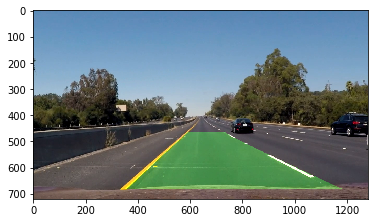

In [167]:
# process video frames
l_line = Line()
r_line = Line()

# image_frames = glob.glob('./vid_frame_10/*.jpg')
# for image in image_frames:
#     img = cv2.imread(image)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     ret_img = process_image(img)
output = 'output_video.mp4'
# v_input = VideoFileClip('project_video.mp4').subclip(30,46)
v_input = VideoFileClip('project_video.mp4')
processed_clip = v_input.fl_image(process_image)
%time processed_clip.write_videofile(output, audio=False)

In [442]:


# newclip = VideoFileClip('project_video.mp4').subclip(0,-2)
# grab video frames & dump into vid_frames
vidcap = cv2.VideoCapture('project_video.mp4')
vidcap.set(0,22000) 
# success,image = vidcap.read()
count = 0
success = True

while success and (count <= 40):
  success,image = vidcap.read()
#   print 'Read a new frame: ', success
  cv2.imwrite("fram_22/frame%d.jpg" % count, image)     # save frame as JPEG file
  count += 1
print('done')

done


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

I think the major problems were in tuning the filters and thresholds to work for various cases. I had to keep saving frames to draw the filters on each image frame and idenitfy the frame which was casuing issues or deviation. Any amount of averaging and normalization is of no consequence if the polynomial line detected is not fairly accurate. This means the most important step is identifying the right combination of thresholds for the image. I am concerned on how this would work on images in different weather conditions. Different weather conditions liek snow or rain may hamper the visibility of the road (as seen by the camera)..making the detection inaccurate.
Also conditions when there are no lane lines which is fairly common in different places would render this algorithm ineffective.
I think it would be preferrable to combine the computer vision based approach along with deep learning approach to make it more robust and also implementing some sort of dynamic thresholding maybe more useful as well.